# FT-ICR analysis - PART 2

Created on 01 March 2020 for the Pentatrap experiment

@author: Menno Door<br>
@contact: door+fticr@mpi-k.de<br>
@license: MIT license

### Introduction

This part of the analysis requires pre-analysed data of PART 1, meaning fitted frequencies and phase data. This part determines frequencies from phase data, calculating the free cyclotron frequency, filters/masks data and calculats the ratios using multiple analysis methods. The pre-analysed data has to be given in csv data files in one folder.

### Contents:
- step 0: loading data from PART1
- step 4: N determination ("phase unwrap")
- step 5: Frequency determination from phase (currently only calc nu_p from phase)
- step 6: calc nu_c (6.1 single phase sideband analysis... this we will get rid of)
- step 7: filter frequency results
- step 8: determine R using naive method
- step 9: determine R using interpolation method
- step 10: determine R using polynomial method
- step 11: determine R using cancellation-naive method
- step 12: determine R using cancellation-interpolation method
- step 13: determine R using cancellation-polynomial method
- step -1: compare results

### README & general hints

This is a short summary of steps you might want to check and problems you might run into.

    0) When you start a new analysis, definitly restart the kernel of the notebook and clear the outputs. Use the "fast-forward"-button (two arrow-head showing right) or go to "Kernel"->"Restart & Clear Output"
    1) Check the input parameters: Two cells below from this one there is a cell tagged "parameters" which lists the main variables and information needed for the analysis. This includes folders or settings for fits or other stuff. Please check it out to see what you may need to cheange there, each parameter is explained. There can be also a settings file in a measurement folder where people saved their settings (e.g. post_unwrap is set to True and its probably needed for this measurement...). These settings are always overwritten with the settings given here, so if you want to just take settings from the file, comment out the parameter in the settings dict here. 
    2) Please checkout the overview in Step 0 (loading data), how stabe is the axial frequency, the phases... Also there is an input data filter, typically given in the filter settings file (see parameter list), so if you see already in these plots that some data in the end is just random noise (phase), adjust the filter settings file and dont even load the data, that makes the analysis much easier.
    3) Check the last table in the output of Step 4 (N determination). Check if there is a wrongly determined N by checking the nu_p and end_phase. If its a q/m doublet the nu_p should be the same ish, if the phases are different by roughly 2 pi (phases are unwraped, so its possible to have 2pi), there should be a difference in N by 1. If you dont have a q/m doublet you should estimate by hand what a +-1 in N would change for your ratio and check in the end if everything checks out (compared to expected ratio).
    4) Check the filter plot in the end of Step7, maybe some values have been auto-filtered, which you might have kept or the other way around. Especially for main cycles with more false data then good, there could be problems. Filtered values are just masked, all saved files still include them.
    5) There are multiple ways to determine R from the data, all results should end up with the same value, the errors can be very different though.
    6) At the end far down, the different results will be compared. 

### Requirements:

The following code was written in Python 3.7/3.8. The required libraries are listed below with a rough description for their task in the code.

    pandas (data organisation, calculation and visualization)
    numpy (calculation)
    matplotlib (plotting)
    scipy (chi square fitting)
    jupyter (Python notebook environment)
    ipywidgets (https://ipywidgets.readthedocs.io/en/latest/user_install.html)
    plotly (plotting, https://github.com/plotly/plotly.py#installation)
    qgrid (data visualization, https://github.com/quantopian/qgrid#installation)

### TODO:

- rational function test for poly cancel
- step7/10 interpolation: calc non-linearity factor
- change to plotly at some of the smaller plots where it makes sense.
- step? (test): add allan plots for R and nu_c
- step? (test): normallity test function
- step8 (polyfit): SettingWithCopyWarining ... someone cares?
- step8 (polyfit): add another error esitmation for the fit: residuals + Kolmogorow-Smirnow-Test if the residuals are Gauß-distributed

### PROBLEMS:




In [1]:
# standard libs
from datetime import datetime, timedelta
from pathlib import Path
import os, json, time
from pprint import pprint

# math and data
import numpy as np
import scipy
from scipy import constants
import pandas as pd

# visualization
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
display(HTML("<style>div.output_scroll { height: 300em; }</style>"))

import ipywidgets as widgets
from ipywidgets import interact, interact_manual

try:
    %matplotlib inline
    show_tag = True
except:
    show_tag = False
    print("no ipython backend")
    
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.offline as py
import plotly.express as px
import qgrid

py.init_notebook_mode()

plt.rcParams['figure.figsize'] = (10, 4)

# this package
%load_ext autoreload
%autoreload 2
from fticr_toolkit import *

### WARNING !!! ###
# this will remove the warnings from pandas regarding assignments of copies of DataFrames to the other/same DataFrames. This
# is fine regarding the features implemented, but if you change stuff and its not working out as you think, you should 
# enable this again, to check if this is the problem.
pd.options.mode.chained_assignment = None  # default='warn'
# define floating points on display, this will be changed later to higher precision
pd.options.display.float_format = '{: .3f}'.format

In [80]:
###   P A R A M E T E R   L I S T   ( this is especially used for batch processing using the papermill package but its also nice to have thesse parameters all at one place )
measurement_folder = "Z:/DATA_for_ANALYSIS/analysis_Menno/20_Re_Os_ratio_cancellation/187Re29+_187Os29+_187Re29+_24"
#measurement_folder = "E:\\\\local_analysis\\Yb\\172Yb42+_176Yb43+_2"
#measurement_folder = "E:\\\\local_analysis\\132Xe_208Pb\\132Xe26+_208Pb41+_132Xe26+_5"
#measurement_folder = "E://local_analysis//HoDy//163Dy38+_163Ho38+_163Dy38+_2"
#measurement_folder = "E://local_analysis//208Pb_Pb#//208Pb41+_208mPb41+_208Pb41+_10"
#measurement_folder = "Z:/Measurements/5_arbitrary_burst_windowed_nu_m_unwrap"
#measurement_folder = "Z:/DATA_for_ANALYSIS/analysis_menno/30_Ho_Dy/02032021_165Ho39+_165Ho39+_unity_5"
input_folder = "./part1_data/" # the measurements subfolder where the pre-analysed data was saved (output of PART 1: spectra fits and/or phases) 
#input_folder = "./analysed_data/"
output_folder = "./results/" # subfolder where the results of this analysis should go
# analysis parameters are loaded from a (more static and measurement specific) settings file ('analysis_settings.json') inside the measurement folder
# for testing and batch processing the parameters can be adjusted below
settings = {
    # The filter settings are used to remove some data, which is nice if e.g. the ion was lost at some point and you dont want to see crappy random data. Either directly supply a pandas dset (more usefull for papermill batches) or rather
    # create a csv file as in the examples and just assign None to this variable, it will use the csv file then. 
    "grouping": [10],
    "filter_settings": None, # pandas dset with mc, trap, position, min_cycle, max_cycle; None: try to get filter settings from loaded data; False: no filter applied
    #"filter_settings": pd.DataFrame(
    #    columns=["mcycle", "trap", "position", "min_cycle", "max_cycle"],
    #    data=[[1,2,"position_1", 0, 26],[1,2,"position_2", 0, 26],[1,3,"position_1", 0, 26],[1,3,"position_2", 0, 26]]
    #          ),
    "post_unwrap": False, # if this is True, the analysis will automatically choose the post-unwrap (the pre-unwrap of the next main cycle) for nu_p frequency determination. Maybe the whole post-unwrap part is commented out in step 5, please check.
    "phase_filter": True, # filter measured phases by 3 sigma filter inside subcycle
    "single_axial": False, # use single spec no average axial data
    "averaging": False, # averaging subcycle data to match average_idx from part 1
    "sideband": False, # use sideband relation to calculate nu_c
    "polydegrees": 'auto', # number of degree of the polynom fit
    "polygrouping": 'auto', # group sizes for the polynom fit
    "poly_mode": "curvefit", # routine for polynom fitting
    "poly_criterion": "AICc", # criterion for best model/poly-degree
    "invert": False,
}

### Step 0: Load data

Please supply the measurement folder and filenames to the csv datasets of pre-analysed data. 

In [81]:
data, meas_config, results_dir = data_conversion.load_data(measurement_folder=measurement_folder,
                                              input_data=input_folder, # inside measurement folder
                                              output_folder=output_folder, # inside measurement folder
                                              measurement_script = "unwrap_n_measure_repeat") # inside measurement folder

#pprint(meas_config)
try:
    settings_from_file = data_conversion.load_settings(measurement_folder)
    settings_from_file.update( settings )
    settings = settings_from_file
except:
    print("no settings from file!")
print("settings", settings)
#print("invert? (default=True)", settings['invert'])

try:
    data = data_conversion.input_filter(data, settings=settings["filter_settings"])
except:
    raise
    print("no input filter")

# define local namespace names for the data, just easier
nu_p_unwrap = data["pre_unwrap_phase"]
nu_p_phases = data["phase_data"]
axial_data = data["axial_data"]
if settings.get("single_axial", False):
    axial_data = data["axial_data_single"]

# get the variables/lists we will be looping over...
mcs = axial_data.mcycle.unique()
print(" >>> MAIN CYCLES: ", mcs)
super_cycle_list = []
for mc in mcs:
    subset = axial_data[axial_data['mcycle']==mc]
    subcycles = subset.cycle.unique()
    super_cycle_list.append(list(subcycles))
print(" >>> SUB CYCLES: ", super_cycle_list, "\n")
positions = axial_data.position.unique()
print(positions)
start_position = meas_config["start_position"]
other_position = positions[0]
if start_position == other_position:
    other_position = positions[1]
    
print(" >>> POSITIONS: ", positions, " - > start at", start_position)
traps = axial_data.trap.unique()
print(" >>> TRAPS:     ", traps)

if show_tag:
    # ...and just roughly check the data...
    print(" >>> AXIAL DATA >>> ")
    #axial_data = axial_data[ (axial_data['mcycle']==1) & (axial_data['cycle'] >= 0) ]
    #fig = px.scatter(axial_data, x="time", y="nu_z", error_y="dnu_z", facet_row="position", facet_col="trap", color="cycle", hover_data=['mcycle', 'cycle', 'position'])
    fig = px.scatter(axial_data, x="time", y="nu_z", error_y="dnu_z", facet_col="trap", color="position", hover_data=['mcycle', 'cycle', 'position'])
    fig.update_yaxes(matches=None, showticklabels=True)
    fig.show()
    #display(axial_data)
    
    """ Allen Deviation for axial
    for trap, data in axial_data.groupby("trap"):
        data = data.sort_values("time")
        data['epoch'] = data["time"].astype("int64")//1e9
        data['seconds'] = data['epoch'] - data['epoch'].min()
        t = data.seconds.to_numpy()/60
        y = data.nu_z.to_numpy()
        y = y/np.mean(y)
        visualization.allanvariance(y, t, plot=True)
    """

    print(" >>> PHASE DATA >>> ")
    nu_p_phases["acc_time"] = nu_p_phases["acc_time"].astype(str)
    #fig = px.scatter(nu_p_phases, x="time", y="phase", facet_row="trap", facet_col="position", color="acc_time", hover_data=['mcycle', 'cycle', 'position'])
    fig = px.scatter(nu_p_phases, x="time", y="phase", facet_row="position", facet_col="trap", color="acc_time", hover_data=['mcycle', 'cycle', 'position'])
    #fig = px.scatter(nu_p_phases, x="time", y="phase", facet_col="trap", color="position", hover_data=['mcycle', 'cycle', 'position'])
    fig.show()
    nu_p_phases["acc_time"] = nu_p_phases["acc_time"].astype(float)

    print(" >>> PHASE DIFFERENCE START POSITION - OTHER POSITION >>> ")
    try:
        nu_p_phases["acc_time"] = nu_p_phases["acc_time"].astype(str)
        posA = nu_p_phases[nu_p_phases["position"] == start_position]
        posB = nu_p_phases[nu_p_phases["position"] != start_position]
        posA["phase_diff"] = posA.phase.to_numpy() - posB.phase.to_numpy()
        fig = px.scatter(posA, x="time", y="phase_diff", facet_row="trap", facet_col="position", color="acc_time", hover_data=['mcycle', 'cycle', 'position'])
        fig.show()
    except Exception as e:
        print(e)
        print(' DIFF only works with equal size phase data')
    finally:
        nu_p_phases["acc_time"] = nu_p_phases["acc_time"].astype(float)
        
    print(" >>> UNWRAP DATA >>> ")
    nu_p_unwrap["acc_time"] = nu_p_unwrap["acc_time"].astype(str)
    fig = px.scatter(nu_p_unwrap, x="time", y="phase", facet_col="trap", facet_row="position", color="acc_time", hover_data=['mcycle', 'cycle', 'position'])
    fig.show()
    nu_p_unwrap["acc_time"] = nu_p_unwrap["acc_time"].astype(float)
    
    """
    # trap2
    t2_phases = nu_p_unwrap[ (nu_p_unwrap['trap']==2) & (nu_p_unwrap['position']=='position_2') ]
    #display(t2_phases)
    accs = []
    pstds = []
    for name, group in t2_phases.groupby(['mcycle', 'acc_time']):
        accs.append( float(group.acc_time.unique()) )
        pstds.append( np.std( np.unwrap( group.phase.to_numpy() ) ) /2/np.pi*360 )
    plt.scatter(accs, pstds, marker='o')
    plt.show()
    
    t3_phases = nu_p_unwrap[ (nu_p_unwrap['trap']==3) & (nu_p_unwrap['position']=='position_2') ]
    #display(t3_phases)
    accs = []
    pstds = []
    for name, group in t3_phases.groupby(['mcycle', 'acc_time']):
        accs.append( float(group.acc_time.unique()) )
        pstds.append( np.std( np.unwrap( group.phase.to_numpy() ) ) /2/np.pi*360 )
    plt.scatter(accs, pstds, marker='o')
    plt.show()
    """


 >>> WARNING!!! output_folder already exists! files will maybe be overwritten! <<< 


 >>> I hope you are in PART2 or 3, loading pre analysed data from folder... <<< 

settings {'invert': False, 'filter_settings': None, 'post_unwrap': False, 'grouping': [10], 'phase_filter': True, 'single_axial': False, 'averaging': False, 'sideband': False, 'polydegrees': 'auto', 'polygrouping': 'auto', 'poly_mode': 'curvefit', 'poly_criterion': 'AICc'}
filter settings:
   mcycle  trap    position  min_cycle  max_cycle
0       1     2  position_1          0         12
1       1     2  position_2          0         12
2       1     3  position_1          0         12
3       1     3  position_2          0         12
skip pre_unwrap_phase
 >>> MAIN CYCLES:  [1]
 >>> SUB CYCLES:  [[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]] 

['position_1' 'position_2']
 >>> POSITIONS:  ['position_1' 'position_2']  - > start at position_2
 >>> TRAPS:      [2 3]
 >>> AXIAL DATA >>> 


 >>> PHASE DATA >>> 


 >>> PHASE DIFFERENCE START POSITION - OTHER POSITION >>> 


 >>> UNWRAP DATA >>> 


### Step 4: N determination

The unwrap data (in this case just for the nu_p phase measurement) is used to calculate the total N of osciallations during the phase accumulation time in the later measurement

The method n_determination.fit_N will unwrap the phases for each acc_time, average, substract the reference phases from all the other measured phases and then determine the N by calculating Ns for a 1 Hz range around the guessed frequency and searches for the minimum. A plot of the Ns and the found minimum will be plotted to check the results.

The result will be a dataFrame including N, end_phase and frequency for all main cycles, traps and positiions.

1 2 position_1

 °°° N determination °°° 


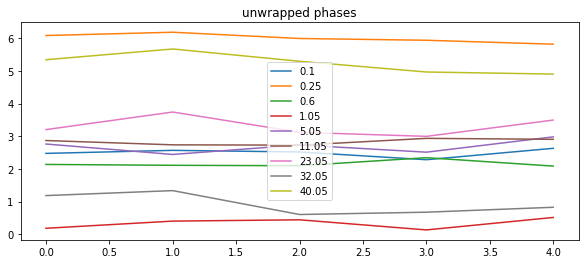

choose resolution automatically: 0.001001


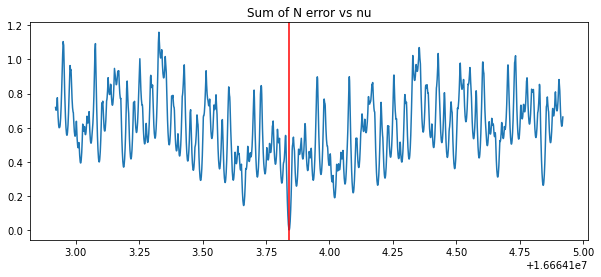

acc_time           phase          dphase                       N  \
1   0.150000000000  3.507685518265  0.098127870249    2499615.017872566823   
2   0.500000000000 -0.339672994614  0.086922475358    8332051.974520822056   
3   0.950000000000 -2.159761074185  0.109021173141   15830898.992611004040   
4   4.950000000000  0.191392707825  0.128829030868   82487313.982094734907   
5  10.950000000000  0.339983606339  0.083709142364  182471937.003968000412   
6  22.950000000000  0.816475343704  0.168560061236  382441183.019176423550   
7  31.950000000000 -1.569654250145  0.176966097966  532418117.967224001884   
8  39.950000000000  2.740124654770  0.172698824107  665730948.008664369583   

           N_intN  
1  0.017872566823  
2 -0.025479177944  
3 -0.007388995960  
4 -0.017905265093  
5  0.003968000412  
6  0.019176423550  
7 -0.032775998116  
8  0.008664369583


 °°° N = 665730948.0  last phase = 2.740124654769897  nu = 16664103.840920372  °°° 
 °°° guess = 16664103.92  diff = 0.07907962799072266  °°° 
1 2 position_2

 °°° N determination °°° 


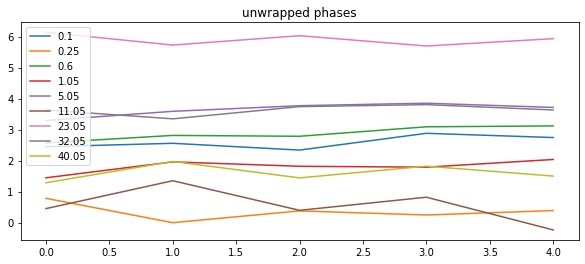

choose resolution automatically: 0.001001


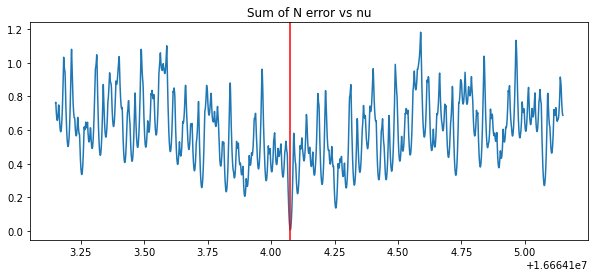

acc_time           phase          dphase                       N  \
1   0.150000000000 -2.234454704125  0.183429708604    2499615.967013317626   
2   0.500000000000  0.281695842743  0.161771059229    8332051.993129401468   
3   0.950000000000 -0.784461832047  0.161158690704   15830898.996980085969   
4   4.950000000000  1.050028181076  0.157699332770   82487315.008713424206   
5  10.950000000000 -2.036519784529  0.318285565626  182471939.955505043268   
6  22.950000000000  3.309560966492  0.148553432289  382441188.015754342079   
7  31.950000000000  1.037713909149  0.143260688185  532418125.060658335686   
8  39.950000000000 -0.988983249664  0.182877128094  665730957.990620255470   

           N_intN  
1 -0.032986682374  
2 -0.006870598532  
3 -0.003019914031  
4  0.008713424206  
5 -0.044494956732  
6  0.015754342079  
7  0.060658335686  
8 -0.009379744530


 °°° N = 665730958.0  last phase = -0.9889832496643067  nu = 16664104.075925374  °°° 
 °°° guess = 16664104.15  diff = 0.0740746259689331  °°° 
1 3 position_1

 °°° N determination °°° 


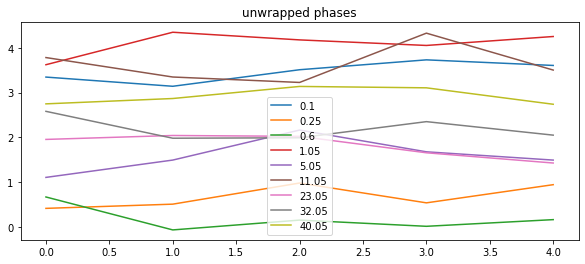

choose resolution automatically: 0.001001


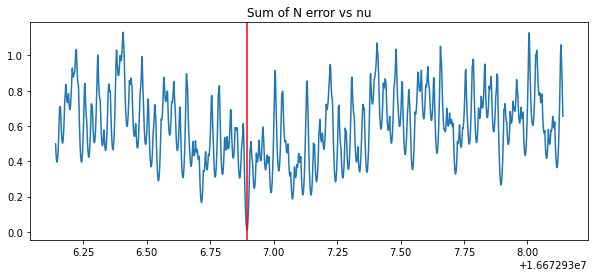

acc_time           phase          dphase                       N  \
1   0.150000000000 -2.786535006762  0.178764262921    2500940.977703966200   
2   0.500000000000 -3.276541715536  0.187372874274    8336468.968854962848   
3   0.950000000000  0.622543907166  0.185968795254   15839289.950935650617   
4   4.950000000000 -1.878098845482  0.228181287789   82531037.927942529321   
5  10.950000000000  0.170151185989  0.252324331136  182568658.970479249954   
6  22.950000000000 -1.644477200508  0.180544939843  382643901.996337950230   
7  31.950000000000 -1.274551796913  0.179167777308  532700333.990251243114   
8  39.950000000000 -0.546422243118  0.152676859643  666083829.032400250435   

           N_intN  
1 -0.022296033800  
2 -0.031145037152  
3 -0.049064349383  
4 -0.072057470679  
5 -0.029520750046  
6 -0.003662049770  
7 -0.009748756886  
8  0.032400250435


 °°° N = 666083829.0  last phase = -0.5464222431182861  nu = 16672936.894754305  °°° 
 °°° guess = 16672937.14  diff = 0.24524569511413574  °°° 
1 3 position_2

 °°° N determination °°° 


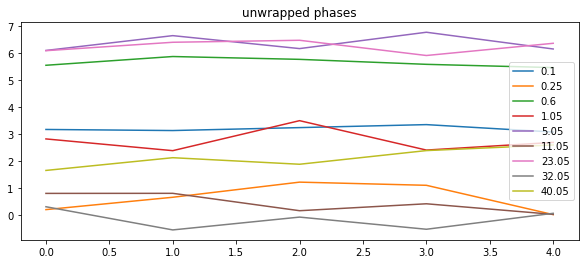

choose resolution automatically: 0.001001


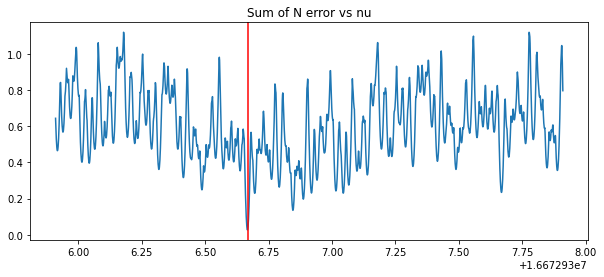

acc_time           phase          dphase                       N  \
1   0.150000000000 -2.553054635040  0.276777753541    2500940.906344711315   
2   0.500000000000  2.453213548660  0.101586151934    8336467.942937090062   
3   0.950000000000 -0.432916593552  0.236794181072   15839289.902319308370   
4   4.950000000000  3.172968961396  0.170534094763   82531035.995450019836   
5  10.950000000000 -2.750419827551  0.190868614370  182568656.938724488020   
6  22.950000000000  3.053661834594  0.133110784006  382643896.016051828861   
7  31.950000000000 -3.348588656035  0.199001145540  532700327.035808324814   
8  39.950000000000 -1.064167046547  0.200763956640  666083820.006281733513   

           N_intN  
1 -0.093655288685  
2 -0.057062909938  
3 -0.097680691630  
4 -0.004549980164  
5 -0.061275511980  
6  0.016051828861  
7  0.035808324814  
8  0.006281733513


 °°° N = 666083820.0  last phase = -1.064167046546936  nu = 16672936.666756306  °°° 
 °°° guess = 16672936.91  diff = 0.24324369430541992  °°° 


mcycle trap    position          N       end_phase                   nu_p  \
0      1    2  position_1  665730948  2.740124654770  16664103.840920371935   
1      1    2  position_2  665730958 -0.988983249664  16664104.075925374404   
2      1    3  position_1  666083829 -0.546422243118  16672936.894754305482   
3      1    3  position_2  666083820 -1.064167046547  16672936.666756305844   

        ion                          time     max_acc_time  
0  187Re29+ 2020-07-14 01:51:51.048902822  39.950000000000  
1  187Os29+ 2020-07-14 01:27:34.211468666  39.950000000000  
2  187Os29+ 2020-07-14 01:51:51.048902822  39.950000000000  
3  187Re29+ 2020-07-14 01:27:34.211468666  39.950000000000

In [82]:
# each ion in each trap its own N determination, for every main cycle! (no grouping here, wouldn't make any sense)

columns = ["mcycle", "trap", "position", "N", "end_phase", "nu_p", "ion", "time", "max_acc_time"]
nu_p_N = pd.DataFrame(columns = columns)

for mc in mcs:
    for trap in traps:
        for pos in positions:
            print(mc, trap, pos)
            subset = nu_p_unwrap[(nu_p_unwrap["mcycle"] == mc) & (nu_p_unwrap["trap"] == trap) & (nu_p_unwrap["position"] == pos)]

            # NOTE: if the structure of the config changed, you have to adjust here!
            nu_p_guess = meas_config[pos]["configuration"]["traps"][trap]["nu_p"]
            ion_str = meas_config[pos]["configuration"]["traps"][trap]["ion"]
            #evolution_time = abs(meas_config["accumulation_time"][0]["time"] - meas_config["accumulation_time"][1]["time"])

            #print(" >>> mc", mc, "trap", trap, "pos", pos, " <<< ")
            N, end_phase, nu_p, mean_time, max_acc_time = phase_analysis.determine_N(subset, nu_p_guess, resolution=None, nu_range=2, show=show_tag)
            new_row = pd.Series([mc, trap, pos, N, end_phase, nu_p, ion_str, mean_time, max_acc_time], index=nu_p_N.columns )
            nu_p_N = nu_p_N.append(new_row, ignore_index=True)

# show results and save to csv in results folder
display(nu_p_N)
nu_p_N.to_csv(results_dir + "step4_nu_p_N.csv")
nu_p_N.to_csv(results_dir + "step4_nu_p_N.txt", sep="\t")

In [83]:
# modify an N:
nu_p_N.at[0, "N"] -= 0
display(nu_p_N)

mcycle trap    position          N       end_phase                   nu_p  \
0      1    2  position_1  665730948  2.740124654770  16664103.840920371935   
1      1    2  position_2  665730958 -0.988983249664  16664104.075925374404   
2      1    3  position_1  666083829 -0.546422243118  16672936.894754305482   
3      1    3  position_2  666083820 -1.064167046547  16672936.666756305844   

        ion                          time     max_acc_time  
0  187Re29+ 2020-07-14 01:51:51.048902822  39.950000000000  
1  187Os29+ 2020-07-14 01:27:34.211468666  39.950000000000  
2  187Os29+ 2020-07-14 01:51:51.048902822  39.950000000000  
3  187Re29+ 2020-07-14 01:27:34.211468666  39.950000000000

### Step 5: Frequency determination from phase data

The phase data (in this case just for the nu_p phase measurement) is now evaluated to determine the corresponding frequency.

The procedure is split into to parts (two cells) and a last cell for data-handling.

#### Cell 1: Unwrapping subcycles / substract reference / unwrap main cycle / assign phase error / 3 sigma phase filter (masked)

#### Cell 2: Unwrap relative to N determination phase / Calc nu_p via phase data and N determination data (pre or post unwrap data)

#### Cell 3: The frequency determination is finished, but data has to be averaged or exanded now for the next anaylsis steps.

mean night phase jitter trap 2 19.025253165964603
mean night phase jitter trap 3 25.092659819176514
mean phase error in trap 2 19.632861912181962
mean phase error in trap 3 27.44857961348519
filtered 3sigma phase 1
filtered 3sigma phase 1


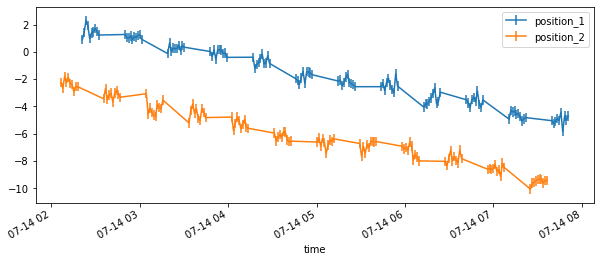

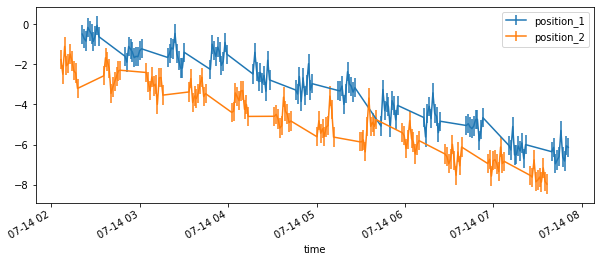

mcycle  cycle    position  trap  acc_time                       time  \
140       1      3  position_2     2   39.9500 2020-07-14 03:04:33.868681   
435       1      8  position_2     3   39.9500 2020-07-14 05:35:31.988437   

      phase  average_idx  masked  dphase  
140 -3.0722            0    True  0.3427  
435 -3.6835            0    True  0.4791

In [84]:
# unwrapping, substracting reference phase, unwrapping for full main cycle, phase filter
pd.options.display.float_format = '{: .4f}'.format

#nu_p_phases2 = nu_p_phases.copy()
nu_p_phases['dphase'] = np.nan
step5_results = pd.DataFrame()

# U N W R A P,   S U B S T R A C T   R E F E R E N C E,   U N W R A P,   P H A S E   F I L T E R
for grpname, grp in nu_p_phases.groupby(["mcycle", "trap", "position"]):
    # unwrap the phases inside each cycle
    grp_new = phase_analysis.unwrap_subsets(grp, groupby=["acc_time", "cycle"])
    # substract referenc phases
    grp_new = phase_analysis.substract_ref_phase(grp_new)
    # unwrap again inside each cycle
    grp_new = phase_analysis.unwrap_subsets(grp_new, groupby=["cycle"])
    # assign stds of each cycle to be error of single phase
    grp_new = statistics.assign_stderr_subsets(grp_new, groupby=["cycle"], val="phase", dval="dphase")
    # unwrap over main cycle
    grp_new = phase_analysis.unwrap_dset(grp_new, column="phase", drift_unwrap=False, drift_pi_span=1.1, timesort=True, reverse=settings.get("post_unwrap", False), show=False)
    
    # The assignment thing here is unfortunatily neccessary, because we delete the reference phases from the dataset and
    # theirfor the index does not fit anymore...
    step5_results = step5_results.append(grp_new, ignore_index=True)
    
# check night data phase stability between 0 and 4 in the morning (silent mag-field time)
for grpname, grp in step5_results.groupby(["trap"]):
    subset = grp.copy(deep=True)
    subset = subset.set_index(subset['time'], drop=True)
    subsub = subset.between_time('00:00:00', '04:00:30')
    print("mean night phase jitter trap", grpname, np.mean(subsub.dphase.unique())*180/np.pi)

#for grpname, grp in step5_results.groupby(["trap", "position"]):
#    # unwrap over complete data of this trap/position (this is safer here then in the loop before, since the next main
#    # cycles use the already stable fit from before.)
#    step5_results["phase"].loc[grp.index] = phase_analysis.drift_unwrap_method(grp["phase"].to_numpy(), pi_span = 1.3, min_fit = 1, times=grp["time"].astype('int64')//1e9)

# WARNING THIS DOES ONLY WORK IF YOU DONT HAVE RANDOM PHASES AT THE END OF THE MEASUREMENT!
# assign mean phase std (for full trap data) as phase error
for grpname, grp in step5_results.groupby(["trap"]):
    mean_std = grp["dphase"].mean()
    print("mean phase error in trap", grpname, mean_std*180/np.pi)
    idx = grp.index
    step5_results["dphase"].loc[idx] = mean_std

step5_results['masked'] = False

# 3 sigma filter on phase data
if settings["phase_filter"]:
    for grpname, grp in step5_results.groupby(["mcycle", "trap", "position", "cycle"]):
        grp = filtering.three_sigma(grp, 'phase', err=None, undrift_xcolumn='time', manual_std=grp["dphase"].mean(), show=False)
        idx = grp.index
        step5_results["masked"].loc[idx] = grp["masked"]
        
if show_tag:
    for grpname, grp in step5_results.groupby("trap"):
        fig, ax = plt.subplots()
        for subname, subgrp in grp.groupby("position"):
            ax = subgrp.plot(ax=ax, x="time", y="phase", yerr="dphase", label=subname)
        plt.show()

maskedphases = step5_results[ step5_results["masked"] == True ]
display(maskedphases)

 >>> NORMAL: using Pre-Unwrap! <<< 
 >>> NORMAL: using Pre-Unwrap! <<< 


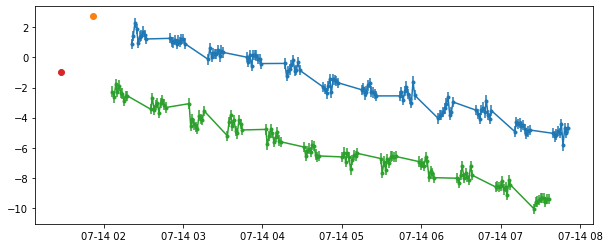

 >>> NORMAL: using Pre-Unwrap! <<< 
 >>> NORMAL: using Pre-Unwrap! <<< 


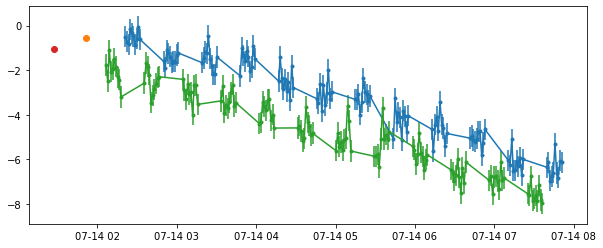

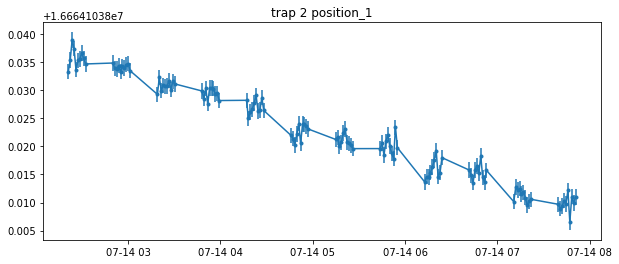

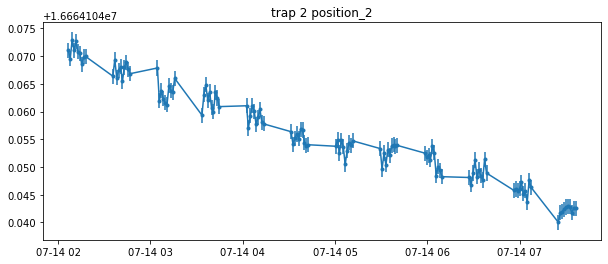

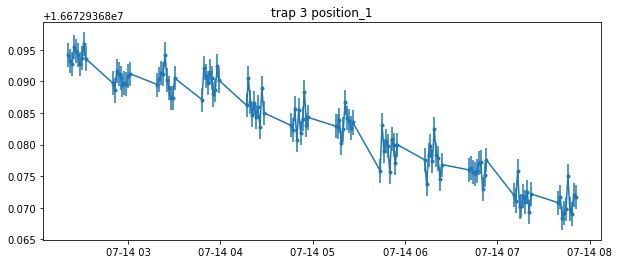

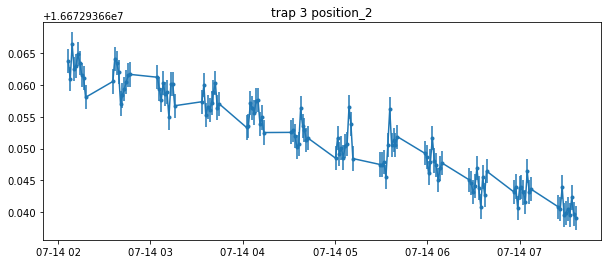

> masked data:


mcycle  cycle    position  trap  acc_time                       time  \
140       1      3  position_2     2   39.9500 2020-07-14 03:04:33.868681   
435       1      8  position_2     3   39.9500 2020-07-14 05:35:31.988437   

      phase  average_idx  masked  dphase           nu_p   dnu_p  
140 -3.0722            0    True  0.3427  16664104.0679  0.0014  
435 -3.6835            0    True  0.4791  16672936.6562  0.0019

In [85]:
# calc frequency from phase using N_determination from unwrap data
step5_results['nu_p'] = np.nan
step5_results['dnu_p'] = np.nan

wait = True
for grpname, grp in step5_results.groupby(["mcycle", "trap", "position"]):
    mc, trap, pos = grpname

    # get the results from the unwrap measurement (pre and post)
    N_data = nu_p_N[(nu_p_N['mcycle'] == mc) & (nu_p_N['trap'] == trap) & (nu_p_N['position'] == pos)]
    reverse = False

    N_data_next = nu_p_N.loc[(nu_p_N['mcycle'] == mc+1) & (nu_p_N['trap'] == trap) & (nu_p_N['position'] == pos)]
    if settings["post_unwrap"] and (len(N_data_next) != 0):
        N_data = N_data_next
        reverse = True
        print(" >>> WARNING: using Post-Unwrap! <<< ")
    else:
        print(" >>> NORMAL: using Pre-Unwrap! <<< ")
        
    #display(N_data)
    last_phase = float(N_data["end_phase"])
    N = float(N_data["N"])
            
    # now we have to unwrap all the phases in this main cycle using the last phase of the
    # N determination as a starting phase. This way we assure that the N from the N_determination
    # fits the phases in the measurement.
    grp = phase_analysis.unwrap_dset(grp, column=["phase"], start_phase = last_phase, reverse = reverse,
                                     drift_unwrap="timex", drift_pi_span=1.1, timesort = True, start_phase_time = N_data["time"], show=False)

    # calculating frequency and error... 
    grp["nu_p"] = phase_analysis.calc_nu(N, grp["acc_time"], grp["phase"])
    grp["dnu_p"] = phase_analysis.calc_dnu(grp["acc_time"], grp["dphase"])
    
    if True:        
        plt.errorbar(grp.time, grp.phase, grp.dphase, marker='.')
        plt.plot(N_data["time"], last_phase, marker='o')
        #plt.plot(N_data["time"], (N+last_phase/2/np.pi)/float(N_data["max_acc_time"]), marker='o')
        if wait:
            wait = False
        else:
            plt.show()
            wait = True
    
    step5_results.loc[grp.index] = grp

if show_tag:
    for grpname, grp in step5_results.groupby(["trap", "position"]):
        plt.errorbar(grp.time, grp.nu_p, grp.dnu_p, marker='.')
        plt.title("trap " + str(grpname[0]) +" "+ str(grpname[1]))
        plt.show()

#step5_results.sort_values(by='time', inplace=True)
#display(step5_results)
step5_results.to_csv(results_dir + "step5_nu_p_values.csv")
step5_results.to_csv(results_dir + "step5_nu_p_values.txt", sep="\t")
print("> masked data:")
maskedphases = step5_results[ step5_results["masked"] == True ]
display(maskedphases)

In [86]:
fig = px.scatter(step5_results, x="time", y="nu_p", error_y="dnu_p", facet_col="trap", color="position", hover_data=['mcycle', 'cycle', 'position'])
fig.update_yaxes(matches=None, showticklabels=True)
fig.show()

#### Decision: Averaged or single phases?

At this point in the analysis you have to choose if you want to work with averaged data (default) or with single phases. The axial spectra typically have to be averaged to reach enough signal-to-noise-ratio to be able to fit a dip. That results in less nu_z data points than nu_p data points from phases (which we get from every subcycle measurement). If you want to work with averaged data, the phases will be averaged to match the nu_z data. If you want to work with single phases, the axial data will be assigned to all phases with an increased errorbar by np.sqrt(N). This way, averaging afterwords would result in the same axial frequency error again.

For the interpolation method, averaging is done seperatly even if you choose single phase. It just doesnt work with single phases.

In [87]:
# merge with axial data: First just expanding the time-matching axial fits to the phase information!
step5_all_freqs = pd.DataFrame()
axial_data.sort_values(by=["mcycle", "trap", "cycle", "position"], inplace=True)
step5_results.sort_values(by=["mcycle", "trap", "cycle", "position", "time"], inplace=True)
step5_results_p = step5_results.rename(columns = {'time': 'time_p', 'phase': 'phase_p', 'dphase': 'dphase_p', 'average_idx': 'average_idx_p'})

groupby = ["mcycle", "trap", "cycle", "position"]

lastgrpname = None
average_idx = []
for grpname, grpphase in step5_results_p.groupby(groupby):
    if lastgrpname is None:
        lastgrpname = grpname
    mc, trap, cyc, pos = grpname
    #print('mcycle', mc, 'trap', trap, 'cycle', cyc, 'position', pos)
    
    grpaxial = axial_data
    for key, val in zip(groupby, grpname):
        grpaxial = grpaxial[ grpaxial[key] == val ]
    
    grpaxial_time = grpaxial.set_index('time') # set column 'time' to index
    current_axial_index = None
    subcycle = 0
    for idx, row in grpphase.iterrows():
        subcycle += 1
        # get the time-wise nearest date for axial frequencies
        axial_idx = grpaxial_time.index.get_loc(row.time_p, method='nearest')
        axial_row = grpaxial.iloc[axial_idx]
        #print('phase cycle', row['cycle'], 'axial cycle', axial_row['cycle'], 'phase time', row['time_p'], 'axial time', axial_row['time'])
        axial_row = axial_row.iloc[axial_row.index.isin(['time', 'nu_z', 'dnu_z', 'dip_width', 'ddip_width', 'fit_err', 'fit_success', 'average_idx'])]

        new_row = row.append(axial_row)
        new_row["subcycle"] = subcycle
        step5_all_freqs = step5_all_freqs.append(new_row, ignore_index=True)        
        
        # IMPORTANT! We are expanding the axial data, so we have to assign an expanded error the way that the averaged value gets the same error as before!
        if current_axial_index is None:
            current_axial_index = axial_idx
        
        if current_axial_index != axial_idx or lastgrpname != grpname:
            new_err = last_dnu_z*np.sqrt(len(average_idx))
            step5_all_freqs.loc[average_idx, "dnu_z"] = float(new_err)
            average_idx = []
            lastgrpname = grpname

        average_idx.append( step5_all_freqs.index[-1] )
        last_dnu_z = axial_row["dnu_z"]

step5_all_freqs = data_conversion.fix_column_dtypes(step5_all_freqs)

if show_tag:
    #fig = px.scatter(step5_all_freqs, x="time_p", y="nu_p", error_y="dnu_p", facet_col="trap", facet_row="position", color="masked", hover_data=['mcycle', 'cycle', 'position'])
    fig = px.scatter(step5_all_freqs, x="time_p", y="nu_p", error_y="dnu_p", facet_col="trap", color="position", hover_data=['mcycle', 'cycle', 'position'])
    fig.update_yaxes(matches=None, showticklabels=True)
    fig.show()

step5_all_freqs.to_csv(results_dir + "step5_all_freqs_values.csv")
step5_all_freqs.to_csv(results_dir + "step5_all_freqs_values.txt", sep="\t")

In [88]:
# average:
if settings.get("averaging", False):
    new_df = pd.DataFrame()
    for grpname, grpphase in step5_all_freqs.groupby(["mcycle", "trap", "cycle", "position"]):
        avg = statistics.average_subsets(grpphase, groupby=["average_idx"], errortype="weighted",
                                              columns=["phase_p", "nu_p", "nu_z", "time_p"], 
                                              dcolumns=["dphase_p", "dnu_p", "dnu_z", None],
                                              masked=True)
        new_df = new_df.append(avg, ignore_index=True)
    step5_all_freqs = new_df
    
    if show_tag:
        fig = px.scatter(step5_all_freqs, x="time_p", y="nu_p", error_y="dnu_p", facet_col="trap", facet_row="position", hover_data=['mcycle', 'cycle', 'position'])
        fig.update_yaxes(matches=None, showticklabels=True)
        fig.show()

    step5_all_freqs.to_csv(results_dir + "step5_all_freqs_values.csv")
    step5_all_freqs.to_csv(results_dir + "step5_all_freqs_values.txt", sep="\t")


### Step 6: Calc free cyclotron

Use the 3 eigenfrequencies to calculate the free cyclotron frequency

In [89]:
#step6_results = pd.DataFrame()
pd.options.mode.chained_assignment = None  # default='warn'
step6_results = step5_all_freqs.copy()
step6_results['nu_c'] = np.nan
step6_results['dnu_c'] = np.nan
step6_results['nu_c_sb'] = np.nan
step6_results['dnu_c_sb'] = np.nan
step6_results['ion'] = ""

for grpname, grp in step6_results.groupby(["mcycle", "trap", "position"]):
    mc, trap, pos = grpname
    
    # get nu_m from measurement config
    nu_m = meas_config[pos]["configuration"]["traps"][trap]["nu_m"]
    dnu_m = 0.0
    #print("nu_m", nu_m, "dnu_m", dnu_m)
    grp["ion"] = meas_config[pos]["configuration"]["traps"][trap]["ion"]    
    
    # calc nu_c
    grp["nu_c"], grp["dnu_c"] = frequencies.calc_nu_c_error(
        grp["nu_p"], grp["nu_z"], nu_m,
        grp["dnu_p"], grp["dnu_z"], dnu_m
    )
    #print(grp["nu_c"].mean(), grp["nu_p"].mean(), grp["nu_z"].mean(), nu_m)
    
    # calc nu_c sideband
    grp["nu_c_sb"], grp["dnu_c_sb"] = frequencies.calc_nu_c_sb_error(
        grp["nu_p"], nu_m,
        grp["dnu_p"], dnu_m
    )

    # save
    step6_results.iloc[grp.index] = grp

#display( step6_results[ (step6_results["trap"]==2) & (step6_results["position"]=="position_2") ] )
if show_tag:
    fig = visualization.compare_dset_columns(step6_results, x=["time_p", "time_p"], y=["nu_c", "nu_c_sb"], yerr=["dnu_c", "dnu_c_sb"], facet_col="trap", facet_row="position")

#display(step6_results.ion)
step6_results.to_csv(results_dir + "step6_nu_c.csv")
step6_results.to_csv(results_dir + "step6_nu_c_avg.txt", sep="\t")

### Step 7: Filter data

First we apply some automated filters, see the next cell. They should mark the most obvious outlines.
Then you should check your frequency results manually: 

The most convinient option is the filter_plot where you can choose the data you want to see and modify the "masked" property of a row in a dataset by clicking the individual point in the plot. 

Also possible to use is the filter_grid which allows you to filter columns, e.g. only show trap2, only position_1 and/or only after a certain date (TODO: time...), The modification of data is blocked except for the column "masked", where you can mark bad data.

Masking (setting "masked" = True) will not effect the nu_c calculation, but the polynomial fit method and the cancellation method.

In [90]:
#if "filter_settings" in data:
#    filter_settings = data["filter_settings"]
#    display(filter_settings)
#    for i in range(0, len(filter_settings)):
#        row = filter_settings.iloc[i]
#        mcycle = int(row["mcycle"])
#        step6_results.at[ (step6_results["mcycle"] == mcycle) & (step6_results["cycle"] < row["min_cycle"]) , "masked"] = True
#        step6_results.at[ (step6_results["mcycle"] == mcycle) & (step6_results["cycle"] > row["max_cycle"]) , "masked"] = True#

# MANUAL PREFILTER BY CYCLES:
#step6_results.at[(step6_results["cycle"] < 14), "masked"] = True

In [91]:
# A few automatic filtering methods TODO: could someone please check these methods? :D
pd.options.mode.chained_assignment = None  # default='warn'

if "masked" not in step6_results:
    step6_results["masked"] = False

step7_results = pd.DataFrame()
step6_results = data_conversion.fix_column_dtypes(step6_results)

for mc in mcs:
    for trap in traps:
        for pos in positions:
            # get the subset
            print(" >>> FILTERING:", "mcycle", mc, "trap", trap, "pos", pos)
            subset = step6_results[(step6_results["mcycle"] == mc) & (step6_results["trap"] == trap) & (step6_results["position"] == pos)]
            
            # filter nan values (sometimes happens when an axial spectrum is missing)
            subset = filtering.nan_filter(subset, columns=["nu_c"])

            # filter by min max boundaries for values, default: min_val: 1, max_val: 1e9:
            subset = filtering.minmax_value(subset, val="nu_z")
            subset = filtering.minmax_value(subset, val="nu_p")
            subset = filtering.minmax_value(subset, val="nu_c")
            
            # apply autofilter 3-sigma condition: calc mean of values and std
            # if value is outside of mean+-3*std, it is masked
            subset = filtering.three_sigma(subset, val="nu_z", err="dnu_z", undrift_xcolumn="time", show=False)
            subset = filtering.three_sigma(subset, val="nu_p", err="dnu_p", undrift_xcolumn="time_p", show=False)
            subset = filtering.three_sigma(subset, val="nu_c", err="dnu_c", undrift_xcolumn="time_p", show=False)
            #display(subset)

            # apply autofilter sigma-size: if sigma of value is 3 time bigger
            # then mean sigma, it is masked
            subset = filtering.sigma_size(subset, err="dnu_z")
            subset = filtering.sigma_size(subset, err="dnu_p")
            subset = filtering.sigma_size(subset, err="dnu_c")
            #display(subset)
            # save
            step7_results = step7_results.append(subset, ignore_index=True)
            
#display(step7_results)

 >>> FILTERING: mcycle 1 trap 2 pos position_1
 >>> FILTERING: mcycle 1 trap 2 pos position_2
 >>> FILTERING: mcycle 1 trap 3 pos position_1
 >>> FILTERING: mcycle 1 trap 3 pos position_2
filtered 3sigma nu_c 1


In [92]:
step7_results = data_conversion.fix_column_dtypes(step7_results)

if show_tag:
    fig = px.scatter(step7_results, x="time_p", y="nu_c", error_y="dnu_c", facet_col="trap", facet_row="position", color="masked", hover_data=['mcycle', 'cycle', 'position'])
    #fig = px.scatter(step7_results, x="time_p", y="nu_c", error_y="dnu_c", facet_col="trap", color="position", hover_data=['mcycle', 'cycle', 'position'])
    fig.update_yaxes(matches=None, showticklabels=True)
    fig.show()

In [93]:
# interactive plots for masking: choose the mcycle, trap, position and frequency you want to check and 
# just double click on a point to mask/unmask it. Changes are changed automatically.
step7_results['epoch_p'] = step7_results['time_p'].astype('int64')//1e9
step7_results = data_conversion.fix_column_dtypes(step7_results)
pd.options.mode.chained_assignment = None  # default='warn'

widg = "no plot"
if show_tag:
    widg = visualization.filter_plot(step7_results, groupby=["mcycle", "trap", "position"], ydata=["nu_c", "nu_z", "nu_p", "nu_c_sb"], xdata=["epoch_p"])
widg

In [94]:
# filtering and checking the data in a table format
# be carefull!!!
# 1) if you changed "masked" values, you have to run the next cell to save them!
# 2) if you used the filter option to for example just show trap2 data or only the ones with masked==True, you have to remove these filters
#    before you save the changes with execution of the next cell, since you will only save the visible data!

qgrid_widget = visualization.filter_grid(step7_results)
qgrid_widget

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': False, 'defa…

[0.             0.020555555556 0.041388888889 0.062222222222
 0.082777777778 0.103611111111 0.124444444444 0.145277777778
 0.165833333333 0.186666666667 0.482222222222 0.503055555556
 0.523888888889 0.544722222222 0.565555555556 0.586111111111
 0.606944444444 0.627777777778 0.648611111111 0.669166666667
 0.965          0.985833333333 1.006388888889 1.027222222222
 1.048055555556 1.068611111111 1.089444444444 1.110277777778
 1.130833333333 1.151666666667 1.4475         1.468055555556
 1.488888888889 1.509722222222 1.530277777778 1.551111111111
 1.571944444444 1.592777777778 1.613333333333 1.634166666667
 1.93           1.950555555556 1.971388888889 1.992222222222
 2.013055555556 2.033611111111 2.054444444444 2.075277777778
 2.095833333333 2.116666666667 2.412222222222 2.433055555556
 2.453888888889 2.474722222222 2.495277777778 2.516111111111
 2.536944444444 2.5575         2.578333333333 2.599166666667
 2.894722222222 2.915555555556 2.936111111111 2.956944444444
 2.977777777778 2.998611

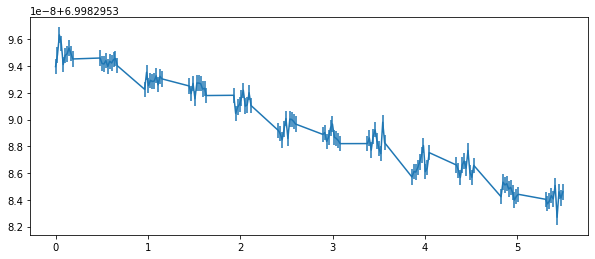

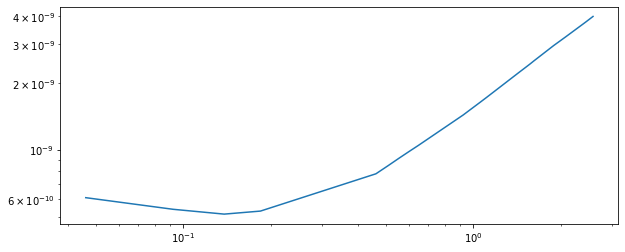

drift per hour -2.0901752155998757e-09


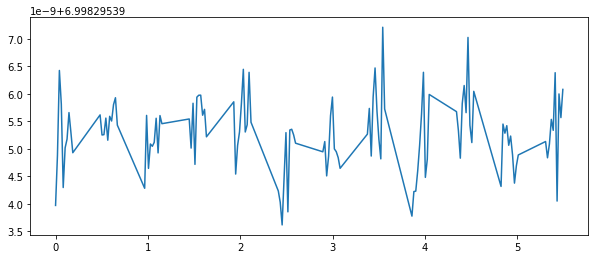

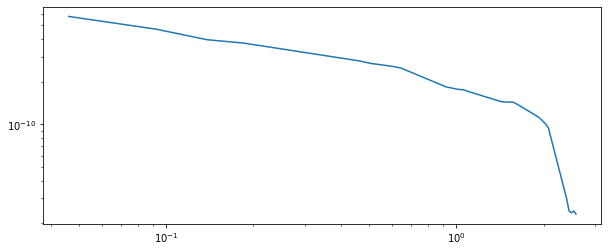

[1.000000000634 1.000000000758 1.000000000973 1.000000000879
 1.000000000656 1.000000000753 1.000000000769 1.000000000832
 1.000000000776 1.000000000715 1.000000000725 1.000000000667
 1.000000000662 1.000000000698 1.000000000635 1.000000000691
 1.000000000672 1.000000000709 1.00000000072  1.000000000643
 1.000000000391 1.000000000574 1.00000000043  1.000000000487
 1.000000000475 1.000000000479 1.000000000535 1.000000000439
 1.00000000053  1.000000000503 1.000000000427 1.000000000345
 1.000000000455 1.00000000029  1.000000000459 1.000000000457
 1.000000000451 1.000000000393 1.000000000402 1.000000000324
 1.000000000327 1.000000000133 1.000000000201 1.00000000023
 1.000000000299 1.000000000381 1.000000000211 1.000000000224
 1.000000000354 1.000000000218 0.999999999951 0.999999999916
 0.999999999851 0.999999999965 1.000000000078 0.999999999866
 1.000000000072 1.000000000068 1.000000000047 1.00000000002
 0.999999999909 0.999999999929 0.999999999834 0.999999999879
 0.999999999978 1.00000000

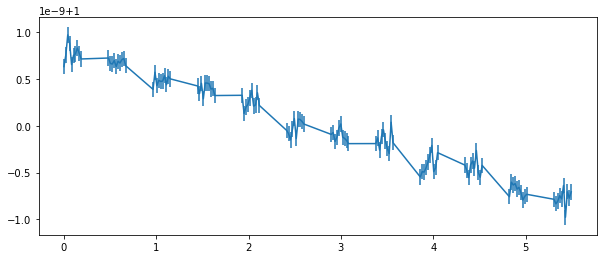

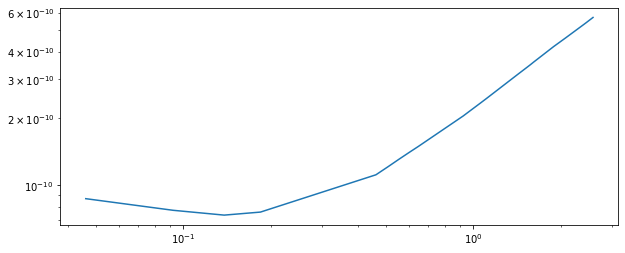

drift per minute/hour -2.986691070373077e-10


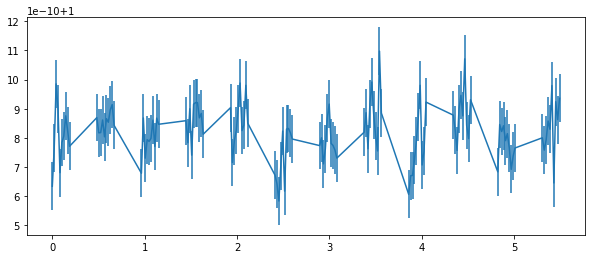

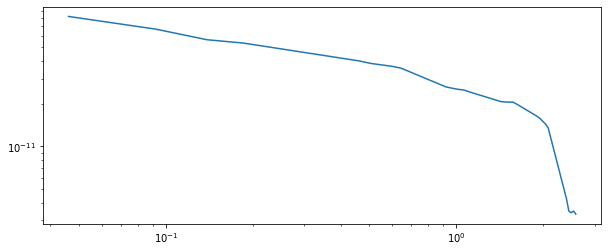

[0.             0.020833333333 0.041388888889 0.062222222222
 0.083055555556 0.103888888889 0.124444444444 0.145277777778
 0.166111111111 0.186944444444 0.4825         0.503333333333
 0.524166666667 0.544722222222 0.565555555556 0.586388888889
 0.607222222222 0.627777777778 0.648611111111 0.669444444444
 0.965          0.985833333333 1.006666666667 1.0275
 1.048055555556 1.068888888889 1.089722222222 1.110277777778
 1.131111111111 1.151944444444 1.4475         1.468333333333
 1.488888888889 1.509722222222 1.530555555556 1.551388888889
 1.572222222222 1.592777777778 1.613611111111 1.634444444444
 1.93           1.950833333333 1.971666666667 1.992222222222
 2.013055555556 2.033888888889 2.054722222222 2.075277777778
 2.096111111111 2.116944444444 2.4125         2.433333333333
 2.453888888889 2.474722222222 2.495555555556 2.516111111111
 2.536944444444 2.557777777778 2.578611111111 2.599166666667
 2.895          2.915555555556 2.936388888889 2.957222222222
 2.977777777778 2.998611111111 3

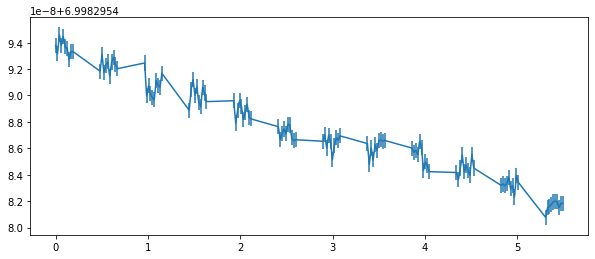

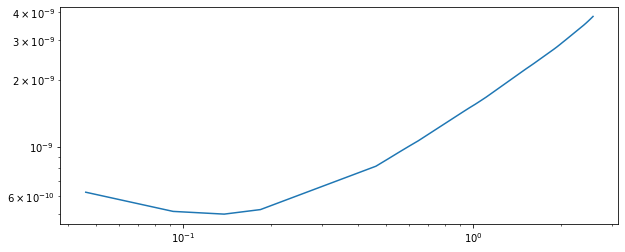

drift per hour -2.088001494272219e-09


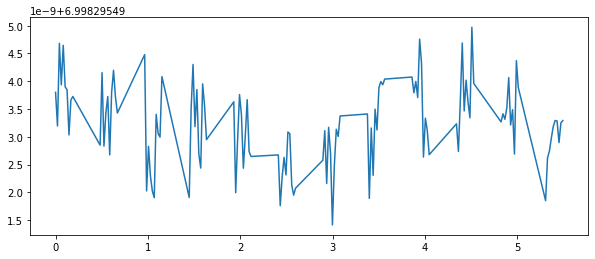

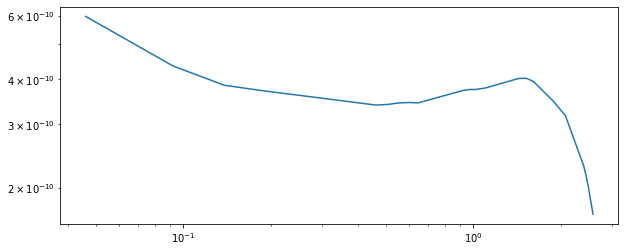

[1.000000000901 1.000000000808 1.000000001014 1.000000000901
 1.000000000997 1.000000000884 1.00000000087  1.000000000748
 1.000000000831 1.000000000834 1.000000000621 1.000000000801
 1.000000000606 1.000000000685 1.000000000721 1.000000000565
 1.000000000719 1.00000000077  1.000000000695 1.000000000648
 1.00000000071  1.000000000353 1.000000000461 1.000000000379
 1.000000000334 1.000000000311 1.000000000519 1.000000000464
 1.000000000448 1.000000000597 1.000000000198 1.000000000421
 1.000000000528 1.000000000362 1.000000000451 1.00000000028
 1.000000000237 1.000000000447 1.000000000385 1.000000000291
 1.0000000003   1.000000000061 1.000000000192 1.000000000301
 1.000000000242 1.000000000099 1.000000000175 1.000000000263
 1.000000000123 1.000000000104 1.00000000002  0.999999999883
 0.999999999951 0.999999999995 0.999999999944 1.000000000048
 1.000000000037 0.999999999899 0.999999999867 0.999999999879
 0.999999999862 0.999999999932 0.99999999979  0.999999999928
 0.999999999857 0.9999999

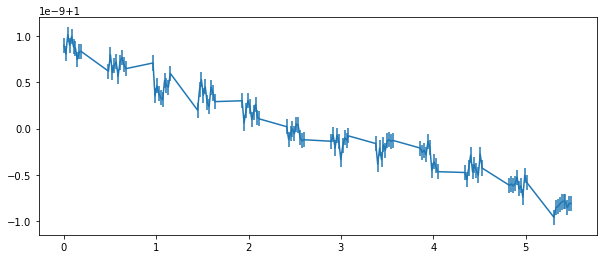

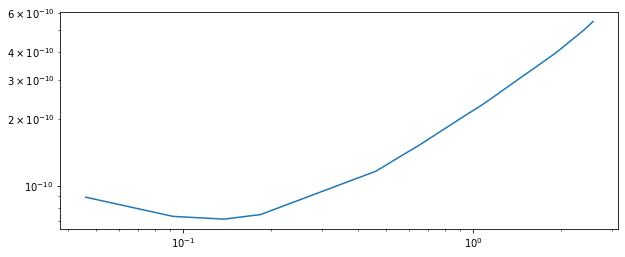

drift per minute/hour -2.9835855064090077e-10


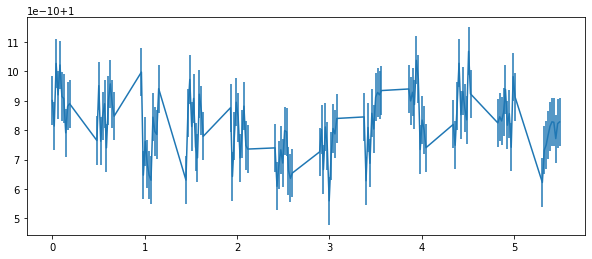

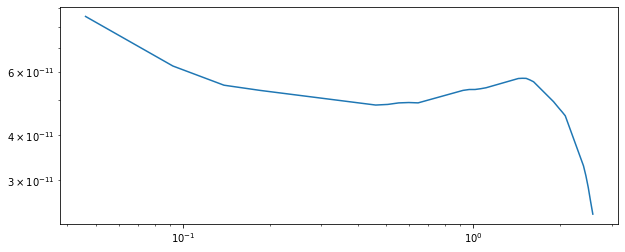

[0.             0.020555555556 0.041388888889 0.062222222222
 0.082777777778 0.103611111111 0.124444444444 0.145277777778
 0.165833333333 0.186666666667 0.482222222222 0.503055555556
 0.523888888889 0.544722222222 0.565555555556 0.586111111111
 0.606944444444 0.627777777778 0.648611111111 0.669166666667
 0.965          0.985833333333 1.006388888889 1.027222222222
 1.048055555556 1.068611111111 1.089444444444 1.110277777778
 1.130833333333 1.151666666667 1.4475         1.468055555556
 1.488888888889 1.509722222222 1.530277777778 1.551111111111
 1.571944444444 1.592777777778 1.613333333333 1.634166666667
 1.93           1.950555555556 1.971388888889 1.992222222222
 2.013055555556 2.033611111111 2.054444444444 2.075277777778
 2.095833333333 2.116666666667 2.412222222222 2.433055555556
 2.453888888889 2.474722222222 2.495277777778 2.516111111111
 2.536944444444 2.5575         2.578333333333 2.599166666667
 2.894722222222 2.915555555556 2.936111111111 2.956944444444
 2.977777777778 2.998611

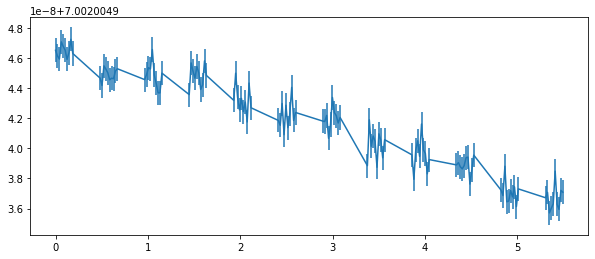

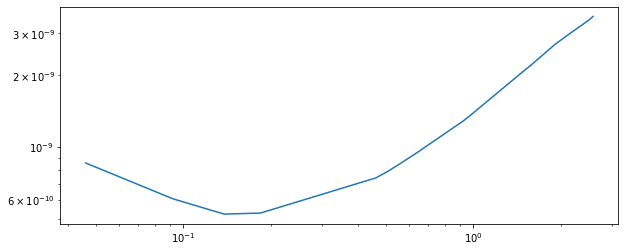

drift per hour -1.8451098330144607e-09


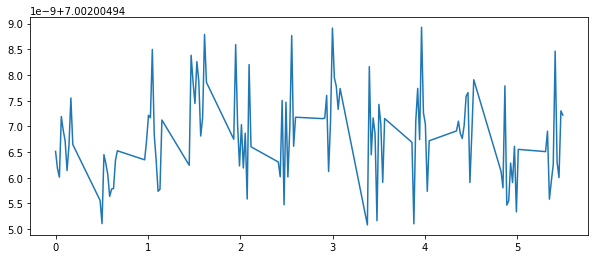

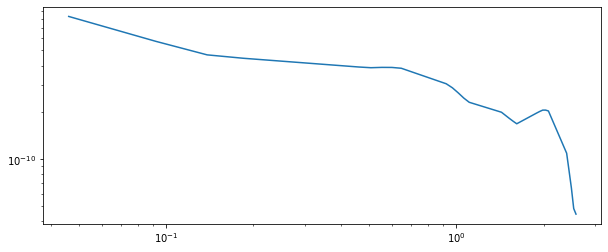

[1.000000000682 1.000000000629 1.000000000599 1.000000000763
 1.000000000719 1.000000000684 1.000000000596 1.00000000066
 1.000000000787 1.000000000652 1.000000000419 1.000000000348
 1.000000000535 1.000000000504 1.000000000469 1.000000000402
 1.000000000417 1.000000000413 1.000000000486 1.000000000507
 1.000000000404 1.000000000453 1.000000000517 1.000000000505
 1.000000000689 1.000000000447 1.00000000037  1.000000000278
 1.000000000279 1.000000000466 1.000000000262 1.000000000563
 1.000000000483 1.000000000417 1.000000000528 1.000000000469
 1.000000000311 1.000000000356 1.000000000582 1.000000000443
 1.000000000207 1.000000000465 1.000000000237 1.000000000117
 1.000000000226 1.0000000001   1.000000000191 1.000000000003
 1.000000000371 1.000000000137 1.000000000017 0.99999999997
 1.000000000177 0.999999999881 1.000000000161 0.999999999948
 1.000000000078 1.00000000033  1.000000000017 1.000000000092
 1.00000000001  1.000000000007 1.000000000064 0.999999999847
 0.999999999979 1.00000000

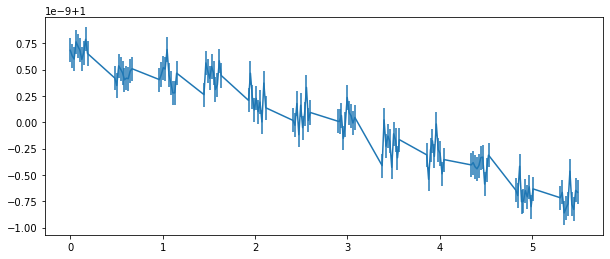

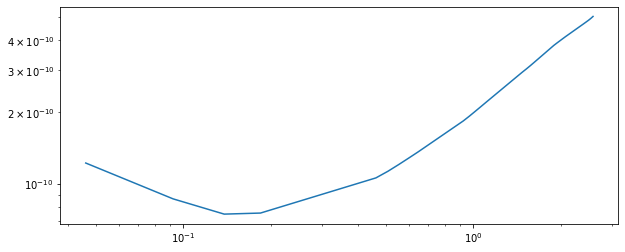

drift per minute/hour -2.6351158025945234e-10


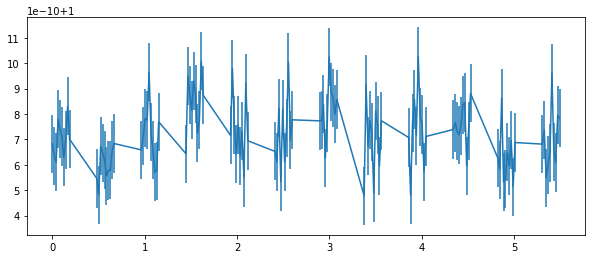

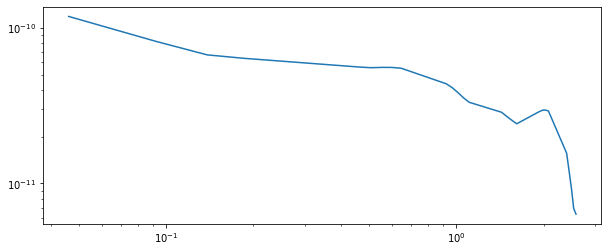

[0.             0.020833333333 0.041388888889 0.062222222222
 0.083055555556 0.103888888889 0.124444444444 0.145277777778
 0.166111111111 0.186944444444 0.4825         0.503333333333
 0.524166666667 0.544722222222 0.565555555556 0.586388888889
 0.607222222222 0.627777777778 0.648611111111 0.669444444444
 0.965          0.985833333333 1.006666666667 1.0275
 1.048055555556 1.068888888889 1.089722222222 1.110277777778
 1.131111111111 1.151944444444 1.4475         1.468333333333
 1.488888888889 1.509722222222 1.530555555556 1.551388888889
 1.572222222222 1.592777777778 1.613611111111 1.634444444444
 1.93           1.950833333333 1.971666666667 1.992222222222
 2.013055555556 2.033888888889 2.054722222222 2.075277777778
 2.096111111111 2.116944444444 2.4125         2.433333333333
 2.453888888889 2.474722222222 2.495555555556 2.516111111111
 2.536944444444 2.557777777778 2.578611111111 2.599166666667
 2.895          2.915555555556 2.936388888889 2.957222222222
 2.977777777778 2.998611111111 3

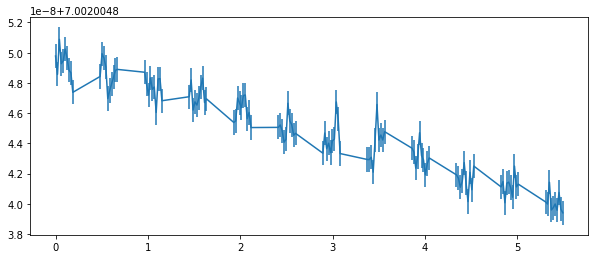

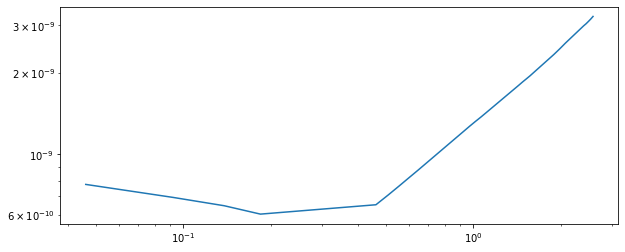

drift per hour -1.7253464149343615e-09


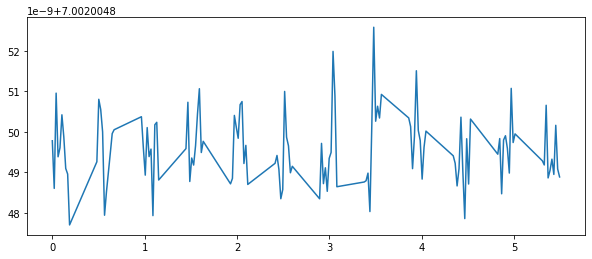

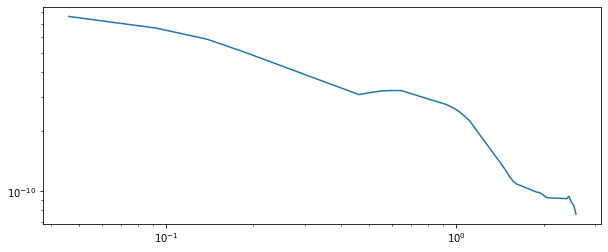

[1.000000000705 1.000000000532 1.000000000863 1.000000000634
 1.00000000066  1.000000000771 1.000000000689 1.000000000572
 1.000000000547 1.000000000363 1.000000000512 1.000000000728
 1.000000000686 1.000000000602 1.000000000303 1.000000000381
 1.000000000444 1.000000000506 1.000000000571 1.000000000579
 1.000000000552 1.000000000438 1.000000000336 1.000000000499
 1.000000000391 1.000000000413 1.000000000173 1.000000000488
 1.000000000492 1.000000000283 1.000000000321 1.000000000479
 1.000000000195 1.000000000273 1.000000000243 1.000000000306
 1.000000000412 1.000000000497 1.000000000266 1.000000000301
 1.000000000078 1.000000000092 1.000000000309 1.000000000263
 1.000000000218 1.000000000332 1.000000000337 1.000000000114
 1.000000000173 1.00000000003  1.000000000031 1.000000000054
 1.             0.999999999891 0.999999999918 1.000000000259
 1.000000000093 1.000000000057 0.999999999957 0.999999999975
 0.999999999787 0.999999999978 0.999999999831 0.999999999881
 0.999999999793 0.999999

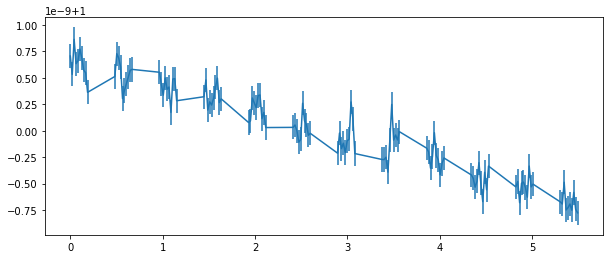

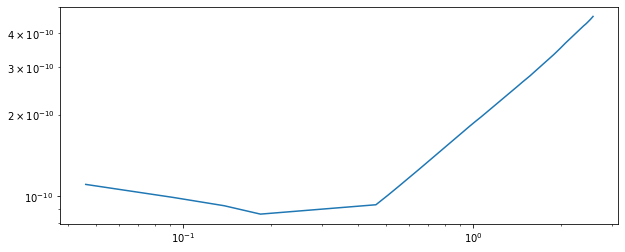

drift per minute/hour -2.4640735531488546e-10


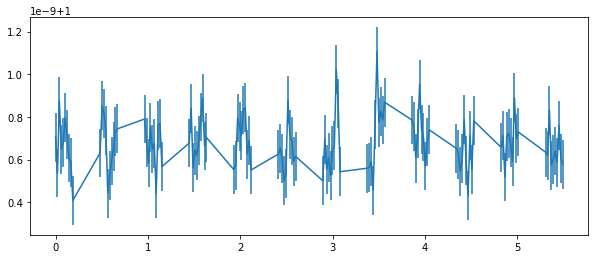

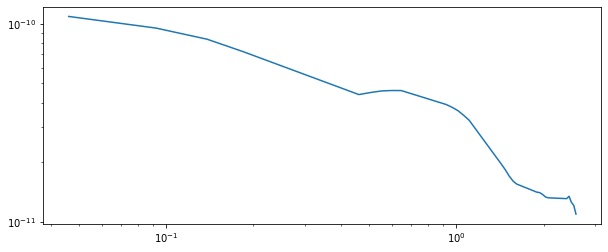

In [99]:
import re
temp_df = step7_results.copy()
for grpname, grp in temp_df.groupby(['trap', 'position']):
    grp['epoch'] = grp.time_p.astype('int64')//1e9
    times = grp.epoch.to_numpy()
    times -= times.min()
    times = times/60 # minutes
    times = times/60 # hours
    print(times)

    ion = grp.ion.unique()[0]
    massu, charge = re.findall(r'\d+', ion)
    mass = int(massu) * 1.66054e-27 # kg / u 
    print('mass', massu, 'u', mass, 'kg')
    grp['B'] = grp['nu_p'] *2*np.pi * mass / (int(charge) * 1.602e-19)
    grp['dB'] = grp['dnu_p'] *2*np.pi * mass / (int(charge) * 1.602e-19)
    print('mean', grp.B.mean())
    bfields = grp.B.to_numpy()
    dbfields = grp.dB.to_numpy()
    plt.errorbar(times, bfields, dbfields)
    plt.show()
    
    visualization.allanvariance(bfields, times, plot=True)
    m,b = np.polyfit(times, bfields, 1)
    print('drift per hour', m)
    bfields_no_drift = bfields - times*m
    plt.plot(times, bfields_no_drift)
    plt.show()
    times = times
    visualization.allanvariance(bfields_no_drift, times, plot=True)

    mean_nup = grp.nu_p.mean()
    nups_rel = grp.nu_p.to_numpy()/mean_nup # ~ normalized
    dnups_rel = grp.dnu_p.to_numpy()/mean_nup # ~ normalized
    #nups_rel *= 7 # times 7 Tesla
    #dnups_rel *= 7 # times 7 Tesla
    
    print(nups_rel)

    plt.errorbar(times, nups_rel, dnups_rel)
    plt.show()
    visualization.allanvariance(nups_rel, times, plot=True)
    m,b = np.polyfit(times, nups_rel, 1)
    print('drift per minute/hour', m)
    bfields_no_drift = nups_rel - times*m
    plt.errorbar(times, bfields_no_drift, dnups_rel)
    plt.show()
    visualization.allanvariance(bfields_no_drift, times, plot=True)

In [96]:
# NOTE: This has to run once after you changed data in the table view!!!

#changed_df = qgrid_widget.get_changed_df()
#if len(changed_df) != len(step7_results):
#    print( " >>> WARNING !!! Remove all filters in the table above and run this again.")
#else:
#    step7_results = changed_df

masked_data = step7_results[ step7_results["masked"]==True ]
display(masked_data)
step7_results.to_csv(results_dir + "step7_first_filter.csv")
step7_results.to_csv(results_dir + "step7_first_filter.txt", sep="\t")

min_nu_c = int(step7_results.nu_c.min())
min_nu_c = 16680543 + 26
min_t = step7_results.epoch_p.min()

step7_results["nu_c_min"] = min_nu_c
step7_results["nu_c_d"] = step7_results["nu_c"] - min_nu_c
step7_results["nu_c_d_mhz"] = step7_results["nu_c_d"] * 1000
step7_results["dnu_c_mhz"] = step7_results["dnu_c"] * 1000
step7_results["seconds"] = step7_results["epoch_p"] - min_t
step7_results["minutes"] = step7_results["seconds"] / 60
step7_results["hours"] = step7_results["minutes"] / 60
print(min_nu_c)
for grpname, grp in step7_results.groupby(["trap", "position"]):
    grp.to_csv(results_dir + "step7_first_filter_t"+str(grpname[0])+"_"+str(grpname[1])+".txt", sep="\t")
    sub = grp[(grp['mcycle']==1) & (grp['cycle']<10)]
    sub.to_csv(results_dir + "step7_first_filter_t"+str(grpname[0])+"_"+str(grpname[1])+"_sc1-10.txt", sep="\t")
    display(sub)

acc_time  average_idx  average_idx_p  cycle  ddip_width  dip_width  \
140   39.9500            0              0      3      0.0115     0.3840   
427   39.9500            0              0      7      0.0989     8.3979   
435   39.9500            0              0      8      0.0007     0.0655   

      dnu_p   dnu_z  dphase_p      fit_err  ...  subcycle  \
140  0.0014  0.0519    0.3427  278054.6567  ...         1   
427  0.0019  0.0505    0.4791       1.2513  ...         8   
435  0.0019  0.0372    0.4791  324445.2658  ...         6   

                          time                     time_p  trap  \
140 2020-07-14 03:10:10.132218 2020-07-14 03:04:33.868681     2   
427 2020-07-14 05:05:57.298795 2020-07-14 05:09:04.081771     3   
435 2020-07-14 05:34:54.457383 2020-07-14 05:35:31.988437     3   

              nu_c   dnu_c        nu_c_sb  dnu_c_sb       ion          epoch_p  
140  16680547.9481  0.0027  16680548.7079    0.0014  187Os29+  1594695873.0000  
427  16680568.4122  0.0024  16680568.3966    0.0019  187Re29+  1594703344.0000  
435  16680568.4102  0.0022  16680568.3962    0.0019  187Re29+  1594704931.0000  

[3 rows x 27 columns]

16680569


acc_time  average_idx  average_idx_p  cycle  ddip_width  dip_width  \
0    39.9500            0              0      1      0.0125     0.4086   
1    39.9500            0              0      1      0.0125     0.4086   
2    39.9500            0              0      1      0.0125     0.4086   
3    39.9500            0              0      1      0.0125     0.4086   
4    39.9500            0              0      1      0.0125     0.4086   
..       ...          ...            ...    ...         ...        ...   
85   39.9500            0              0      9      0.0085     0.3174   
86   39.9500            0              0      9      0.0085     0.3174   
87   39.9500            0              0      9      0.0085     0.3174   
88   39.9500            0              0      9      0.0085     0.3174   
89   39.9500            0              0      9      0.0085     0.3174   

     dnu_p   dnu_z  dphase_p      fit_err  ...  dnu_c_sb       ion  \
0   0.0014  0.0495    0.3427  269217.5815  ...    0.0014  187Re29+   
1   0.0014  0.0495    0.3427  269217.5815  ...    0.0014  187Re29+   
2   0.0014  0.0495    0.3427  269217.5815  ...    0.0014  187Re29+   
3   0.0014  0.0495    0.3427  269217.5815  ...    0.0014  187Re29+   
4   0.0014  0.0495    0.3427  269217.5815  ...    0.0014  187Re29+   
..     ...     ...       ...          ...  ...       ...       ...   
85  0.0014  0.0552    0.3427  270818.8479  ...    0.0014  187Re29+   
86  0.0014  0.0552    0.3427  270818.8479  ...    0.0014  187Re29+   
87  0.0014  0.0552    0.3427  270818.8479  ...    0.0014  187Re29+   
88  0.0014  0.0552    0.3427  270818.8479  ...    0.0014  187Re29+   
89  0.0014  0.0552    0.3427  270818.8479  ...    0.0014  187Re29+   

            epoch_p  nu_c_min   nu_c_d  nu_c_d_mhz dnu_c_mhz     seconds  \
0   1594693268.0000  16680569 -21.2880 -21288.0408    2.5864    869.0000   
1   1594693342.0000  16680569 -21.2860 -21285.9708    2.5864    943.0000   
2   1594693417.0000  16680569 -21.2824 -21282.4068    2.5864   1018.0000   
3   1594693492.0000  16680569 -21.2840 -21283.9640    2.5864   1093.0000   
4   1594693566.0000  16680569 -21.2877 -21287.6778    2.5864   1167.0000   
..              ...       ...      ...         ...       ...         ...   
85  1594707537.0000  16680569 -21.3023 -21302.2957    2.8043  15138.0000   
86  1594707611.0000  16680569 -21.3006 -21300.5935    2.8043  15212.0000   
87  1594707686.0000  16680569 -21.3052 -21305.2427    2.8043  15287.0000   
88  1594707761.0000  16680569 -21.3046 -21304.5645    2.8043  15362.0000   
89  1594707836.0000  16680569 -21.3019 -21301.8615    2.8043  15437.0000   

     minutes   hours  
0    14.4833  0.2414  
1    15.7167  0.2619  
2    16.9667  0.2828  
3    18.2167  0.3036  
4    19.4500  0.3242  
..       ...     ...  
85  252.3000  4.2050  
86  253.5333  4.2256  
87  254.7833  4.2464  
88  256.0333  4.2672  
89  257.2833  4.2881  

[90 rows x 34 columns]

acc_time  average_idx  average_idx_p  cycle  ddip_width  dip_width  \
120   39.9500            0              0      1      0.0084     0.3123   
121   39.9500            0              0      1      0.0084     0.3123   
122   39.9500            0              0      1      0.0084     0.3123   
123   39.9500            0              0      1      0.0084     0.3123   
124   39.9500            0              0      1      0.0084     0.3123   
..        ...          ...            ...    ...         ...        ...   
205   39.9500            0              0      9      0.0106     0.3700   
206   39.9500            0              0      9      0.0106     0.3700   
207   39.9500            0              0      9      0.0106     0.3700   
208   39.9500            0              0      9      0.0106     0.3700   
209   39.9500            0              0      9      0.0106     0.3700   

      dnu_p   dnu_z  dphase_p      fit_err  ...  dnu_c_sb       ion  \
120  0.0014  0.0571    0.3427  269618.1216  ...    0.0014  187Os29+   
121  0.0014  0.0571    0.3427  269618.1216  ...    0.0014  187Os29+   
122  0.0014  0.0571    0.3427  269618.1216  ...    0.0014  187Os29+   
123  0.0014  0.0571    0.3427  269618.1216  ...    0.0014  187Os29+   
124  0.0014  0.0571    0.3427  269618.1216  ...    0.0014  187Os29+   
..      ...     ...       ...          ...  ...       ...       ...   
205  0.0014  0.0491    0.3427  260919.5977  ...    0.0014  187Os29+   
206  0.0014  0.0491    0.3427  260919.5977  ...    0.0014  187Os29+   
207  0.0014  0.0491    0.3427  260919.5977  ...    0.0014  187Os29+   
208  0.0014  0.0491    0.3427  260919.5977  ...    0.0014  187Os29+   
209  0.0014  0.0491    0.3427  260919.5977  ...    0.0014  187Os29+   

             epoch_p  nu_c_min   nu_c_d  nu_c_d_mhz dnu_c_mhz     seconds  \
120  1594692399.0000  16680569 -21.0510 -21050.9619    2.8788      0.0000   
121  1594692474.0000  16680569 -21.0525 -21052.5082    2.8788     75.0000   
122  1594692548.0000  16680569 -21.0491 -21049.0687    2.8788    149.0000   
123  1594692623.0000  16680569 -21.0510 -21050.9504    2.8788    224.0000   
124  1594692698.0000  16680569 -21.0494 -21049.3624    2.8788    299.0000   
..               ...       ...      ...         ...       ...         ...   
205  1594706668.0000  16680569 -21.0685 -21068.4967    2.5711  14269.0000   
206  1594706743.0000  16680569 -21.0726 -21072.6015    2.5711  14344.0000   
207  1594706818.0000  16680569 -21.0710 -21071.0427    2.5711  14419.0000   
208  1594706892.0000  16680569 -21.0717 -21071.6827    2.5711  14493.0000   
209  1594706967.0000  16680569 -21.0728 -21072.8086    2.5711  14568.0000   

      minutes   hours  
120    0.0000  0.0000  
121    1.2500  0.0208  
122    2.4833  0.0414  
123    3.7333  0.0622  
124    4.9833  0.0831  
..        ...     ...  
205  237.8167  3.9636  
206  239.0667  3.9844  
207  240.3167  4.0053  
208  241.5500  4.0258  
209  242.8000  4.0467  

[90 rows x 34 columns]

acc_time  average_idx  average_idx_p  cycle  ddip_width  dip_width  \
240   39.9500            0              0      1      0.0007     0.0681   
241   39.9500            0              0      1      0.0007     0.0681   
242   39.9500            0              0      1      0.0007     0.0681   
243   39.9500            0              0      1      0.0007     0.0681   
244   39.9500            0              0      1      0.0007     0.0681   
..        ...          ...            ...    ...         ...        ...   
325   39.9500            0              0      9      0.1088     9.1158   
326   39.9500            0              0      9      0.1088     9.1158   
327   39.9500            0              0      9      0.1088     9.1158   
328   39.9500            0              0      9      0.1088     9.1158   
329   39.9500            0              0      9      0.1088     9.1158   

      dnu_p   dnu_z  dphase_p      fit_err  ...  dnu_c_sb       ion  \
240  0.0019  0.0358    0.4791  325658.6031  ...    0.0019  187Os29+   
241  0.0019  0.0358    0.4791  325658.6031  ...    0.0019  187Os29+   
242  0.0019  0.0358    0.4791  325658.6031  ...    0.0019  187Os29+   
243  0.0019  0.0358    0.4791  325658.6031  ...    0.0019  187Os29+   
244  0.0019  0.0358    0.4791  325658.6031  ...    0.0019  187Os29+   
..      ...     ...       ...          ...  ...       ...       ...   
325  0.0019  0.0575    0.4791       1.4530  ...    0.0019  187Os29+   
326  0.0019  0.0575    0.4791       1.4530  ...    0.0019  187Os29+   
327  0.0019  0.0575    0.4791       1.4530  ...    0.0019  187Os29+   
328  0.0019  0.0575    0.4791       1.4530  ...    0.0019  187Os29+   
329  0.0019  0.0575    0.4791       1.4530  ...    0.0019  187Os29+   

             epoch_p  nu_c_min  nu_c_d  nu_c_d_mhz dnu_c_mhz     seconds  \
240  1594693268.0000  16680569 -0.3489   -348.9302    2.1941    869.0000   
241  1594693342.0000  16680569 -0.3498   -349.8127    2.1941    943.0000   
242  1594693417.0000  16680569 -0.3503   -350.3067    2.1941   1018.0000   
243  1594693492.0000  16680569 -0.3476   -347.5879    2.1941   1093.0000   
244  1594693566.0000  16680569 -0.3483   -348.3068    2.1941   1167.0000   
..               ...       ...     ...         ...       ...         ...   
325  1594707537.0000  16680569 -0.3628   -362.8433    2.5808  15138.0000   
326  1594707611.0000  16680569 -0.3669   -366.9071    2.5808  15212.0000   
327  1594707686.0000  16680569 -0.3675   -367.5048    2.5808  15287.0000   
328  1594707761.0000  16680569 -0.3707   -370.7207    2.5808  15362.0000   
329  1594707836.0000  16680569 -0.3685   -368.4705    2.5808  15437.0000   

      minutes   hours  
240   14.4833  0.2414  
241   15.7167  0.2619  
242   16.9667  0.2828  
243   18.2167  0.3036  
244   19.4500  0.3242  
..        ...     ...  
325  252.3000  4.2050  
326  253.5333  4.2256  
327  254.7833  4.2464  
328  256.0333  4.2672  
329  257.2833  4.2881  

[90 rows x 34 columns]

acc_time  average_idx  average_idx_p  cycle  ddip_width  dip_width  \
360   39.9500            0              0      1      0.0007     0.0669   
361   39.9500            0              0      1      0.0007     0.0669   
362   39.9500            0              0      1      0.0007     0.0669   
363   39.9500            0              0      1      0.0007     0.0669   
364   39.9500            0              0      1      0.0007     0.0669   
..        ...          ...            ...    ...         ...        ...   
445   39.9500            0              0      9      0.1044     8.9702   
446   39.9500            0              0      9      0.1044     8.9702   
447   39.9500            0              0      9      0.1044     8.9702   
448   39.9500            0              0      9      0.1044     8.9702   
449   39.9500            0              0      9      0.1044     8.9702   

      dnu_p   dnu_z  dphase_p      fit_err  ...  dnu_c_sb       ion  \
360  0.0019  0.0363    0.4791  323359.1411  ...    0.0019  187Re29+   
361  0.0019  0.0363    0.4791  323359.1411  ...    0.0019  187Re29+   
362  0.0019  0.0363    0.4791  323359.1411  ...    0.0019  187Re29+   
363  0.0019  0.0363    0.4791  323359.1411  ...    0.0019  187Re29+   
364  0.0019  0.0363    0.4791  323359.1411  ...    0.0019  187Re29+   
..      ...     ...       ...          ...  ...       ...       ...   
445  0.0019  0.0539    0.4791       1.3466  ...    0.0019  187Re29+   
446  0.0019  0.0539    0.4791       1.3466  ...    0.0019  187Re29+   
447  0.0019  0.0539    0.4791       1.3466  ...    0.0019  187Re29+   
448  0.0019  0.0539    0.4791       1.3466  ...    0.0019  187Re29+   
449  0.0019  0.0539    0.4791       1.3466  ...    0.0019  187Re29+   

             epoch_p  nu_c_min  nu_c_d  nu_c_d_mhz dnu_c_mhz     seconds  \
360  1594692399.0000  16680569 -0.5802   -580.2378    2.2013      0.0000   
361  1594692474.0000  16680569 -0.5831   -583.1225    2.2013     75.0000   
362  1594692548.0000  16680569 -0.5776   -577.6087    2.2013    149.0000   
363  1594692623.0000  16680569 -0.5814   -581.4349    2.2013    224.0000   
364  1594692698.0000  16680569 -0.5810   -580.9920    2.2013    299.0000   
..               ...       ...     ...         ...       ...         ...   
445  1594706668.0000  16680569 -0.5981   -598.0904    2.5086  14269.0000   
446  1594706743.0000  16680569 -0.5988   -598.7679    2.5086  14344.0000   
447  1594706818.0000  16680569 -0.6011   -601.1214    2.5086  14419.0000   
448  1594706892.0000  16680569 -0.5993   -599.3370    2.5086  14493.0000   
449  1594706967.0000  16680569 -0.5985   -598.4712    2.5086  14568.0000   

      minutes   hours  
360    0.0000  0.0000  
361    1.2500  0.0208  
362    2.4833  0.0414  
363    3.7333  0.0622  
364    4.9833  0.0831  
..        ...     ...  
445  237.8167  3.9636  
446  239.0667  3.9844  
447  240.3167  4.0053  
448  241.5500  4.0258  
449  242.8000  4.0467  

[90 rows x 34 columns]

## NOW RATIO DETERMINATIONS!!!

#### FIRST: TRAP-WISE ANALYSIS

A: Naive

B: Interpolation

C: Polynomial

### Step 8: Naive ratio, assuming stable magnetic field, traps are analysed one by one
This means I analyse each trap by its own and just calculate a ratio by R = nu_c_ion1(t1) / nu_c_ion2(t2). This would assume that the field does not change between measurements. This is done by LIONTRAP, but they have a measurement scheme with minimal difference between two cyclotron measurements (about 200s ?), so as less magnetic field change as possible. Even for us (15 minutes between measurements) this is actually pretty good, because our field is pretty stable.

In [19]:
step8_data = step7_results.copy()
step8_naive_results = pd.DataFrame()
step8_naive_results_bc = pd.DataFrame()
step8_data.sort_values(["mcycle", "trap", "time_p"], inplace=True)

# now want to average?
average = False # if you average here, the filter steps are basically missing
average = settings.get("average", True)

#if average:
#    new_df = pd.DataFrame()
#    for grpname, grpphase in step8_data.groupby(["mcycle", "trap", "cycle", "position"]):
#        avg = statistics.average_subsets(grpphase, groupby=["average_idx_p"], errortype="weighted",
#                                              columns=["nu_c", "phase_p", "nu_p", "nu_z", "time_p"], 
#                                              dcolumns=["dnu_c", "dphase_p", "dnu_p", "dnu_z", None],
#                                              masked=True)
#        new_df = new_df.append(avg)
#    step8_data = new_df

invert = settings.get("invert", False)
for name, grp in step8_data.groupby(["mcycle", "trap"]):
    print("mcycle, trap:", name, "positions", grp.position.unique(), "subcycles", grp.subcycle.unique())
    grp.sort_values(["time_p"], inplace=True)
    
    if not invert:
        positions = grp.position.unique()[::-1] 
    else:
        positions = grp.position.unique()

    grp_bc = grp.copy()
    grp_bc.loc[grp_bc.position != start_position, ['cycle']] += 1

    if average:
        results = ratio_analysis.calc_ratios(grp, y=['nu_c'], yerr=['dnu_c'], groupbys=['cycle', 'average_idx_p'], identifier="position", ident_types=positions,
                keep_columns=['mcycle', 'trap', 'subcycle'], 
                additional_identifiers=['ion', 'time_p', 'time', "nu_c", "phase_p", "nu_p", "nu_z", "dnu_c", "dphase_p", "dnu_p", "dnu_z"], mean_columns=["time_p"])
        bc_results = ratio_analysis.calc_ratios(grp_bc, y=['nu_c'], yerr=['dnu_c'], groupbys=['cycle'], identifier="position", ident_types=positions,
                keep_columns=['mcycle', 'trap', 'subcycle'], additional_identifiers=['ion', 'time_p', 'time'], mean_columns=["time_p"])
    else:
        results = ratio_analysis.calc_ratios(grp, y=['nu_c'], yerr=['dnu_c'], groupbys=['cycle', 'subcycle'], identifier="position", ident_types=positions,
                keep_columns=['mcycle', 'trap'], additional_identifiers=['ion', 'time_p', 'time'], mean_columns=["time_p"])
        bc_results = ratio_analysis.calc_ratios(grp_bc, y=['nu_c'], yerr=['dnu_c'], groupbys=['cycle', 'subcycle'], identifier="position", ident_types=positions,
                keep_columns=['mcycle', 'trap'], additional_identifiers=['ion', 'time_p', 'time'], mean_columns=["time_p"])
        
    step8_naive_results = step8_naive_results.append(results, ignore_index=True)
    step8_naive_results_bc = step8_naive_results_bc.append(bc_results, ignore_index=True)
    
    if len(traps)!=1:
        invert = not invert


mcycle, trap: (1, 2) positions ['position_2' 'position_1'] subcycles [1 2]
not enough data in this group ['cycle'] 1
not enough data in this group ['cycle'] 13
mcycle, trap: (1, 3) positions ['position_2' 'position_1'] subcycles [1]
not enough data in this group ['cycle'] 1
not enough data in this group ['cycle'] 13


In [20]:
pd.options.display.float_format = '{: .12f}'.format
step8_naive_results = data_conversion.fix_column_dtypes(step8_naive_results)
step8_naive_results_bc = data_conversion.fix_column_dtypes(step8_naive_results_bc)
display(step8_naive_results)
display(step8_naive_results_bc)
#display(step8_naive_results["ion_numer"].unique())

step8_naive_results["R"] = step8_naive_results["ratio_nu_c"]
step8_naive_results["dR"] = step8_naive_results["dratio_nu_c"]
step8_naive_results_bc["R"] = step8_naive_results_bc["ratio_nu_c"]
step8_naive_results_bc["dR"] = step8_naive_results_bc["dratio_nu_c"]
step8_naive_results["Rminus"] = step8_naive_results["R"] - 1.0
step8_naive_results_bc["Rminus"] = step8_naive_results_bc["R"] - 1.0
step8_naive_results_merged = statistics.merge_odd_even_results(step8_naive_results, step8_naive_results_bc)
step8_naive_results_merged["Rminus"] = step8_naive_results_merged["R"] - 1.0

step8_naive_results.to_csv(results_dir + "step8_naive_results.csv")
step8_naive_results.to_csv(results_dir + "step8_naive_results.txt", sep="\t")
step8_naive_results_bc.to_csv(results_dir + "step8_naive_results_bc.csv")
step8_naive_results_bc.to_csv(results_dir + "step8_naive_results_bc.txt", sep="\t")
step8_naive_results_merged.to_csv(results_dir + "step8_naive_results_merged.csv")
step8_naive_results_merged.to_csv(results_dir + "step8_naive_results_merged.txt", sep="\t")

fig = px.line(step8_naive_results, x="time_p", y="Rminus", error_y="dratio_nu_c", color='trap', hover_data=['mcycle', 'cycle'])
fig.show()
fig = px.line(step8_naive_results_bc, x="time_p", y="Rminus", error_y="dratio_nu_c", color='trap', hover_data=['mcycle', 'cycle'])
fig.show()
fig = px.line(step8_naive_results_merged, x="time_p", y="Rminus", error_y="dratio_nu_c", color='trap', hover_data=['mcycle', 'cycle'])
fig.show()

mcycle  trap  subcycle  cycle  average_idx_p      ratio_nu_c  \
0        1     2         1      1              0  0.999999985949   
1        1     2         1      2              0  0.999999986091   
2        1     2         2      3              0  0.999999985898   
3        1     2         1      4              0  0.999999986023   
4        1     2         1      5              0  0.999999986153   
5        1     2         1      6              0  0.999999986094   
6        1     2         1      7              0  0.999999985958   
7        1     2         1      8              0  0.999999986065   
8        1     2         1      9              0  0.999999985979   
9        1     2         1     10              0  0.999999986076   
10       1     2         1     11              0  0.999999986070   
11       1     2         1     12              0  0.999999986039   
12       1     3         1      1              0  0.999999986066   
13       1     3         1      2              0  0.999999986256   
14       1     3         1      3              0  0.999999985981   
15       1     3         1      4              0  0.999999985975   
16       1     3         1      5              0  0.999999986139   
17       1     3         1      6              0  0.999999986203   
18       1     3         1      7              0  0.999999986022   
19       1     3         1      8              0  0.999999986200   
20       1     3         1      9              0  0.999999986170   
21       1     3         1     10              0  0.999999986211   
22       1     3         1     11              0  0.999999986043   
23       1     3         1     12              0  0.999999986292   

       dratio_nu_c position_numer position_denom ion_numer  ...  \
0   0.000000000076     position_1     position_2  187Re29+  ...   
1   0.000000000071     position_1     position_2  187Re29+  ...   
2   0.000000000076     position_1     position_2  187Re29+  ...   
3   0.000000000074     position_1     position_2  187Re29+  ...   
4   0.000000000068     position_1     position_2  187Re29+  ...   
5   0.000000000073     position_1     position_2  187Re29+  ...   
6   0.000000000068     position_1     position_2  187Re29+  ...   
7   0.000000000073     position_1     position_2  187Re29+  ...   
8   0.000000000079     position_1     position_2  187Re29+  ...   
9   0.000000000076     position_1     position_2  187Re29+  ...   
10  0.000000000071     position_1     position_2  187Re29+  ...   
11  0.000000000068     position_1     position_2  187Re29+  ...   
12  0.000000000064     position_2     position_1  187Re29+  ...   
13  0.000000000060     position_2     position_1  187Re29+  ...   
14  0.000000000061     position_2     position_1  187Re29+  ...   
15  0.000000000061     position_2     position_1  187Re29+  ...   
16  0.000000000067     position_2     position_1  187Re29+  ...   
17  0.000000000065     position_2     position_1  187Re29+  ...   
18  0.000000000071     position_2     position_1  187Re29+  ...   
19  0.000000000072     position_2     position_1  187Re29+  ...   
20  0.000000000074     position_2     position_1  187Re29+  ...   
21  0.000000000058     position_2     position_1  187Re29+  ...   
22  0.000000000056     position_2     position_1  187Re29+  ...   
23  0.000000000061     position_2     position_1  187Re29+  ...   

             nu_z_denom     dnu_c_numer     dnu_c_denom  dphase_p_numer  \
0   740300.589860591223  0.000874423544  0.000910345370  0.133352130307   
1   740300.595827293815  0.000851098635  0.000829857155  0.108357999765   
2   740300.640833807644  0.000799036862  0.000989066837  0.108357999765   
3   740300.557496695430  0.000850421642  0.000888890705  0.108357999765   
4   740300.576855992666  0.000837129642  0.000776953913  0.108357999765   
5   740300.619911580230  0.000860865571  0.000857400133  0.113989686047   
6   740300.638008941663  0.000843669941  0.000752372568  0.108357999765   
7   740300.588129480020  0.

mcycle  trap  subcycle  cycle      ratio_nu_c     dratio_nu_c  \
0        1     2         1      2  0.999999986128  0.000000000072   
1        1     2         1      3  0.999999986224  0.000000000078   
2        1     2         1      4  0.999999986189  0.000000000072   
3        1     2         1      5  0.999999986145  0.000000000069   
4        1     2         1      6  0.999999986271  0.000000000072   
5        1     2         1      7  0.999999986144  0.000000000069   
6        1     2         1      8  0.999999986148  0.000000000072   
7        1     2         1      9  0.999999986104  0.000000000075   
8        1     2         1     10  0.999999986190  0.000000000077   
9        1     2         1     11  0.999999986256  0.000000000074   
10       1     2         1     12  0.999999986101  0.000000000070   
11       1     3         1      2  0.999999985923  0.000000000062   
12       1     3         1      3  0.999999986113  0.000000000059   
13       1     3         1      4  0.999999985858  0.000000000060   
14       1     3         1      5  0.999999985848  0.000000000063   
15       1     3         1      6  0.999999986076  0.000000000063   
16       1     3         1      7  0.999999986074  0.000000000076   
17       1     3         1      8  0.999999985837  0.000000000067   
18       1     3         1      9  0.999999986102  0.000000000068   
19       1     3         1     10  0.999999986142  0.000000000070   
20       1     3         1     11  0.999999985971  0.000000000057   
21       1     3         1     12  0.999999986046  0.000000000055   

   position_numer position_denom ion_numer ion_denom  \
0      position_1     position_2  187Re29+  187Os29+   
1      position_1     position_2  187Re29+  187Os29+   
2      position_1     position_2  187Re29+  187Os29+   
3      position_1     position_2  187Re29+  187Os29+   
4      position_1     position_2  187Re29+  187Os29+   
5      position_1     position_2  187Re29+  187Os29+   
6      position_1     position_2  187Re29+  187Os29+   
7      position_1     position_2  187Re29+  187Os29+   
8      position_1     position_2  187Re29+  187Os29+   
9      position_1     position_2  187Re29+  187Os29+   
10     position_1     position_2  187Re29+  187Os29+   
11     position_2     position_1  187Re29+  187Os29+   
12     position_2     position_1  187Re29+  187Os29+   
13     position_2     position_1  187Re29+  187Os29+   
14     position_2     position_1  187Re29+  187Os29+   
15     position_2     position_1  187Re29+  187Os29+   
16     position_2     position_1  187Re29+  187Os29+   
17     position_2     position_1  187Re29+  187Os29+   
18     position_2     position_1  187Re29+  187Os29+   
19     position_2     position_1  187Re29+  187Os29+   
20     position_2     position_1  187Re29+  187Os29+   
21     position_2     position_1  187Re29+  187Os29+   

                    time_p_numer            time_p_denom  \
0  2020-07-14 02:26:43.800000000 2020-07-14 02:41:12.500   
1  2020-07-14 02:55:40.900000000 2020-07-14 03:10:47.000   
2  2020-07-14 03:24:38.000000000 2020-07-14 03:39:06.400   
3  2020-07-14 03:53:34.800000000 2020-07-14 04:08:03.500   
4  2020-07-14 04:22:31.900000000 2020-07-14 04:37:00.100   
5  2020-07-14 04:51:28.600000000 2020-07-14 05:05:56.800   
6  2020-07-14 05:20:25.400000000 2020-07-14 05:34:54.000   
7  2020-07-14 05:49:22.300000000 2020-07-14 06:03:50.800   
8  2020-07-14 06:18:19.300000000 2020-07-14 06:32:47.900   
9  2020-07-14 06:47:16.300000000 2020-07-14 07:01:44.600   
10 2020-07-14 07:16:13.200000000 2020-07-14 07:30:40.900   
11 2020-07-14 02:41:12.500000000 2020-07-14 02:26:43.800   
12 2020-07-14 03:10:09.600000000 2020-07-14 02:55:40.900   
13 2020-07-14 03:39:06.400000000 2020-07-14 03:24:38.000   
14 2020-07-14 04:08:03.500000000 2020-07-14 03:53:34.800   
15 2020-07-14 04:37:00.100000000 2020-07-14 04:22:31.900   
16 2020-07-14 05:05:56.800000000 2020-07-14 04:51:28.600   
17 2020-07-14 05:34:49.888888832 2020-07-14 05:

lost 3 len(odd/even/merged) 12 11 10
lost 1 len(odd/even/merged) 12 11 11


analysis type 	R-1     	err_in   	err_out   	chi2red   	(out/in) 	1+(0.477/sqrt(N))	# of R    	mean single err	R std	
naive merged 	0.0000000139162	0.0000000000150	0.0000000000159	1.1339406566960	1.0648664971235	1.1040899336426		21		0.0000000000694	0.0000000000682	
naive all    	0.0000000139117	0.0000000000138	0.0000000000216	2.4577215170509	1.5677121920336	1.0973672172756		24		0.0000000000685	0.0000000001012	
naive bc all 	0.0000000139289	0.0000000000143	0.0000000000271	3.5720770658282	1.8899939327490	1.1016967417016		22		0.0000000000683	0.0000000001231	
naive t2     	0.0000000139644	0.0000000000209	0.0000000000212	1.0249545088224	1.0124003698253	1.1376980392017		12		0.0000000000728	0.0000000000705	
naive bc t2  	0.0000000138289	0.0000000000219	0.0000000000175	0.6401740208776	0.8001087556561	1.1438209113636		11		0.0000000000728	0.0000000000556	
naive t3     	0.0000000138713	0.0000000000183	0.0000000000323	3.0966886038059	1.7597410615786	1.1376980392017		12		0.0000000000642	0.000000000

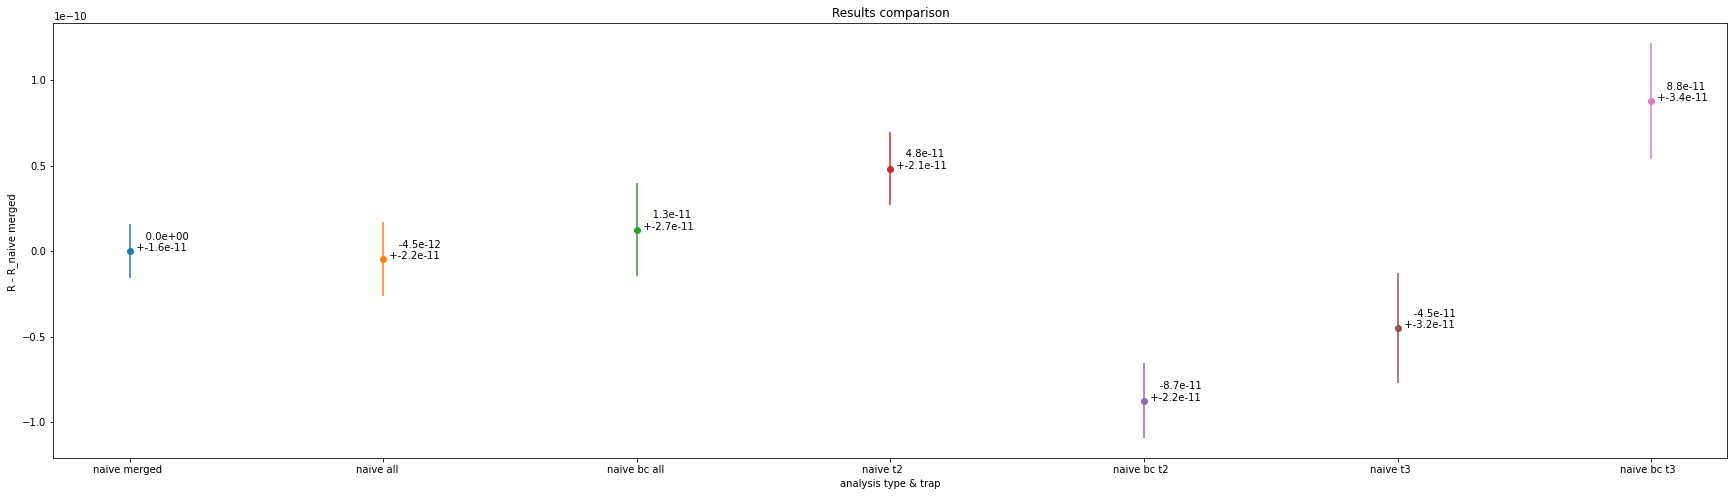

mcycle          Rminus              dR                  time_p trap  \
0        1 -0.000000013890  0.000000000072 2020-07-14 02:48:26.000    2   
1        1 -0.000000013894  0.000000000074 2020-07-14 03:46:20.000    2   
2        1 -0.000000013851  0.000000000069 2020-07-14 04:15:17.000    2   
3        1 -0.000000013817  0.000000000073 2020-07-14 04:44:14.000    2   
4        1 -0.000000013949  0.000000000069 2020-07-14 05:13:10.500    2   
..     ...             ...             ...                     ...  ...   
108      1 -0.000000014163  0.000000000067 2020-07-14 05:27:37.000    3   
109      1 -0.000000013898  0.000000000068 2020-07-14 05:56:36.000    3   
110      1 -0.000000013858  0.000000000070 2020-07-14 06:25:33.000    3   
111      1 -0.000000014029  0.000000000057 2020-07-14 06:54:30.000    3   
112      1 -0.000000013954  0.000000000055 2020-07-14 07:23:26.500    3   

          analysis  
0    naive merged   
1    naive merged   
2    naive merged   
3    naive merged   
4    naive merged   
..             ...  
108  naive bc t3    
109  naive bc t3    
110  naive bc t3    
111  naive bc t3    
112  naive bc t3    

[113 rows x 6 columns]

In [21]:
results = {
    "naive merged ": step8_naive_results_merged,
    "naive all    ": step8_naive_results,
    "naive bc all ": step8_naive_results_bc,
    "naive t2     ": step8_naive_results[step8_naive_results["trap"]==2],
    "naive bc t2  ": step8_naive_results_bc[step8_naive_results_bc["trap"]==2],
    "naive t3     ": step8_naive_results[step8_naive_results["trap"]==3],
    "naive bc t3  ": step8_naive_results_bc[step8_naive_results_bc["trap"]==3],
}

visualization.compare(results)

### Step 9: Interpolation
Data of two cycles of one position is interpolated to the time of the measurement of the in between position. Then the ratio is calculated.

In [22]:
# For the interpolation we have to use averaged data. 
step9_data = pd.DataFrame()

if not settings["averaging"]:
    for grpname, grpdata in step7_results.groupby(["mcycle", "trap", "position"]):
        print("mcycle, trap, position", grpname)

        avgdata = pd.DataFrame()

        for subname, subgrpdata in grpdata.groupby("cycle"):

            avg = statistics.average_subsets(subgrpdata, groupby=["average_idx"], errortype="weighted",
                                                  columns=["nu_c", "phase_p", "nu_p", "nu_z", "time_p"], 
                                                  dcolumns=["dnu_c", "dphase_p", "dnu_p", "dnu_z", None],
                                                  masked=True)
            avgdata = avgdata.append(avg)

        avgdata = data_conversion.fix_column_dtypes(avgdata)

        # filter by min max boundaries for values, default: min_val: 1, max_val: 1e9:
        avgdata = filtering.minmax_value(avgdata, val="nu_z")
        avgdata = filtering.minmax_value(avgdata, val="nu_p")
        avgdata = filtering.minmax_value(avgdata, val="nu_c")

        # apply autofilter 3-sigma condition: calc mean of values and std
        # if value is outside of mean+-3*std, it is masked
        avgdata = filtering.three_sigma(avgdata, val="nu_z", err="dnu_z", undrift_xcolumn="time", show=False)
        avgdata = filtering.three_sigma(avgdata, val="nu_p", err="dnu_p", undrift_xcolumn="time_p", show=False)
        avgdata = filtering.three_sigma(avgdata, val="nu_c", err="dnu_c", undrift_xcolumn="time_p", show=False)
        #display(subset)

        # apply autofilter sigma-size: if sigma of value is 3 time bigger
        # then mean sigma, it is masked
        avgdata = filtering.sigma_size(avgdata, err="dnu_z")
        avgdata = filtering.sigma_size(avgdata, err="dnu_p")
        avgdata = filtering.sigma_size(avgdata, err="dnu_c")

        step9_data = step9_data.append(avgdata)

    print("averaged")
else:
    step9_data = step7_results.copy(deep=True)

step9_data = step9_data.sort_values("time_p")
step9_data.reset_index(drop=True, inplace=True)
step9_interpolated_data = pd.DataFrame()
step9_interpolate_results = pd.DataFrame()
invert = settings.get("invert", True)
for grpname, grpdata in step9_data.groupby(["mcycle", "trap"]):
    print('mcycle, trap', grpname)
    if len(grpdata.index - sum(grpdata.index.to_numpy())) < 6:
        if len(traps)!=1:
            invert = not invert
        continue
        
    # first we try to figure out what non-linearity error we have by interpolating in only one position, so same ion, interpolating odd to even cycles
    # and determine the difference of the interpolated value to the actually measured value. The mean abs differene to the measured values corresponds
    # to a higher order fluctuation. Without any additional information this fluctuation only holds for the time step from one cycle to the next. Anyway,
    # we use it as a fluctuation per second value and then "interpolate" this fluctuation to the time step between two measurements (of different ions)
    # and use this as a non-linear-uncertainty-per-second value for the actual linear interpolation.
    non_linearities_per_second = []
    non_linearities_std_per_second = []
    for pos, posdata in grpdata.groupby("position"):
        posdata["oddity"] = np.where(posdata['cycle'] % 2 != 0, 'odd', 'even') # this is needed for the interpolation function as an identifier
        non_lin_data = ratio_analysis.interpolate(posdata, y=['nu_c'], yerr=['dnu_c'], groupbys=['mcycle', 'trap'], x="time_p",
                    identifier="oddity", id_reference="even", id_interpolate="odd",
                    non_linear_uncertainty_per_second=0)
        interpolated_only = non_lin_data[ non_lin_data['oddity']=='odd']
        #plt.errorbar(interpolated_only.time_p.to_numpy(), interpolated_only.nu_c.to_numpy(), interpolated_only.dnu_c.to_numpy())
        #plt.errorbar(posdata.time_p.to_numpy(), posdata.nu_c.to_numpy(), posdata.dnu_c.to_numpy())
        #plt.show()
        #display(interpolated_only)
        ref_only = posdata[ posdata['oddity']=='even']
        if len(posdata.index)%2==0:
            diff_nu_c = interpolated_only.nu_c.to_numpy() - ref_only.nu_c.to_numpy()[:-1]
            time_diffs = posdata.epoch.to_numpy()[:-1] - posdata.epoch.to_numpy()[1:]
        else:
            diff_nu_c = interpolated_only.nu_c.to_numpy() - ref_only.nu_c.to_numpy()
            time_diffs = posdata.epoch.to_numpy()[:-1] - posdata.epoch.to_numpy()[1:]
        #print(time_diffs, diff_nu_c)
        #plt.errorbar(interpolated_only.time_p.to_numpy(), diff_nu_c, diff_dnu_c)
        #plt.show()
        time_per_cycle = np.mean(time_diffs)
        std_time_diffs = np.std(time_diffs)
        #print(time_per_cycle, std_time_diffs)
        mean_nuc_diff = (np.sqrt(np.sum(diff_nu_c**2))/len(diff_nu_c))
        std_nuc_diff = np.std(diff_nu_c)
        non_linearities_per_second.append( mean_nuc_diff/time_per_cycle )
        non_linearities_std_per_second.append( std_nuc_diff/time_per_cycle )
    non_linear_uncertainty_per_second = np.mean(non_linearities_per_second)
    non_linear_uncertainty_per_second_std = np.mean(non_linearities_std_per_second)
    print("non-linearities", non_linear_uncertainty_per_second*time_per_cycle/2, non_linear_uncertainty_per_second_std*time_per_cycle/2)
    
    reference, interpolate = other_position, start_position # what was measured first in time? Thats the one we want to interpolate
    print(reference, interpolate)
    
    interpolated_data = ratio_analysis.interpolate(grpdata, y=['nu_c'], yerr=['dnu_c'], groupbys=['mcycle', 'trap'], x="time_p",
                    identifier="position", id_reference=reference, id_interpolate=interpolate,
                    non_linear_uncertainty_per_second=non_linear_uncertainty_per_second_std)
    
    #display(interpolated_data.head(10))
    
    step9_interpolated_data = step9_interpolated_data.append(interpolated_data)
    
    if not invert:
        positions = grpdata.position.unique()[::-1] 
    else:
        positions = grpdata.position.unique()
    print(positions)
    
    results = ratio_analysis.calc_ratios(interpolated_data, y=['nu_c'], yerr=['dnu_c'], groupbys=['cycle'], identifier="position", ident_types=positions,
            keep_columns=['mcycle', 'trap'], additional_identifiers=['ion', 'time_p'], mean_columns=['time_p', 'time'])

    step9_interpolate_results = step9_interpolate_results.append(results, ignore_index=True)
    
    if len(traps)!=1:
        invert = not invert


mcycle, trap (1, 2)
non-linearities 0.00024773846812837483 0.0004264934869132326
position_1 position_2
['position_1' 'position_2']
mcycle, trap (1, 3)
non-linearities 0.0003514111467040842 0.0006725417796635865
position_1 position_2
['position_2' 'position_1']


In [23]:
pd.options.display.float_format = '{: .12f}'.format
#step9_interpolate_results = data_conversion.fix_column_dtypes(step9_interpolate_results)
#display(step9_interpolated_data[:5])
#display(step9_interpolate_results[:5])
#display(step8_naive_results["ion_numer"].unique())

step9_interpolate_results["R"] = step9_interpolate_results["ratio_nu_c"]
step9_interpolate_results["dR"] = step9_interpolate_results["dratio_nu_c"]
step9_interpolate_results["Rminus"] = step9_interpolate_results["R"] - 1.0

step9_interpolate_results.to_csv(results_dir + "step9_interpolate_results.csv")
step9_interpolate_results.to_csv(results_dir + "step9_interpolate_results.txt", sep="\t")

fig = px.line(step9_interpolate_results, x="time_p", y="Rminus", error_y="dratio_nu_c", color='trap', hover_data=['mcycle', 'cycle'])
fig.show()

analysis type 	R-1     	err_in   	err_out   	chi2red   	(out/in) 	1+(0.477/sqrt(N))	# of R    	mean single err	R std	
naive merged 	0.0000000139162	0.0000000000150	0.0000000000159	1.1339406566960	1.0648664971235	1.1040899336426		21		0.0000000000694	0.0000000000682	
naive merged2	0.0000000138888	0.0000000000230	0.0000000000148	0.4152299821875	0.6443834124087	1.1508406443900		10		0.0000000000731	0.0000000000447	
naive merged3	0.0000000139362	0.0000000000197	0.0000000000253	1.6491005900887	1.2841731153114	1.1438209113636		11		0.0000000000661	0.0000000000784	
interpolated 	0.0000000139224	0.0000000000145	0.0000000000180	1.5383925120769	1.2403195201547	1.1016967417016		22		0.0000000000684	0.0000000000819	
interpolated2	0.0000000138978	0.0000000000206	0.0000000000169	0.6757459431114	0.8220376774281	1.1438209113636		11		0.0000000000683	0.0000000000530	
interpolated3	0.0000000139468	0.0000000000205	0.0000000000309	2.2711035142810	1.5070180869124	1.1438209113636		11		0.0000000000685	0.000000000

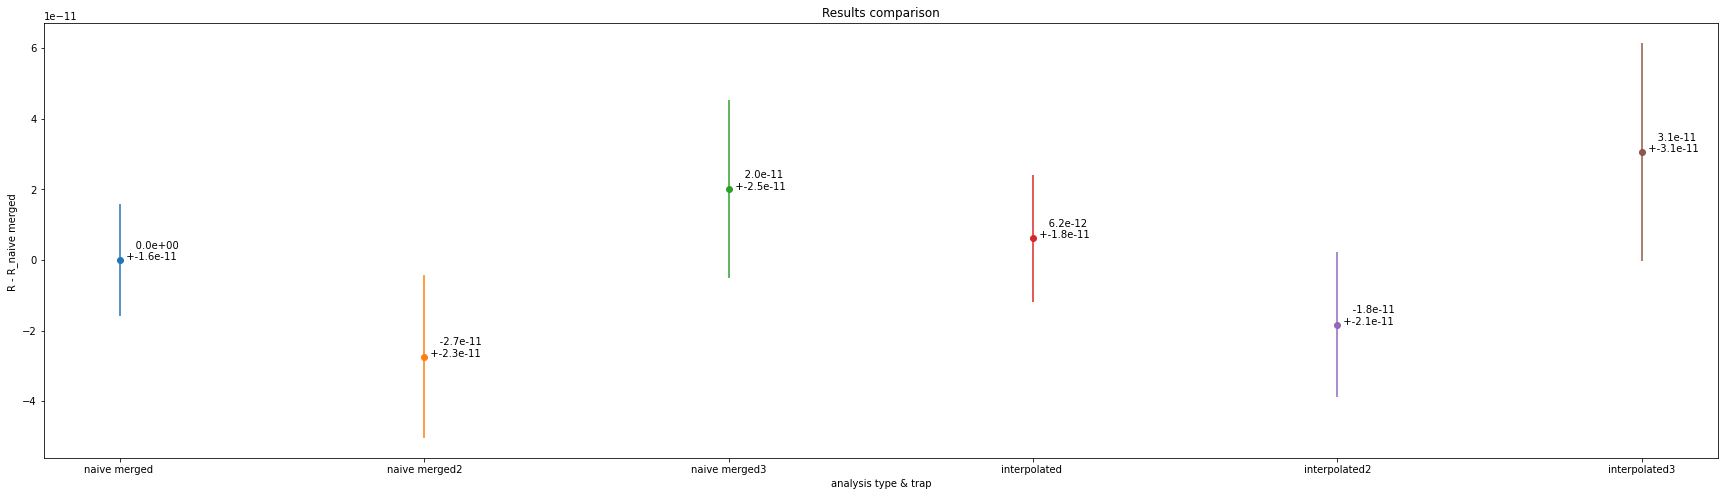

mcycle          Rminus              dR                  time_p trap  \
0       1 -0.000000013890  0.000000000072 2020-07-14 02:48:26.000    2   
1       1 -0.000000013894  0.000000000074 2020-07-14 03:46:20.000    2   
2       1 -0.000000013851  0.000000000069 2020-07-14 04:15:17.000    2   
3       1 -0.000000013817  0.000000000073 2020-07-14 04:44:14.000    2   
4       1 -0.000000013949  0.000000000069 2020-07-14 05:13:10.500    2   
..    ...             ...             ...                     ...  ...   
81      1 -0.000000014071  0.000000000070 2020-07-14 05:20:25.000    3   
82      1 -0.000000013849  0.000000000073 2020-07-14 05:49:22.000    3   
83      1 -0.000000013844  0.000000000077 2020-07-14 06:18:19.000    3   
84      1 -0.000000013909  0.000000000064 2020-07-14 06:47:16.000    3   
85      1 -0.000000013955  0.000000000063 2020-07-14 07:16:13.000    3   

         analysis  
0   naive merged   
1   naive merged   
2   naive merged   
3   naive merged   
4   naive merged   
..            ...  
81  interpolated3  
82  interpolated3  
83  interpolated3  
84  interpolated3  
85  interpolated3  

[86 rows x 6 columns]

In [24]:
one_df = step8_naive_results_merged.copy(deep=True)
one_df["R"] = 1
one_df["dR"] = 1e-11
one_df["Rminus"] = 0

results = {
    #"one          ": one_df,
    "naive merged ": step8_naive_results_merged,
    "naive merged2": step8_naive_results_merged[step8_naive_results_merged['trap']==2],
    "naive merged3": step8_naive_results_merged[step8_naive_results_merged['trap']==3],
    "interpolated ": step9_interpolate_results,
    "interpolated2": step9_interpolate_results[step9_interpolate_results['trap']==2],
    "interpolated3": step9_interpolate_results[step9_interpolate_results['trap']==3],
}

visualization.compare(results)

### Step 10: Polynom-fit ratio determinatioin

The function ```polynom_fit.fit_sharedpoly_ratio``` does everything you need for shared polynomial fits: looping over group sizes, autogrouping, looping over polynom degrees; you can choose between different fit methods and you get all and the already filtered best settings results back; You can use it on single trap data or on trap ratio data for poly-cancel (later). It does either take single trap data or single trap ratio data. Here the docstring of the function for explanation:

In [25]:
print(polynom_fit.fit_sharedpoly_ratio.__doc__)

Performs a shared polynom fit on y data in the pandas table. The data is mixed in the table and identified using a seperate column 
    (data_identifier) for us typically 'position' or in case of the cancellation method 'trap'. The group size and number of degrees of the
    polynom function can be lists to loop over these possible settings. The results will include the fit results of all settings with columns
    identifying the groupsizes, group indexes, number of polynom degree. Also all the polynomial parameters and fit quality estimators will
    be included.

    The structure of the input df should be (at least):
    | idx | keep_columns (e.g. mc, trap, ...) | x (e.g. time) | y (e.g. nu_c) | yerr (e.g. dnu_c) | data_identifier (e.g. position) |

    The structure of the output df will be:
    | idx | keep_columns | groupsize | degree | group | cycle_start | cycle_stop | x | R | dR | chi2 | chi2red | AIC | AICc | BIC | ion_numer | ion_denom | fit_parameter ... |

    Some notes o

If you still want to try your manual grouping, you can use the following cell to pre-group the data with the ```start_size``` and manually modify the grouping inside the plot.

In [26]:
# you might want to do manual grouping
temp_df = pd.DataFrame()
for gname, grp in step7_results.groupby(['mcycle', 'trap']):
    grp = polynom_fit.auto_group_subset(grp, 5, 5-1)
    temp_df = temp_df.append(grp)

temp_df.sort_values(['mcycle', 'trap', 'time_p'], inplace=True)
temp_df.reset_index(drop=True, inplace=True)
#display(step7_results)

visualization.manual_grouping_plot(temp_df, x="epoch_p")

In [27]:
step10_polyfit_data = temp_df

In [28]:
Rguess = step8_naive_results['R'].mean()

step10_polyfit = pd.DataFrame()
step10_polyfit_best_fits = pd.DataFrame()
step10_polyfit_best = pd.DataFrame()
degrees = settings.get("polydegrees", 'auto')
polygrouping = settings.get("polygrouping", 'auto')
invert = settings.get("invert", True)
import time
start = time.perf_counter()

for idx, mc in enumerate(mcs):
    for idx2, trap in enumerate(traps):
        print(">>> mcycle:", mc, "trap:", trap)
        # get the subset
        subset = step10_polyfit_data[ (step10_polyfit_data["mcycle"] == mc) & (step10_polyfit_data["trap"] == trap) ]
        if len(subset.index) < 3:
            continue
        
        # get the testing parameters
        if isinstance(polygrouping, str) and polygrouping == 'auto':
            max_degree = int(np.ceil(len(subset.cycle.unique())/2))
            print("max degree", max_degree)
            group_sizes = list(range(3, int(max_degree+1))) # e.g. 24 data points->12 points per position->6/6 is the smallest splitting
            group_sizes.append(0) # 0 stands for full main cycle
            #group_sizes.append(-1) # -1 stands for the manual grouping
        else:
            group_sizes = polygrouping
        if not group_sizes:
            group_sizes = [3]
        print("group sizes:", group_sizes)

        if isinstance(degrees, str) and degrees == 'auto':
            poly_degrees = list(range(1, len(subset.cycle.unique())-2)) # e.g. full data set 24 data points - 2 for ratio and keeping one free
        else:
            poly_degrees = degrees
        if not poly_degrees:
            poly_degrees = [1]
        print("polynom degrees:", poly_degrees)

        # fit with all the settings
        subset, results, best_fits, best_results = polynom_fit.fit_sharedpoly_ratio(subset, Rguess, y="nu_c", yerr="dnu_c", data_identifier="position", 
                                               invert=invert, groupsize=group_sizes, degree=poly_degrees, mode='polyfit_fast', 
                                               x="time_p", keep_columns=["mcycle", "trap"], bestfit="AICc", bestgroupsize="mindR", show=False)
        
        step10_polyfit = step10_polyfit.append(results)
        step10_polyfit_best_fits = step10_polyfit.append(best_fits)
        step10_polyfit_best = step10_polyfit_best.append(best_results)
        
        print(">>> EOA mcycle:", mc, "trap:", trap)
        
        if len(traps)!=1:
            invert = not invert
        
display(step10_polyfit_best)
        
stop = time.perf_counter()
print("time:", stop-start)

step10_polyfit['Rminus'] = step10_polyfit['R'] - 1
step10_polyfit_best_fits['Rminus'] = step10_polyfit_best_fits['R'] - 1
step10_polyfit_best['Rminus'] = step10_polyfit_best['R'] - 1

pd.options.mode.chained_assignment = None  # default='warn'
pd.options.display.float_format = '{: .12f}'.format
display(step10_polyfit.head(10))
display(step10_polyfit_best)

step10_polyfit.to_csv(results_dir + "step10_polyfit.csv")
step10_polyfit.to_csv(results_dir + "step10_polyfit.txt", sep="\t")
step10_polyfit_best_fits.to_csv(results_dir + "step10_polyfit_best_fits.csv")
step10_polyfit_best_fits.to_csv(results_dir + "step10_polyfit_best_fits.txt", sep="\t")
step10_polyfit_best.to_csv(results_dir + "step10_polyfit_best.csv")
step10_polyfit_best.to_csv(results_dir + "step10_polyfit_best.txt", sep="\t")

>>> mcycle: 1 trap: 2
max degree 6
group sizes: [3, 4, 5, 6, 0]
polynom degrees: [1, 2, 3, 4, 5, 6, 7, 8, 9]
>> group sizes: 3 polynom degree: 1
>> group sizes: 3 polynom degree: 2
>> group sizes: 3 polynom degree: 3
>> group sizes: 3 polynom degree: 4
>> group sizes: 3 polynom degree: 5
>> group sizes: 3 polynom degree: 6
>> group sizes: 3 polynom degree: 7
>> group sizes: 3 polynom degree: 8
>> group sizes: 3 polynom degree: 9
> best in group idx/size:  1.0 3 with criterion: AICc degree: 1
> best in group idx/size:  2.0 3 with criterion: AICc degree: 1
> best in group idx/size:  3.0 3 with criterion: AICc degree: 1
> best in group idx/size:  4.0 3 with criterion: AICc degree: 1
>> group sizes: 4 polynom degree: 1
>> group sizes: 4 polynom degree: 2
>> group sizes: 4 polynom degree: 3
>> group sizes: 4 polynom degree: 4
>> group sizes: 4 polynom degree: 5
>> group sizes: 4 polynom degree: 6
>> group sizes: 4 polynom degree: 7
>> group sizes: 4 polynom degree: 8
>> group sizes: 4 polyn

AIC              AICc               BIC               R  \
11 -271.657958410902 -254.734881487825 -336.150712035773  0.999999986111   
11 -242.815423418815 -242.243994847387 -316.732607686470  0.999999986086   

                       c0              c1              c2              c3  \
11  16680547.717032918707 -0.000009126004  0.000000010242 -0.000000000005   
11  16680568.650694748387 -0.000001173565             NaN             NaN   

                c4              c5  ...       cycle_stop              dR  \
11  0.000000000000 -0.000000000000  ...  12.000000000000  0.000000000022   
11             NaN             NaN  ...  12.000000000000  0.000000000018   

            degree           group       groupsize  ion_denom  ion_numer  \
11  9.000000000000  1.000000000000  0.000000000000   187Os29+   187Re29+   
11  1.000000000000  1.000000000000  0.000000000000   187Os29+   187Re29+   

            mcycle                        time_p            trap  
11  1.000000000000 2020-07-14 04:58:44.324999936  2.000000000000  
11  1.000000000000 2020-07-14 04:58:42.595370240  3.000000000000  

[2 rows x 27 columns]

time: 7.9603288710000015


AIC             AICc               BIC               R  \
0 -70.257487006258 -66.257487006258  -81.424524883171  0.999999986065   
1 -69.645364453031 -65.645364453031  -80.812402329944  0.999999986057   
2 -77.582404421293 -73.582404421293  -88.749442298206  0.999999986042   
3 -74.382877910845 -70.382877910845  -85.549915787757  0.999999986093   
4 -70.483273922958 -58.483273922958  -81.858552330642  0.999999986048   
5 -71.459723456230 -59.459723456230  -82.835001863915  0.999999986101   
6 -77.409928617799 -65.409928617799  -88.785207025484  0.999999986053   
7 -75.691627429286 -63.691627429286  -87.066905836970  0.999999986117   
8 -92.781683967354 -90.381683967354 -109.258333217433  0.999999986091   
9 -90.936039106434 -88.536039106434 -107.412688356513  0.999999986045   

                      c0              c1              c2  c3  c4  c5  ...  \
0  16680547.716348784044 -0.000001656090             NaN NaN NaN NaN  ...   
1  16680547.706089699641 -0.000000839874             NaN NaN NaN NaN  ...   
2  16680547.700540732592 -0.000001048370             NaN NaN NaN NaN  ...   
3  16680547.694235887378 -0.000001033278             NaN NaN NaN NaN  ...   
4  16680547.715420380235 -0.000000453321 -0.000000000262 NaN NaN NaN  ...   
5  16680547.706471482292 -0.000000662957 -0.000000000057 NaN NaN NaN  ...   
6  16680547.700940657407 -0.000001589979  0.000000000126 NaN NaN NaN  ...   
7  16680547.694975323975 -0.000001828167  0.000000000173 NaN NaN NaN  ...   
8  16680547.716907067224 -0.000001866133             NaN NaN NaN NaN  ...   
9  16680547.704837888479 -0.000001173542             NaN NaN NaN NaN  ...   

               dR          degree           group       groupsize  ion_denom  \
0  0.000000000046  1.000000000000  1.000000000000  3.000000000000   187Os29+   
1  0.000000000044  1.000000000000  2.000000000000  3.000000000000   187Os29+   
2  0.000000000044  1.000000000000  3.000000000000  3.000000000000   187Os29+   
3  0.000000000044  1.000000000000  4.000000000000  3.000000000000   187Os29+   
4  0.000000000046  2.000000000000  1.000000000000  3.000000000000   187Os29+   
5  0.000000000044  2.000000000000  2.000000000000  3.000000000000   187Os29+   
6  0.000000000045  2.000000000000  3.000000000000  3.000000000000   187Os29+   
7  0.000000000043  2.000000000000  4.000000000000  3.000000000000   187Os29+   
8  0.000000000038  1.000000000000  1.000000000000  4.000000000000   187Os29+   
9  0.000000000037  1.000000000000  2.000000000000  4.000000000000   187Os29+   

   ion_numer          mcycle                        time_p            trap  \
0   187Re29+  1.000000000000 2020-07-14 02:48:32.916666368  2.000000000000   
1   187Re29+  1.000000000000 2020-07-14 04:15:17.550000128  2.000000000000   
2   187Re29+  1.000000000000 2020-07-14 05:42:08.100000000  2.000000000000   
3   187Re29+  1.000000000000 2020-07-14 07:08:58.733333248  2.000000000000   
4   187Re29+  1.000000000000 2020-07-14 02:48:32.916666368  2.000000000000   
5   187Re29+  1.000000000000 2020-07-14 04:15:17.550000128  2.000000000000   
6   187Re29+  1.000000000000 2020-07-14 05:42:08.100000000  2.000000000000   
7   187Re29+  1.000000000000 2020-07-14 07:08:58.733333248  2.000000000000   
8   187Re29+  1.000000000000 2020-07-14 03:02:59.837500160  2.000000000000   
9   187Re29+  1.000000000000 2020-07-14 04:58:42.824999936  2.000000000000   

           Rminus  
0 -0.000000013935  
1 -0.000000013943  
2 -0.000000013958  
3 -0.000000013907  
4 -0.000000013952  
5 -0.000000013899  
6 -0.000000013947  
7 -0.000000013883  
8 -0.000000013909  
9 -0.000000013955  

[10 rows x 28 columns]

AIC              AICc               BIC               R  \
11 -271.657958410902 -254.734881487825 -336.150712035773  0.999999986111   
11 -242.815423418815 -242.243994847387 -316.732607686470  0.999999986086   

                       c0              c1              c2              c3  \
11  16680547.717032918707 -0.000009126004  0.000000010242 -0.000000000005   
11  16680568.650694748387 -0.000001173565             NaN             NaN   

                c4              c5  ...              dR          degree  \
11  0.000000000000 -0.000000000000  ...  0.000000000022  9.000000000000   
11             NaN             NaN  ...  0.000000000018  1.000000000000   

             group       groupsize  ion_denom  ion_numer          mcycle  \
11  1.000000000000  0.000000000000   187Os29+   187Re29+  1.000000000000   
11  1.000000000000  0.000000000000   187Os29+   187Re29+  1.000000000000   

                          time_p            trap          Rminus  
11 2020-07-14 04:58:44.324999936  2.000000000000 -0.000000013889  
11 2020-07-14 04:58:42.595370240  3.000000000000 -0.000000013914  

[2 rows x 28 columns]

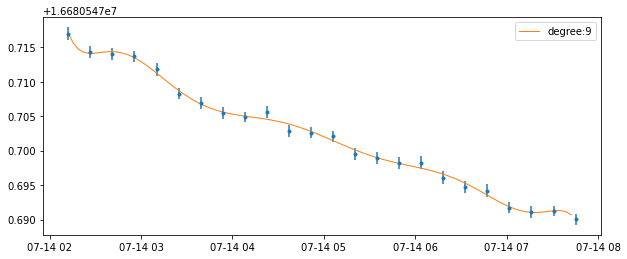

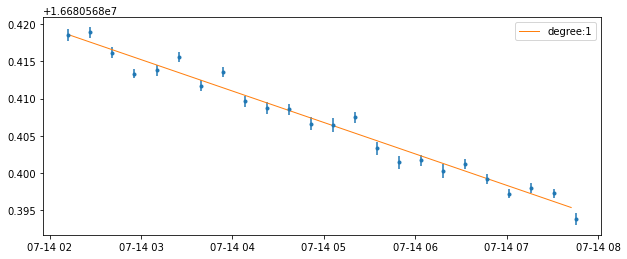

In [29]:
# show results

polynom_fit.plot_best_results(step7_results, step10_polyfit_best, line_width = 1)

In [30]:
#for grpname, grp in step10_polyfit.groupby(["mcycle", "trap", "groupsize"]):
    #fig = px.line(grp, x="degree", y="R", error_y="dR", color="group", hover_data=['group'], title="mcycle, trap: "+str(grpname) )
    #fig.show()
    
Rmean = pd.DataFrame()
for grpname, grp in step10_polyfit.groupby(["mcycle", "trap"]):    
    R, inner, outer, chi2red = statistics.complete_mean_and_error(grp.R.to_numpy(), grp.dR.to_numpy())
    dR = np.nanmax([inner, outer])
    print(grpname, R, inner, outer, chi2red)
    Rmean = Rmean.append( pd.Series(data=[grpname[0], grpname[1], R, dR, inner, outer, chi2red], 
                                    index=["mcycle", "trap", "R", "dR", "inner", "outer", "chi2red"]), 
                          ignore_index=True )
    
results = pd.DataFrame()
for grpname, grp in step10_polyfit.groupby(["mcycle", "trap", "groupsize", "degree"]):
    R, inner, outer, chi2red = statistics.complete_mean_and_error(grp.R.to_numpy(), grp.dR.to_numpy())
    dR = max([inner, outer])
    #print(R-1, inner, outer, chi2red)
    Rall = float(Rmean[ (Rmean["mcycle"]==grpname[0]) & (Rmean["trap"]==grpname[1]) ]["R"])
    results = results.append( pd.Series(data=[grpname[0], grpname[1], grpname[2], grpname[3], R, R-Rall, dR, inner, outer, chi2red], 
                                        index=["mcycle", "trap", "groupsize", "degree", "R", "R-Rmean", "dR", "inner", "outer", "chi2red"]), 
                              ignore_index=True )

fig = px.line(results, x="degree", y="R-Rmean", error_y="dR", color="groupsize", facet_row="mcycle", facet_col="trap" )
fig.update_layout( yaxis = dict( showexponent = 'all', exponentformat = 'e' ) )
fig.show()
fig = px.line(results, x="groupsize", y="R-Rmean", error_y="dR", color="degree", facet_row="mcycle", facet_col="trap" )
fig.update_layout( yaxis = dict( showexponent = 'all', exponentformat = 'e' ) )
fig.show()


(1.0, 2.0) 0.9999999860740413 4.018745076714787e-12 2.8639708222962976e-12 0.5078743293145576
(1.0, 3.0) 0.999999986091983 3.4660984700674096e-12 2.3589517012663084e-12 0.4631869390154901


In [31]:
#display(step10_polyfit)
#chi2s = step10_polyfit.chi2red.to_numpy()
#print(chi2s)
#print(chi2s.mean(), chi2s.std())

In [32]:
display(step10_polyfit_best)
chi2s = step10_polyfit_best.chi2red.to_numpy()
print(chi2s)
print(chi2s.mean(), chi2s.std())

AIC              AICc               BIC               R  \
11 -271.657958410902 -254.734881487825 -336.150712035773  0.999999986111   
11 -242.815423418815 -242.243994847387 -316.732607686470  0.999999986086   

                       c0              c1              c2              c3  \
11  16680547.717032918707 -0.000009126004  0.000000010242 -0.000000000005   
11  16680568.650694748387 -0.000001173565             NaN             NaN   

                c4              c5  ...              dR          degree  \
11  0.000000000000 -0.000000000000  ...  0.000000000022  9.000000000000   
11             NaN             NaN  ...  0.000000000018  1.000000000000   

             group       groupsize  ion_denom  ion_numer          mcycle  \
11  1.000000000000  0.000000000000   187Os29+   187Re29+  1.000000000000   
11  1.000000000000  0.000000000000   187Os29+   187Re29+  1.000000000000   

                          time_p            trap          Rminus  
11 2020-07-14 04:58:44.324999936  2.000000000000 -0.000000013889  
11 2020-07-14 04:58:42.595370240  3.000000000000 -0.000000013914  

[2 rows x 28 columns]

[0.506984448834 3.113995741506]
1.8104900951700271 1.3035056463356323


analysis type 	R-1     	err_in   	err_out   	chi2red   	(out/in) 	1+(0.477/sqrt(N))	# of R    	mean single err	R std	
naive merged 	0.0000000139162	0.0000000000150	0.0000000000159	1.1339406566960	1.0648664971235	1.1040899336426		21		0.0000000000694	0.0000000000682	
interpolated 	0.0000000139224	0.0000000000145	0.0000000000180	1.5383925120769	1.2403195201547	1.1016967417016		22		0.0000000000684	0.0000000000819	
poly all    	0.0000000139034	0.0000000000141	0.0000000000123	0.7643210017540	0.8742545405967	1.3372899346260		2		0.0000000000201	0.0000000000125	
poly t2     	0.0000000138886	0.0000000000220	nan	nan	nan	1.4770000000000		1		0.0000000000220	0.0000000000000	
poly t3     	0.0000000139136	0.0000000000182	nan	nan	nan	1.4770000000000		1		0.0000000000182	0.0000000000000	


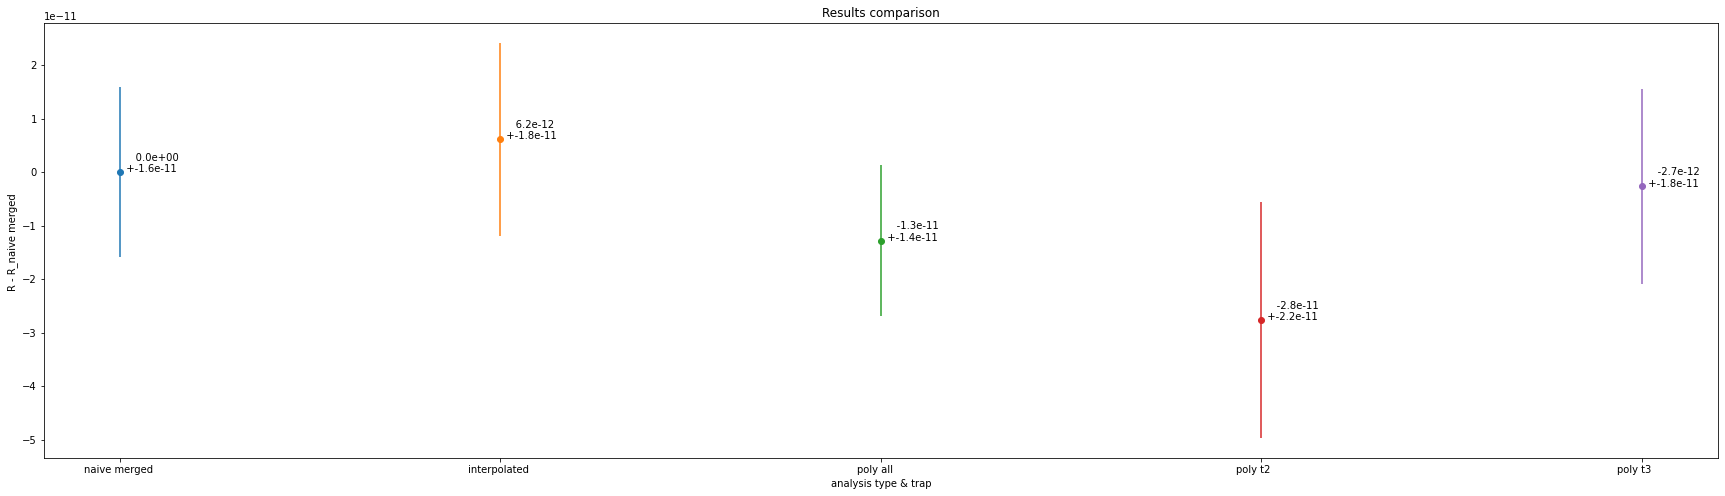

mcycle          Rminus              dR  \
0                1 -0.000000013890  0.000000000072   
1                1 -0.000000013894  0.000000000074   
2                1 -0.000000013851  0.000000000069   
3                1 -0.000000013817  0.000000000073   
4                1 -0.000000013949  0.000000000069   
5                1 -0.000000013894  0.000000000073   
6                1 -0.000000013959  0.000000000079   
7                1 -0.000000013867  0.000000000077   
8                1 -0.000000013837  0.000000000074   
9                1 -0.000000013930  0.000000000070   
10               1 -0.000000013911  0.000000000062   
11               1 -0.000000013953  0.000000000061   
12               1 -0.000000014084  0.000000000061   
13               1 -0.000000014006  0.000000000067   
14               1 -0.000000013861  0.000000000065   
15               1 -0.000000013952  0.000000000076   
16               1 -0.000000013981  0.000000000072   
17               1 -0.000000013864  0.000000000074   
18               1 -0.000000013824  0.000000000070   
19               1 -0.000000013993  0.000000000057   
20               1 -0.000000013831  0.000000000061   
21               1 -0.000000013961  0.000000000069   
22               1 -0.000000013844  0.000000000069   
23               1 -0.000000013960  0.000000000067   
24               1 -0.000000013916  0.000000000067   
25               1 -0.000000013788  0.000000000066   
26               1 -0.000000013881  0.000000000067   
27               1 -0.000000013947  0.000000000066   
28               1 -0.000000013916  0.000000000069   
29               1 -0.000000013916  0.000000000073   
30               1 -0.000000013834  0.000000000071   
31               1 -0.000000013915  0.000000000067   
32               1 -0.000000014005  0.000000000067   
33               1 -0.000000013816  0.000000000064   
34               1 -0.000000014081  0.000000000065   
35               1 -0.000000014088  0.000000000066   
36               1 -0.000000013893  0.000000000070   
37               1 -0.000000013862  0.000000000074   
38               1 -0.000000014071  0.000000000070   
39               1 -0.000000013849  0.000000000073   
40               1 -0.000000013844  0.000000000077   
41               1 -0.000000013909  0.000000000064   
42               1 -0.000000013955  0.000000000063   
43  1.000000000000 -0.000000013889  0.000000000022   
44  1.000000000000 -0.000000013914  0.000000000018   
45  1.000000000000 -0.000000013889  0.000000000022   
46  1.000000000000 -0.000000013914  0.000000000018   

                          time_p            trap       analysis  
0  2020-07-14 02:48:26.000000000               2  naive merged   
1  2020-07-14 03:46:20.000000000               2  naive merged   
2  2020-07-14 04:15:17.000000000               2  naive merged   
3  2020-07-14 04:44:14.000000000               2  naive merged   
4  2020-07-14 05:13:10.500000000               2  naive merged   
5  2020-07-14 05:42:08.000000000               2  naive merged   
6  2020-07-14 06:11:04.500000000               2  naive merged   
7  2020-07-14 06:40:01.500000000               2  naive merged   
8  2020-07-14 07:08:58.500000000               2  naive merged   
9  2020-07-14 07:37:54.500000000               2  naive merged   
10 2020-07-14 02:48:26.000000000               3  naive merged   
11 2020-07-14 03:17:23.500000000               3  naive merged   
12 2020-07-14 03:46:20.000000000               3  naive merged   
13 2020-07-14 04:15:17.000000000               3  naive merged   
14 2020-07-14 04:44:14.000000000               3  naive merged   
15 2020-07-14 05:13:10.500000000               3  naive merged   
16 2020-07-14 05:42:05.500000000               3  naive merged   
17 2020-07-14 06:11:04.500000000               3  naive merged   
18 2020-07-14 06:40:01.500000000               3  naive merged   
19 2020-07-14 07:08:58.500000000               3  naive merged   
20 2020-07-14 07:37:54.500000000 

In [33]:
results = {
    "naive merged ": step8_naive_results_merged,
    "interpolated ": step9_interpolate_results,
    "poly all    ": step10_polyfit_best,
    "poly t2     ": step10_polyfit_best[step10_polyfit_best["trap"]==2],
    "poly t3     ": step10_polyfit_best[step10_polyfit_best["trap"]==3],
}

visualization.compare(results)

In [34]:
print(step10_polyfit_best.columns)
display(step10_polyfit_best_fits.AICc)
print(step10_polyfit_best.chi2red)

Index(['AIC', 'AICc', 'BIC', 'R', 'c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6',
       'c7', 'c8', 'c9', 'chi2', 'chi2red', 'cycle_start', 'cycle_stop', 'dR',
       'degree', 'group', 'groupsize', 'ion_denom', 'ion_numer', 'mcycle',
       'time_p', 'trap', 'Rminus', 'analysis'],
      dtype='object')


0     -66.257487006258
1     -65.645364453031
2     -73.582404421293
3     -70.382877910845
4     -58.483273922958
            ...       
7    -104.698655537715
8    -149.316906983729
9    -124.187009822386
10   -127.207748064038
11   -242.243994847387
Name: AICc, Length: 132, dtype: float64

11    0.506984448834
11    3.113995741506
Name: chi2red, dtype: float64


#### SECOND: CANCELLATION ANALYSIS

A: Naive

B: Interpolation

C: Polynomial

##### FIRST: Data preparation (creating trap ratios) --- ONLY WITH 2 TRAP DATA!!! 
e.g.

Rpos1 = nu_c(trap2, t1) / nu_c(trap3, t1) = qmA * B(trap2, t1) / qmB / B(trap3, t1) = qmA/qmB * rohB(t1)

Rpos2 = nu_c(trap2, t2) / nu_c(trap3, t2) = qmB * B(trap2, t2) / qmA / B(trap3, t2) = qmB/qmA * rohB(t2)

for naive calculation then:

Rcancel = sqrt( Rpos1 / Rpos2 ) = sqrt( qmA^2/qmB^2 ) , if rohB(t1) == rohB(t2)

In [35]:
step11_trap_ratio_data = pd.DataFrame()
step7_results.sort_values(["mcycle", "trap", "time_p"], inplace=True)
step7_results.reset_index(drop=True, inplace=True)
traps = [2,3] # in this position trap 2 is numerator (trap2/trap3)

# ONLY WITH 2 TRAP DATA!!!
for name, grp in step7_results.groupby(["mcycle", "position"]):
    print("mcycle, trap:", name, "positions", grp.position.unique(), "subcycles", grp.subcycle.unique())

    results = ratio_analysis.calc_ratios(grp, y=['nu_c'], yerr=['dnu_c'], groupbys=['cycle', 'subcycle'], identifier="trap", ident_types=traps,
            keep_columns=['mcycle', 'position', 'time_p', 'trap'], additional_identifiers=['ion', 'time_p', 'time'], mean_columns=[])
        
    step11_trap_ratio_data = step11_trap_ratio_data.append(results, ignore_index=True)

step11_trap_ratio_data['masked'] = False
display(step11_trap_ratio_data)

mcycle, trap: (1, 'position_1') positions ['position_1'] subcycles [1]
mcycle, trap: (1, 'position_2') positions ['position_2'] subcycles [1 2]
not enough data in this group ['cycle', 'subcycle'] (3, 1)
not enough data in this group ['cycle', 'subcycle'] (3, 2)


mcycle    position                  time_p trap cycle subcycle  \
0       1  position_1 2020-07-14 02:26:43.800    2     1        1   
1       1  position_1 2020-07-14 02:55:40.900    2     2        1   
2       1  position_1 2020-07-14 03:24:38.000    2     3        1   
3       1  position_1 2020-07-14 03:53:34.800    2     4        1   
4       1  position_1 2020-07-14 04:22:31.900    2     5        1   
5       1  position_1 2020-07-14 04:51:28.600    2     6        1   
6       1  position_1 2020-07-14 05:20:25.400    2     7        1   
7       1  position_1 2020-07-14 05:49:22.300    2     8        1   
8       1  position_1 2020-07-14 06:18:19.300    2     9        1   
9       1  position_1 2020-07-14 06:47:16.300    2    10        1   
10      1  position_1 2020-07-14 07:16:13.200    2    11        1   
11      1  position_1 2020-07-14 07:45:09.500    2    12        1   
12      1  position_2 2020-07-14 02:12:15.300    2     1        1   
13      1  position_2 2020-07-14 02:41:12.500    2     2        1   
14      1  position_2 2020-07-14 03:39:06.400    2     4        1   
15      1  position_2 2020-07-14 04:08:03.500    2     5        1   
16      1  position_2 2020-07-14 04:37:00.100    2     6        1   
17      1  position_2 2020-07-14 05:05:56.800    2     7        1   
18      1  position_2 2020-07-14 05:34:54.000    2     8        1   
19      1  position_2 2020-07-14 06:03:50.800    2     9        1   
20      1  position_2 2020-07-14 06:32:47.900    2    10        1   
21      1  position_2 2020-07-14 07:01:44.600    2    11        1   
22      1  position_2 2020-07-14 07:30:40.900    2    12        1   

        ratio_nu_c     dratio_nu_c trap_numer trap_denom ion_numer ion_denom  \
0   0.999998744845  0.000000000067          2          3  187Re29+  187Os29+   
1   0.999998745141  0.000000000063          2          3  187Re29+  187Os29+   
2   0.999998744683  0.000000000063          2          3  187Re29+  187Os29+   
3   0.999998744634  0.000000000066          2          3  187Re29+  187Os29+   
4   0.999998744932  0.000000000069          2          3  187Re29+  187Os29+   
5   0.999998744882  0.000000000072          2          3  187Re29+  187Os29+   
6   0.999998744644  0.000000000066          2          3  187Re29+  187Os29+   
7   0.999998744924  0.000000000072          2          3  187Re29+  187Os29+   
8   0.999998744867  0.000000000081          2          3  187Re29+  187Os29+   
9   0.999998744822  0.000000000069          2          3  187Re29+  187Os29+   
10  0.999998744708  0.000000000066          2          3  187Re29+  187Os29+   
11  0.999998744893  0.000000000069          2          3  187Re29+  187Os29+   
12  0.999998772830  0.000000000073          2          3  187Os29+  187Re29+   
13  0.999998772794  0.000000000068          2          3  187Os29+  187Re29+   
14  0.999998772636  0.000000000070          2          3  187Os29+  187Re29+   
15  0.999998772640  0.000000000067          2          3  187Os29+  187Re29+   
16  0.999998772585  0.000000000066          2          3  187Os29+  187Re29+   
17  0.999998772664  0.000000000073          2          3  187Os29+  187Re29+   
18  0.999998772659  0.000000000074          2          3  187Os29+  187Re29+   
19  0.999998772719  0.000000000072          2          3  187Os29+  187Re29+   
20  0.999998772535  0.000000000065          2          3  187Os29+  187Re29+   
21  0.999998772595  0.000000000063          2          3  187Os29+  187Re29+   
22  0.999998772561  0.000000000060          2          3  187Os29+  187Re29+   

              time_p_numer                  time_p_denom  \
0  2020-07-14 02:26:43.800 2020-07-14 02:26:43.800000000   
1  2020-07-14 02:55:40.900 2020-07-14 02:55:40.900000000   
2  2020-07-14 03:24:38.000 2020-07-14 03:24:38.000000000   
3  2020-07-14 03:53:34.800 2020-07-14 03:53:34.800000000   
4  2020-07-14 04:22:31.900 2020-07-14 04:22:31.900000000   
5  2020-07-14 04:51:28.600 2020-07-14 04:51:28.600000000   
6  20

In [36]:
step11_trap_ratio_data["Rminus"] = step11_trap_ratio_data["ratio_nu_c"] - 1.0

step11_trap_ratio_data.to_csv(results_dir + "step11_trap_ratio_data.csv")
step11_trap_ratio_data.to_csv(results_dir + "step11_trap_ratio_data.txt", sep="\t")

fig = px.line(step11_trap_ratio_data, x="time_p", y="Rminus", error_y="dratio_nu_c", facet_row='position', hover_data=['mcycle', 'cycle'])
fig.update_yaxes(matches=None, showticklabels=True)
fig.show()

### Step 11: Naive Cancellation method

Data is evaluated using the cancellation method (see PhD Thesis Andreas Doerr for example)

In integer cycles R is calculated using e.g. cycle1/position1 and cycle1/position2,
in half cycles R is calculated using e.g. cycle1/position2 and cycle2/position1. Those are just used as a cross check: if the magnetic field ratio drifted a lot during the measurement, the normal and between values will split apart. This is not good, and an indicator of to much drift

In [37]:
step11_cancel_naive_results = pd.DataFrame()
step11_cancel_naive_results_bc = pd.DataFrame()
step11_trap_ratio_data.sort_values(["mcycle", "position", "time_p"], inplace=True)
step11_trap_ratio_data.reset_index(drop=True, inplace=True)
positions = ["position_2","position_1"] # in this position trap 2 is numerator (trap2/trap3)
invert = settings.get("invert", True)

# ONLY WITH 2 TRAP DATA!!!
for name, grp in step11_trap_ratio_data.groupby(["mcycle"]):
    print("mcycle, trap:", name, "positions", grp.position.unique(), "subcycles", grp.subcycle.unique())

    #results = ratio_analysis.calc_ratios(grp, y=['ratio_nu_c'], yerr=['dratio_nu_c'], groupbys=['cycle', 'subcycle'], identifier="position", ident_types=positions,
    #        keep_columns=['mcycle', 'time_p', 'trap'], additional_identifiers=['ion_numer', 'ion_denom', 'time_p'], mean_columns=[])
    #    
    #step11_cancel_naive_results = step11_cancel_naive_results.append(results, ignore_index=True)

    if not invert:
        positions = positions[::-1]

    grp_bc = grp.copy()
    grp_bc.loc[grp_bc.position != start_position, ['cycle']] += 1
        
    results = ratio_analysis.calc_ratios(grp, y=['ratio_nu_c'], yerr=['dratio_nu_c'], groupbys=['cycle', 'subcycle'], identifier="position", ident_types=positions,
            keep_columns=['mcycle', 'trap'], additional_identifiers=['ion_numer', 'ion_denom', 'time_p'], mean_columns=['time_p'])
    results_bc = ratio_analysis.calc_ratios(grp_bc, y=['ratio_nu_c'], yerr=['dratio_nu_c'], groupbys=['cycle', 'subcycle'], identifier="position", ident_types=positions,
            keep_columns=['mcycle', 'trap'], additional_identifiers=['ion_numer', 'ion_denom', 'time_p'], mean_columns=['time_p'])

    step11_cancel_naive_results = step11_cancel_naive_results.append(results, ignore_index=True)
    step11_cancel_naive_results_bc = step11_cancel_naive_results_bc.append(results_bc, ignore_index=True)
   

mcycle, trap: 1 positions ['position_1' 'position_2'] subcycles [1]
not enough data in this group ['cycle', 'subcycle'] (3, 1)
not enough data in this group ['cycle', 'subcycle'] (1, 1)
not enough data in this group ['cycle', 'subcycle'] (3, 1)
not enough data in this group ['cycle', 'subcycle'] (13, 1)


In [38]:
#display(step11_cancel_naive_results)

# the 'ratio' calculated in the step before is acutally qmA^2 / qmB^2, so we have to take the sqrt (make sure you get the Error right!)
step11_cancel_naive_results["R"] = np.sqrt( step11_cancel_naive_results["ratio_ratio_nu_c"] )
step11_cancel_naive_results["dR"] = step11_cancel_naive_results["dratio_ratio_nu_c"]/step11_cancel_naive_results["R"]/2
step11_cancel_naive_results["Rminus"] = step11_cancel_naive_results["R"] - 1    

step11_cancel_naive_results_bc["R"] = np.sqrt( step11_cancel_naive_results_bc["ratio_ratio_nu_c"] )
step11_cancel_naive_results_bc["dR"] = step11_cancel_naive_results_bc["dratio_ratio_nu_c"]/step11_cancel_naive_results_bc["R"]/2
step11_cancel_naive_results_bc["Rminus"] = step11_cancel_naive_results_bc["R"] - 1

step11_cancel_naive_results_merged = statistics.merge_odd_even_results(step11_cancel_naive_results, step11_cancel_naive_results_bc)
step11_cancel_naive_results_merged["Rminus"] = step11_cancel_naive_results_merged["R"] - 1.0

step11_cancel_naive_results.to_csv(results_dir + "step11_cancel_naive_results.csv")
step11_cancel_naive_results.to_csv(results_dir + "step11_cancel_naive_results.txt", sep="\t")
step11_cancel_naive_results_bc.to_csv(results_dir + "step11_cancel_naive_results_bc.csv")
step11_cancel_naive_results_bc.to_csv(results_dir + "step11_cancel_naive_results_bc.txt", sep="\t")
step11_cancel_naive_results_merged.to_csv(results_dir + "step11_cancel_naive_results_merged.csv")
step11_cancel_naive_results_merged.to_csv(results_dir + "step11_cancel_naive_results_merged.txt", sep="\t")

lost 1 len(odd/even/merged) 11 10 10


In [39]:
fig = px.line(step11_cancel_naive_results, x="time_p", y="Rminus", error_y="dR", color='trap', hover_data=['mcycle', 'cycle'])
fig.show()
fig = px.line(step11_cancel_naive_results_bc, x="time_p", y="Rminus", error_y="dR", color='trap', hover_data=['mcycle', 'cycle'])
fig.show()
fig = px.line(step11_cancel_naive_results_merged, x="time_p", y="Rminus", error_y="dR", color='trap', hover_data=['mcycle', 'cycle'])
fig.show()

analysis type 	R-1     	err_in   	err_out   	chi2red   	(out/in) 	1+(0.477/sqrt(N))	# of R    	mean single err	R std	
naive merged  	0.0000000139162	0.0000000000150	0.0000000000159	1.1339406566960	1.0648664971235	1.1040899336426		21		0.0000000000694	0.0000000000682	
interpolated  	0.0000000139224	0.0000000000145	0.0000000000180	1.5383925120769	1.2403195201547	1.1016967417016		22		0.0000000000684	0.0000000000819	
poly all      	0.0000000139034	0.0000000000141	0.0000000000123	0.7643210017540	0.8742545405967	1.3372899346260		2		0.0000000000201	0.0000000000125	
cancel merged 	0.0000000139097	0.0000000000156	0.0000000000146	0.8774344190583	0.9367146945886	1.1508406443900		10		0.0000000000494	0.0000000000438	
cancel naive  	0.0000000139042	0.0000000000146	0.0000000000215	2.1657200420228	1.4716385568552	1.1438209113636		11		0.0000000000486	0.0000000000675	
cancel naivebc	0.0000000139243	0.0000000000153	0.0000000000207	1.8435501020461	1.3577739510118	1.1508406443900		10		0.0000000000484	0.0000

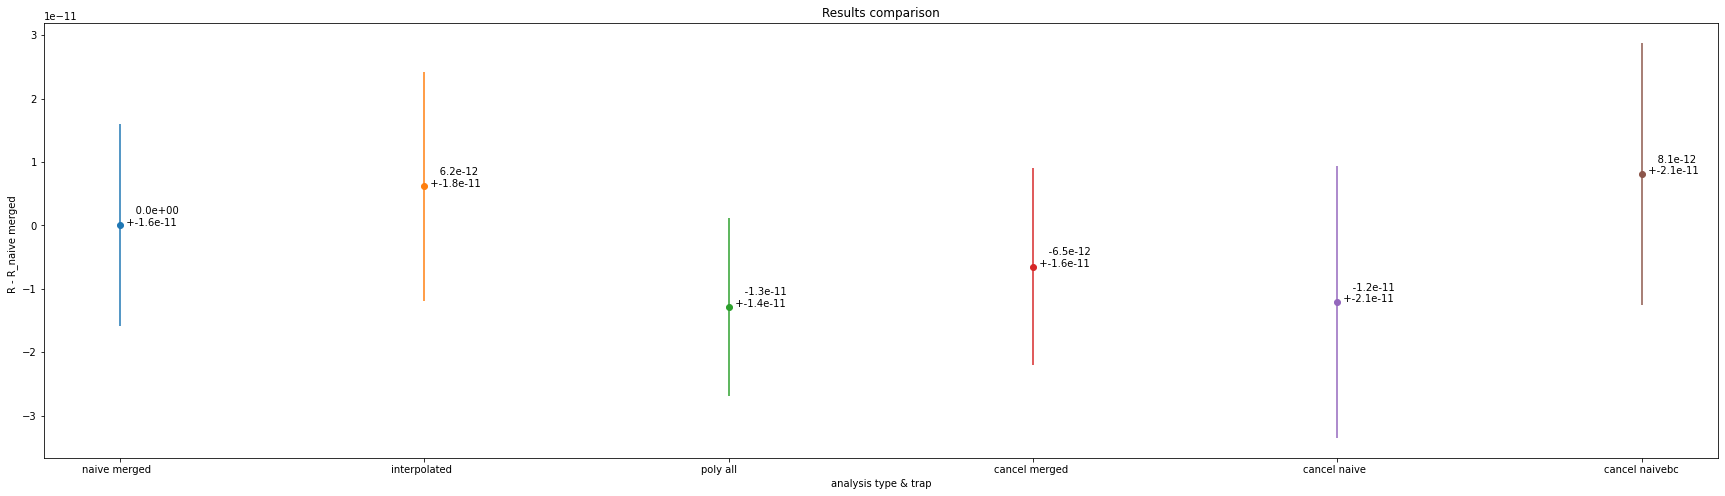

mcycle          Rminus              dR                  time_p trap  \
0       1 -0.000000013890  0.000000000072 2020-07-14 02:48:26.000    2   
1       1 -0.000000013894  0.000000000074 2020-07-14 03:46:20.000    2   
2       1 -0.000000013851  0.000000000069 2020-07-14 04:15:17.000    2   
3       1 -0.000000013817  0.000000000073 2020-07-14 04:44:14.000    2   
4       1 -0.000000013949  0.000000000069 2020-07-14 05:13:10.500    2   
..    ...             ...             ...                     ...  ...   
71      1 -0.000000014008  0.000000000049 2020-07-14 05:27:39.500    2   
72      1 -0.000000013897  0.000000000051 2020-07-14 05:56:36.000    2   
73      1 -0.000000013834  0.000000000052 2020-07-14 06:25:33.000    2   
74      1 -0.000000013887  0.000000000047 2020-07-14 06:54:30.000    2   
75      1 -0.000000013926  0.000000000044 2020-07-14 07:23:26.500    2   

          analysis  
0   naive merged    
1   naive merged    
2   naive merged    
3   naive merged    
4   naive merged    
..             ...  
71  cancel naivebc  
72  cancel naivebc  
73  cancel naivebc  
74  cancel naivebc  
75  cancel naivebc  

[76 rows x 6 columns]

In [40]:
results = {
    "naive merged  ": step8_naive_results_merged,
    "interpolated  ": step9_interpolate_results,
    "poly all      ": step10_polyfit_best,
    "cancel merged ": step11_cancel_naive_results_merged,
    "cancel naive  ": step11_cancel_naive_results,
    "cancel naivebc": step11_cancel_naive_results_bc,
}

visualization.compare(results)

### Step 12: Interpolated Cancellation
The trap ratios are interpolated to the same time. It works exacly the same as the interpolation in step 9.

In [41]:
# For the interpolation we have to have averaged data.
step12_cancel_interpol_results = pd.DataFrame()
step12_avg_data = pd.DataFrame()
for grpname, grpdata in step11_trap_ratio_data.groupby(["mcycle", "position"]):
    print('mcycle, position', grpname)
    avgdata = pd.DataFrame()
    for subname, subgrpdata in grpdata.groupby("cycle"):
        avg = statistics.average_subsets(subgrpdata, groupby=["cycle"], errortype="weighted",
                                              columns=["ratio_nu_c", "time_p"], 
                                              dcolumns=["dratio_nu_c", None],
                                              masked=False)
        avgdata = avgdata.append(avg)
        
    avgdata['masked'] = False
    
    # filter by min max boundaries for values, default: min_val: 1, max_val: 1e9:
    avgdata = filtering.minmax_value(avgdata, val="ratio_nu_c", min_val=0, max_val=100)

    # apply autofilter 3-sigma condition: calc mean of values and std
    # if value is outside of mean+-3*std, it is masked
    avgdata = filtering.three_sigma(avgdata, val="ratio_nu_c", err="dratio_nu_c", undrift_xcolumn="time_p", show=False)
    #display(subset)

    # apply autofilter sigma-size: if sigma of value is 3 time bigger
    # then mean sigma, it is masked
    avgdata = filtering.sigma_size(avgdata, err="dratio_nu_c")
       
    step12_avg_data = step12_avg_data.append(avgdata)

print("averaged")
#display(step12_avg_data)
step12_avg_data = step12_avg_data.sort_values("time_p")
step12_avg_data.reset_index(drop=True, inplace=True)
step12_interpolated_data = pd.DataFrame()
step12_cancel_interpol_results = pd.DataFrame()
positions = ["position_2","position_1"]

for grpname, grpdata in step12_avg_data.groupby(["mcycle"]):
    print('mcycle', grpname)
    reference, interpolate = 'position_1', 'position_2' # what was measured first in time? Thats the one we want to interpolate

    interpolated_data = ratio_analysis.interpolate(grpdata, y=['ratio_nu_c'], yerr=['dratio_nu_c'], groupbys=['mcycle'], x="time_p",
                    identifier="position", id_reference=reference, id_interpolate=interpolate,
                    non_linear_uncertainty_per_second=0)
        
    step12_interpolated_data = step12_interpolated_data.append(interpolated_data)
    
    if not invert:
        positions = ["position_1","position_2"]
    else:
        positions = ["position_2","position_1"]
    
    results = ratio_analysis.calc_ratios(interpolated_data, y=['ratio_nu_c'], yerr=['dratio_nu_c'], groupbys=['cycle', 'subcycle'], identifier="position", ident_types=positions,
            keep_columns=['mcycle', 'time_p', 'trap'], additional_identifiers=['ion_numer', 'ion_denom', 'time_p'], mean_columns=[])

    step12_cancel_interpol_results = step12_cancel_interpol_results.append(results, ignore_index=True)
    

mcycle, position (1, 'position_1')
mcycle, position (1, 'position_2')


C:\Users\door\AppData\Roaming\Python\Python37\site-packages\numpy\core\_methods.py:263: RuntimeWarning:

Degrees of freedom <= 0 for slice



averaged
mcycle 1.0
not the correct identifier before/after position_2 position_1
not the correct identifier before/after position_1 position_2


In [42]:
#display(step11_cancel_naive_results)

# the 'ratio' calculated in the step before is acutally qmA^2 / qmB^2, so we have to take the sqrt (make sure you get the Error right!)
step12_cancel_interpol_results["R"] = np.sqrt( step12_cancel_interpol_results["ratio_ratio_nu_c"] )
step12_cancel_interpol_results["dR"] = step12_cancel_interpol_results["dratio_ratio_nu_c"]/step12_cancel_interpol_results["R"]/2
step12_cancel_interpol_results["Rminus"] = step12_cancel_interpol_results["R"] - 1    

step12_cancel_interpol_results.to_csv(results_dir + "step12_cancel_interpol_results.csv")
step12_cancel_interpol_results.to_csv(results_dir + "step12_cancel_interpol_results.txt", sep="\t")

fig = px.line(step12_cancel_interpol_results, x="time_p", y="Rminus", error_y="dR", hover_data=['mcycle', 'cycle'])
fig.show()

# TIP: it should be ion_numer_numer = ion_denom_denom and ion_numer_denom = ion_denom_numer (ending up ionA^2 / ionB^2)

analysis type 	R-1     	err_in   	err_out   	chi2red   	(out/in) 	1+(0.477/sqrt(N))	# of R    	mean single err	R std	
naive merged 	0.0000000139162	0.0000000000150	0.0000000000159	1.1339406566960	1.0648664971235	1.1040899336426		21		0.0000000000694	0.0000000000682	
interpolated 	0.0000000139224	0.0000000000145	0.0000000000180	1.5383925120769	1.2403195201547	1.1016967417016		22		0.0000000000684	0.0000000000819	
poly all     	0.0000000139034	0.0000000000141	0.0000000000123	0.7643210017540	0.8742545405967	1.3372899346260		2		0.0000000000201	0.0000000000125	
cancel merged	0.0000000139097	0.0000000000156	0.0000000000146	0.8774344190583	0.9367146945886	1.1508406443900		10		0.0000000000494	0.0000000000438	
cancel interp	0.0000000139218	0.0000000000141	0.0000000000215	2.3350573039763	1.5280894293124	1.1590000000000		9		0.0000000000424	0.0000000000605	


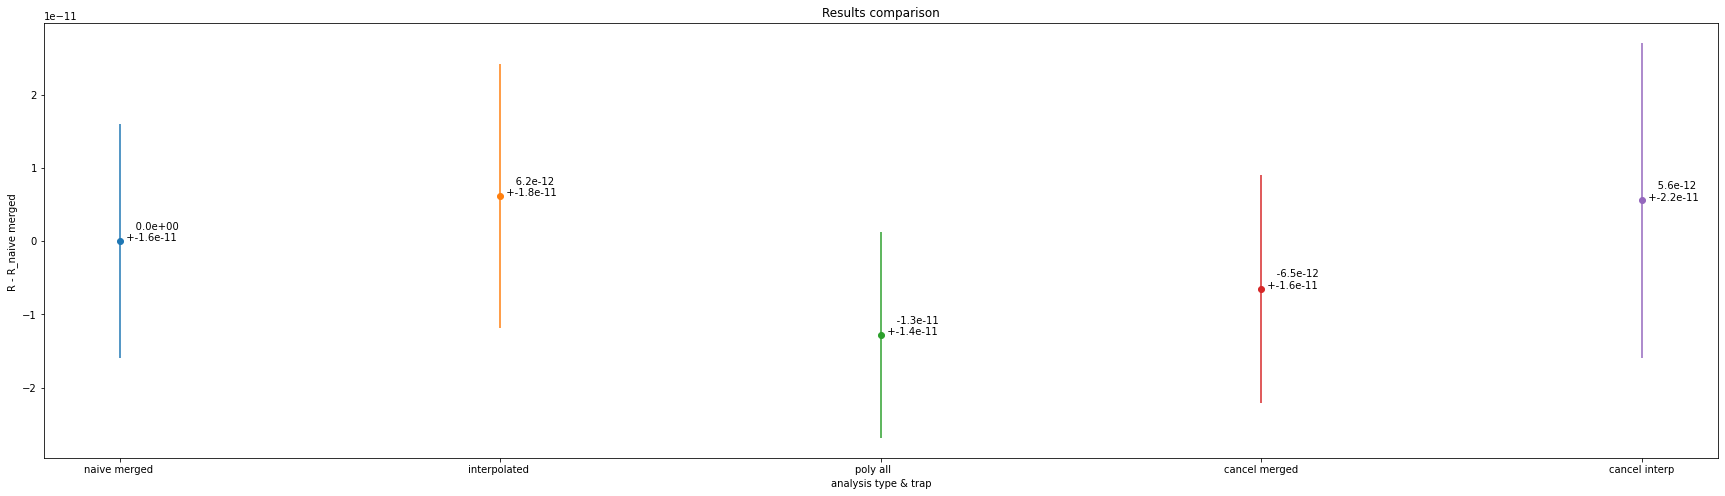

mcycle          Rminus              dR                  time_p  \
0                1 -0.000000013890  0.000000000072 2020-07-14 02:48:26.000   
1                1 -0.000000013894  0.000000000074 2020-07-14 03:46:20.000   
2                1 -0.000000013851  0.000000000069 2020-07-14 04:15:17.000   
3                1 -0.000000013817  0.000000000073 2020-07-14 04:44:14.000   
4                1 -0.000000013949  0.000000000069 2020-07-14 05:13:10.500   
..             ...             ...             ...                     ...   
59  1.000000000000 -0.000000014009  0.000000000042 2020-07-14 05:20:25.000   
60  1.000000000000 -0.000000013882  0.000000000044 2020-07-14 05:49:22.000   
61  1.000000000000 -0.000000013880  0.000000000047 2020-07-14 06:18:19.000   
62  1.000000000000 -0.000000013872  0.000000000041 2020-07-14 06:47:16.000   
63  1.000000000000 -0.000000013935  0.000000000039 2020-07-14 07:16:13.000   

              trap       analysis  
0                2  naive merged   
1                2  naive merged   
2                2  naive merged   
3                2  naive merged   
4                2  naive merged   
..             ...            ...  
59  2.000000000000  cancel interp  
60  2.000000000000  cancel interp  
61  2.000000000000  cancel interp  
62  2.000000000000  cancel interp  
63  2.000000000000  cancel interp  

[64 rows x 6 columns]

In [43]:
results = {
    "naive merged ": step8_naive_results_merged,
    "interpolated ": step9_interpolate_results,
    "poly all     ": step10_polyfit_best,
    "cancel merged": step11_cancel_naive_results_merged,
    "cancel interp": step12_cancel_interpol_results,
}

visualization.compare(results)

### Step 13: Polyfit Cancellation


In [44]:
# you might want to do manual grouping
temp_df = pd.DataFrame()
step11_trap_ratio_data['masked'] = False # the ratio calc was already masked selective.
for gname, grp in step11_trap_ratio_data.groupby(['mcycle']):
    grp = polynom_fit.auto_group_subset(grp, 4, 4-1, sortby=["cycle", "time_p"])
    temp_df = temp_df.append(grp)

temp_df.sort_values(['mcycle', 'time_p'], inplace=True)
temp_df.reset_index(drop=True, inplace=True)
#display(step7_results)

visualization.manual_grouping_plot(temp_df, groupby=["mcycle"], sets="position", y='ratio_nu_c', yerr='dratio_nu_c', x="time_p")

In [45]:
step11_trap_ratio_data = temp_df

In [46]:
Rguess = step8_naive_results['R'].mean()

step13_cancel_polyfit = pd.DataFrame()
step13_cancel_polyfit_best_fits = pd.DataFrame()
step13_cancel_polyfit_best = pd.DataFrame()
step11_trap_ratio_data['ion'] = step11_trap_ratio_data['ion_numer']
degrees = settings.get("polydegrees", 'auto')
polygrouping = settings.get("polygrouping", 'auto')
invert = settings.get("invert", True)
import time
start = time.perf_counter()

for idx, mc in enumerate(mcs):
    print(">>> mcycle:", mc)
    # get the subset
    subset = step11_trap_ratio_data[ (step11_trap_ratio_data["mcycle"] == mc) ]
    if len(subset.index) < 3:
        continue
    
    # get the testing parameters
    if isinstance(polygrouping, str) and polygrouping == 'auto':
        group_sizes = list(range(3, int(np.ceil(len(subset.cycle.unique())/4))+1)) # e.g. 24 data points->12 points per position->6/6 is the smallest splitting
        group_sizes.append(0) # 0 stands for full main cycle
    else:
        group_sizes = polygrouping
    if not group_sizes:
        group_sizes = [3]
    print("group sizes:", group_sizes)        

    if isinstance(degrees, str) and degrees == 'auto':
        poly_degrees = list(range(1, len(subset.cycle.unique())-2)) # e.g. full data set 24 data points - 2 for ratio and keeping one free
    else:
        poly_degrees = degrees
    if not poly_degrees:
        poly_degrees = [1]
    print("polynom degrees:", poly_degrees)

    # fit with all the settings
    subset, results, best_fits, best_results = polynom_fit.fit_sharedpoly_ratio(subset, Rguess, y="ratio_nu_c", yerr="dratio_nu_c", data_identifier="position", 
                                           invert=invert, groupsize=group_sizes, degree=poly_degrees, mode='curvefit', 
                                           x="time_p", keep_columns=["mcycle", "trap"], bestfit="AICc", bestgroupsize="mindR", show=False)

    step13_cancel_polyfit = step13_cancel_polyfit.append(results, ignore_index=True)
    step13_cancel_polyfit_best_fits = step13_cancel_polyfit_best_fits.append(best_fits, ignore_index=True)
    step13_cancel_polyfit_best = step13_cancel_polyfit_best.append(best_results, ignore_index=True)

step13_cancel_polyfit["Rfit"] = step13_cancel_polyfit["R"]
step13_cancel_polyfit_best_fits["Rfit"] = step13_cancel_polyfit_best_fits["R"]
step13_cancel_polyfit_best["Rfit"] = step13_cancel_polyfit_best["R"]
step13_cancel_polyfit["dRfit"] = step13_cancel_polyfit["dR"]
step13_cancel_polyfit_best_fits["dRfit"] = step13_cancel_polyfit_best_fits["dR"]
step13_cancel_polyfit_best["dRfit"] = step13_cancel_polyfit_best["dR"]

stop = time.perf_counter()
print("time:", stop-start)
        
pd.options.mode.chained_assignment = None  # default='warn'
pd.options.display.float_format = '{: .12f}'.format
display(step13_cancel_polyfit.head(10))
display(step13_cancel_polyfit_best)

>>> mcycle: 1
group sizes: [3, 0]
polynom degrees: [1, 2, 3, 4, 5, 6, 7, 8, 9]
>> group sizes: 3 polynom degree: 1
no dR from pcov, fixed with chi2 vs. R error estimation: dR= 3.200151255100536e-11
no dR from pcov, fixed with chi2 vs. R error estimation: dR= 4.000133557724439e-11
no dR from pcov, fixed with chi2 vs. R error estimation: dR= 3.200151255100536e-11
>> group sizes: 3 polynom degree: 2
no dR from pcov, fixed with chi2 vs. R error estimation: dR= 3.200151255100536e-11
no dR from pcov, fixed with chi2 vs. R error estimation: dR= 4.000133557724439e-11
no dR from pcov, fixed with chi2 vs. R error estimation: dR= 3.200151255100536e-11
>> group sizes: 3 polynom degree: 3
no dR from pcov, fixed with chi2 vs. R error estimation: dR= 3.200151255100536e-11


C:\Users\door\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\minpack.py:808: OptimizeWarning:

Covariance of the parameters could not be estimated



>> group sizes: 3 polynom degree: 4
>> group sizes: 3 polynom degree: 5
no dR from pcov, fixed with chi2 vs. R error estimation: dR= 3.200151255100536e-11
>> group sizes: 3 polynom degree: 6
>> group sizes: 3 polynom degree: 7
>> group sizes: 3 polynom degree: 8
>> group sizes: 3 polynom degree: 9
> best in group idx/size:  1.0 3 with criterion: AICc degree: 1
> best in group idx/size:  2.0 3 with criterion: AICc degree: 1
> best in group idx/size:  3.0 3 with criterion: AICc degree: 1
all in one group...
>> group sizes: 0 polynom degree: 1
no dR from pcov, fixed with chi2 vs. R error estimation: dR= 2.000177801164682e-11
>> group sizes: 0 polynom degree: 2
no dR from pcov, fixed with chi2 vs. R error estimation: dR= 2.000177801164682e-11
>> group sizes: 0 polynom degree: 3
>> group sizes: 0 polynom degree: 4
>> group sizes: 0 polynom degree: 5
>> group sizes: 0 polynom degree: 6
>> group sizes: 0 polynom degree: 7
>> group sizes: 0 polynom degree: 8
>> group sizes: 0 polynom degree: 9

C:\Users\door\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\minpack.py:808: OptimizeWarning:

Covariance of the parameters could not be estimated



AIC              AICc               BIC               R  \
0 -254.364065353292 -242.364065353292 -265.739343760976  0.999999972176   
1 -260.927887125100 -248.927887125100 -272.303165532784  0.999999972321   
2 -477.181879931523 -473.753308502952 -502.365042113910  0.999999972245   
3 -253.601581154219 -213.601581154219 -265.185100092675  0.999999972127   
4 -261.503190769414 -221.503190769414 -273.086709707870  0.999999972325   
5 -475.500329861572 -468.833663194906 -500.285596771161  0.999999972247   
6 -475.928656849438 -463.928656849438 -500.316028486228  0.999999972226   
7 -490.407710142541 -469.407710142541 -514.397186506533  0.999999972222   
8 -472.220064665572 -434.886731332238 -495.811645756765  0.999999972222   
9 -491.389253192470 -419.389253192470 -514.582939010866  0.999999972200   

               c0              c1              c2              c3  \
0  0.999998745044 -0.000000000000             NaN             NaN   
1  0.999998745030 -0.000000000000             NaN             NaN   
2  0.999998744926 -0.000000000000             NaN             NaN   
3  0.999998744911  0.000000000000 -0.000000000000             NaN   
4  0.999998744952  0.000000000000 -0.000000000000             NaN   
5  0.999998744958 -0.000000000000  0.000000000000             NaN   
6  0.999998744875  0.000000000000 -0.000000000000  0.000000000000   
7  0.999998744882  0.000000000000  0.000000000000 -0.000000000000   
8  0.999998744882  0.000000000000  0.000000000000 -0.000000000000   
9  0.999998744863 -0.000000000000  0.000000000000 -0.000000000000   

               c4              c5  ...          degree           group  \
0             NaN             NaN  ...  1.000000000000  1.000000000000   
1             NaN             NaN  ...  1.000000000000  2.000000000000   
2             NaN             NaN  ...  1.000000000000  3.000000000000   
3             NaN             NaN  ...  2.000000000000  1.000000000000   
4             NaN             NaN  ...  2.000000000000  2.000000000000   
5             NaN             NaN  ...  2.000000000000  3.000000000000   
6             NaN             NaN  ...  3.000000000000  3.000000000000   
7  0.000000000000             NaN  ...  4.000000000000  3.000000000000   
8  0.000000000000  0.000000000000  ...  5.000000000000  3.000000000000   
9  0.000000000000 -0.000000000000  ...  6.000000000000  3.000000000000   

        groupsize  ion_denom  ion_numer          mcycle  \
0  3.000000000000   187Os29+   187Re29+  1.000000000000   
1  3.000000000000   187Os29+   187Re29+  1.000000000000   
2  3.000000000000   187Os29+   187Re29+  1.000000000000   
3  3.000000000000   187Os29+   187Re29+  1.000000000000   
4  3.000000000000   187Os29+   187Re29+  1.000000000000   
5  3.000000000000   187Os29+   187Re29+  1.000000000000   
6  3.000000000000   187Os29+   187Re29+  1.000000000000   
7  3.000000000000   187Os29+   187Re29+  1.000000000000   
8  3.000000000000   187Os29+   187Re29+  1.000000000000   
9  3.000000000000   187Os29+   187Re29+  1.000000000000   

                         time_p            trap            Rfit  \
0 2020-07-14 02:55:40.333333248  2.000000000000  0.999999972176   
1 2020-07-14 04:29:45.500000000  2.000000000000  0.999999972321   
2 2020-07-14 06:31:28.181818112  2.000000000000  0.999999972245   
3 2020-07-14 02:55:40.333333248  2.000000000000  0.999999972127   
4 2020-07-14 04:29:45.500000000  2.000000000000  0.999999972325   
5 2020-07-14 06:31:28.181818112  2.000000000000  0.999999972247   
6 2020-07-14 06:31:28.181818112  2.000000000000  0.999999972226   
7 2020-07-14 06:31:28.181818112  2.000000000000  0.999999972222   
8 2020-07-14 06:31:28.181818112  2.000000000000  0.999999972222   
9 2020-07-14 06:31:28.181818112  2.000000000000  0.999999972200   

            dRfit  
0  0.000000000032  
1  0.000000000040  
2  0.000000000032  
3  0.000000000032  
4  0.000000000040  
5  0.000000000032  
6  0.000000000032  
7  0.000000000044  
8  0.000000000032  
9  0.000000000063  

[10 ro

AIC              AICc                BIC               R  \
0 -975.075125202226 -971.545713437520 -1041.514021088950  0.999999972182   

               c0              c1              c2              c3  c4  c5  \
0  0.999998745010 -0.000000000000  0.000000000000 -0.000000000000 NaN NaN   

   ...          degree           group       groupsize  ion_denom  ion_numer  \
0  ...  3.000000000000  1.000000000000  0.000000000000   187Os29+   187Re29+   

           mcycle                        time_p            trap  \
0  1.000000000000 2020-07-14 05:03:25.434782464  2.000000000000   

             Rfit           dRfit  
0  0.999999972182  0.000000000030  

[1 rows x 29 columns]

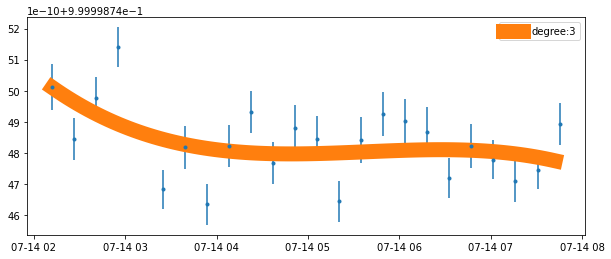

In [47]:
# show results

polynom_fit.plot_best_results(step11_trap_ratio_data, step13_cancel_polyfit_best, groupby=['mcycle'], x='time_p', y='ratio_nu_c', yerr='dratio_nu_c')

In [48]:

# the 'ratio' calculated in the step before is acutally qmA^2 / qmB^2, so we have to take the sqrt (make sure you get the Error right!)
step13_cancel_polyfit["R"] = np.sqrt( step13_cancel_polyfit["Rfit"] )
step13_cancel_polyfit["dR"] = step13_cancel_polyfit["dRfit"]/step13_cancel_polyfit["R"]/2
step13_cancel_polyfit["Rminus"] = step13_cancel_polyfit["R"] - 1
step13_cancel_polyfit_best_fits["R"] = np.sqrt( step13_cancel_polyfit_best_fits["Rfit"] )
step13_cancel_polyfit_best_fits["dR"] = step13_cancel_polyfit_best_fits["dRfit"]/step13_cancel_polyfit_best_fits["R"]/2
step13_cancel_polyfit_best_fits["Rminus"] = step13_cancel_polyfit_best_fits["R"] - 1
step13_cancel_polyfit_best["R"] = np.sqrt( step13_cancel_polyfit_best["Rfit"] )
step13_cancel_polyfit_best["dR"] = step13_cancel_polyfit_best["dRfit"]/step13_cancel_polyfit_best["R"]/2
step13_cancel_polyfit_best["Rminus"] = step13_cancel_polyfit_best["R"] - 1

display(step13_cancel_polyfit_best)


step13_cancel_polyfit.to_csv(results_dir + "step13_cancel_polyfit.csv")
step13_cancel_polyfit.to_csv(results_dir + "step13_cancel_polyfit.txt", sep="\t")
step13_cancel_polyfit_best_fits.to_csv(results_dir + "step13_cancel_polyfit_best_fits.csv")
step13_cancel_polyfit_best_fits.to_csv(results_dir + "step13_cancel_polyfit_best_fits.txt", sep="\t")
step13_cancel_polyfit_best.to_csv(results_dir + "step13_cancel_polyfit_best.csv")

step13_cancel_polyfit_best.to_csv(results_dir + "step13_cancel_polyfit_best.txt", sep="\t")

fig = px.line(step13_cancel_polyfit_best, x="time_p", y="Rminus", error_y="dR", hover_data=['mcycle', 'cycle_start'])
fig.show()

# TIP: it should be ion_numer_numer = ion_denom_denom and ion_numer_denom = ion_denom_numer (ending up ionA^2 / ionB^2)

AIC              AICc                BIC               R  \
0 -975.075125202226 -971.545713437520 -1041.514021088950  0.999999986091   

               c0              c1              c2              c3  c4  c5  \
0  0.999998745010 -0.000000000000  0.000000000000 -0.000000000000 NaN NaN   

   ...           group       groupsize  ion_denom  ion_numer          mcycle  \
0  ...  1.000000000000  0.000000000000   187Os29+   187Re29+  1.000000000000   

                         time_p            trap            Rfit  \
0 2020-07-14 05:03:25.434782464  2.000000000000  0.999999972182   

            dRfit          Rminus  
0  0.000000000030 -0.000000013909  

[1 rows x 30 columns]

analysis type 	R-1     	err_in   	err_out   	chi2red   	(out/in) 	1+(0.477/sqrt(N))	# of R    	mean single err	R std	
naive merged 	0.0000000139162	0.0000000000150	0.0000000000159	1.1339406566960	1.0648664971235	1.1040899336426		21		0.0000000000694	0.0000000000682	
interpolated 	0.0000000139224	0.0000000000145	0.0000000000180	1.5383925120769	1.2403195201547	1.1016967417016		22		0.0000000000684	0.0000000000819	
interpolated2	0.0000000138978	0.0000000000206	0.0000000000169	0.6757459431114	0.8220376774281	1.1438209113636		11		0.0000000000683	0.0000000000530	
interpolated3	0.0000000139468	0.0000000000205	0.0000000000309	2.2711035142810	1.5070180869124	1.1438209113636		11		0.0000000000685	0.0000000000979	
poly all     	0.0000000139034	0.0000000000141	0.0000000000123	0.7643210017540	0.8742545405967	1.3372899346260		2		0.0000000000201	0.0000000000125	
poly 2       	0.0000000138886	0.0000000000220	nan	nan	nan	1.4770000000000		1		0.0000000000220	0.0000000000000	
poly 3       	0.0000000139136	0.

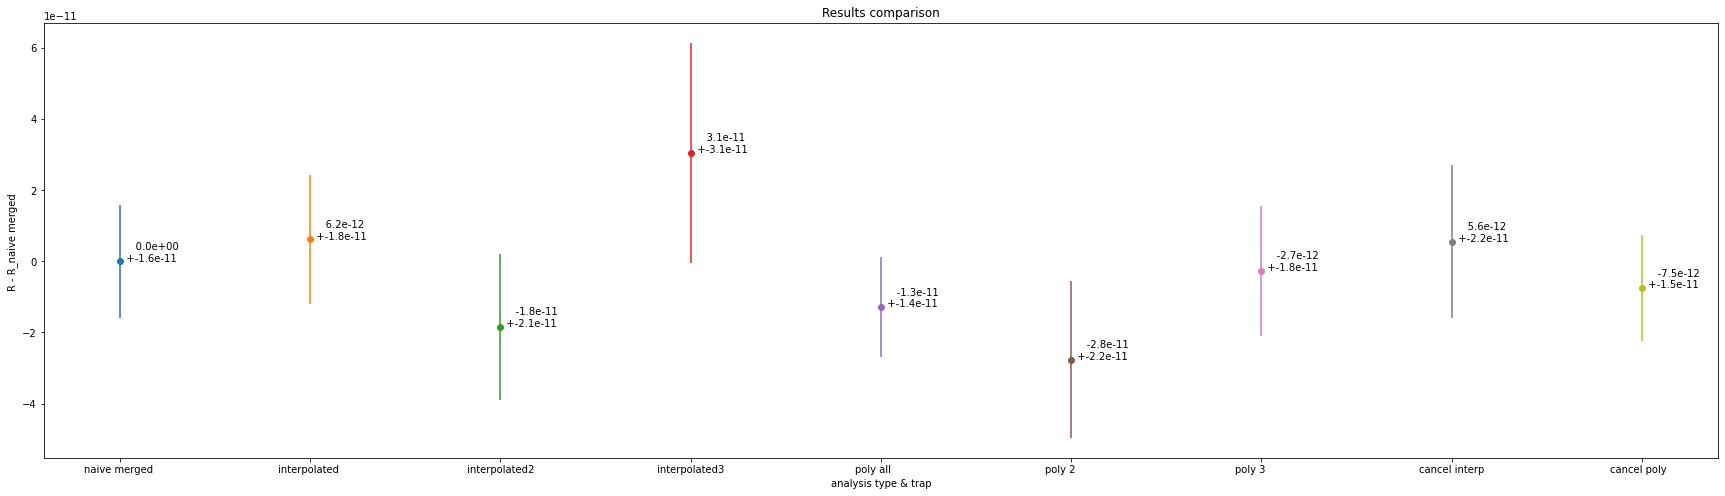

e:\git_repositories\controlsystem3\repositories\ft-icr_toolkit\fticr_toolkit\visualization.py:786: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



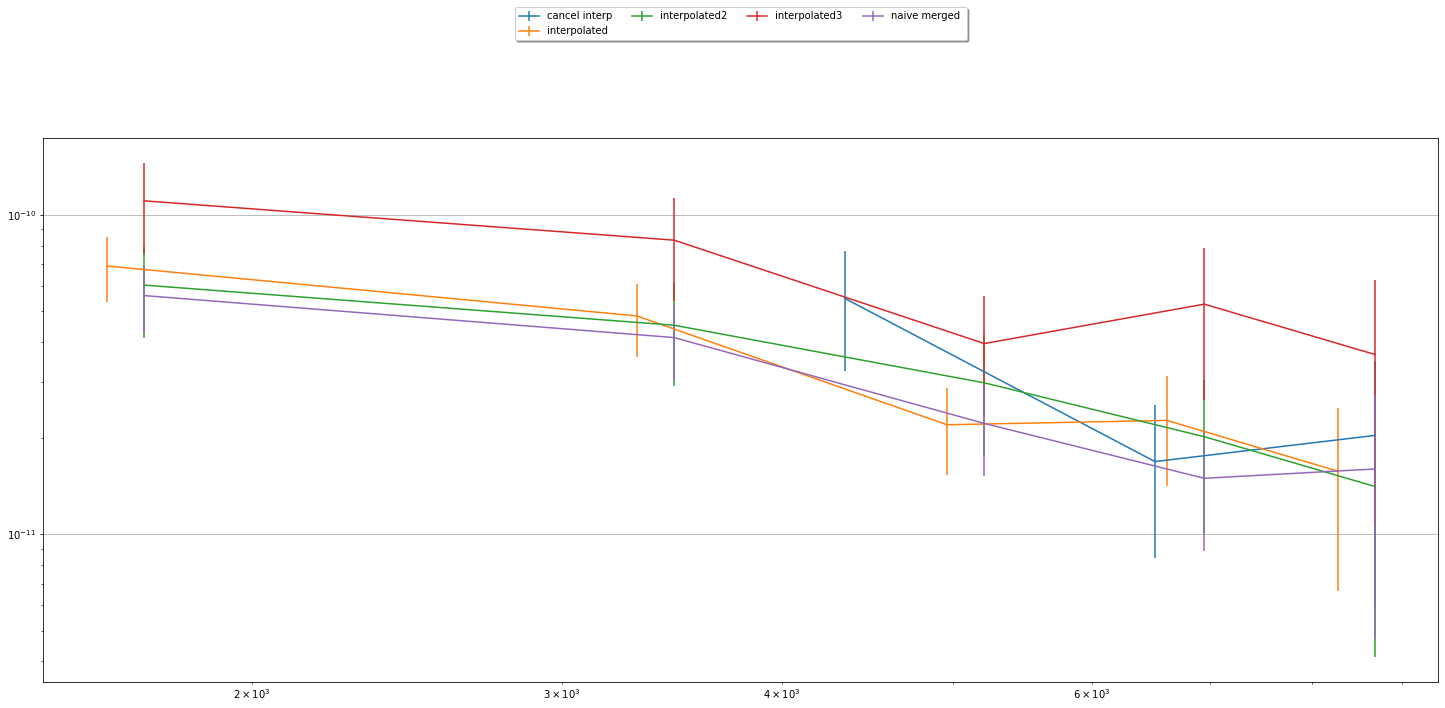

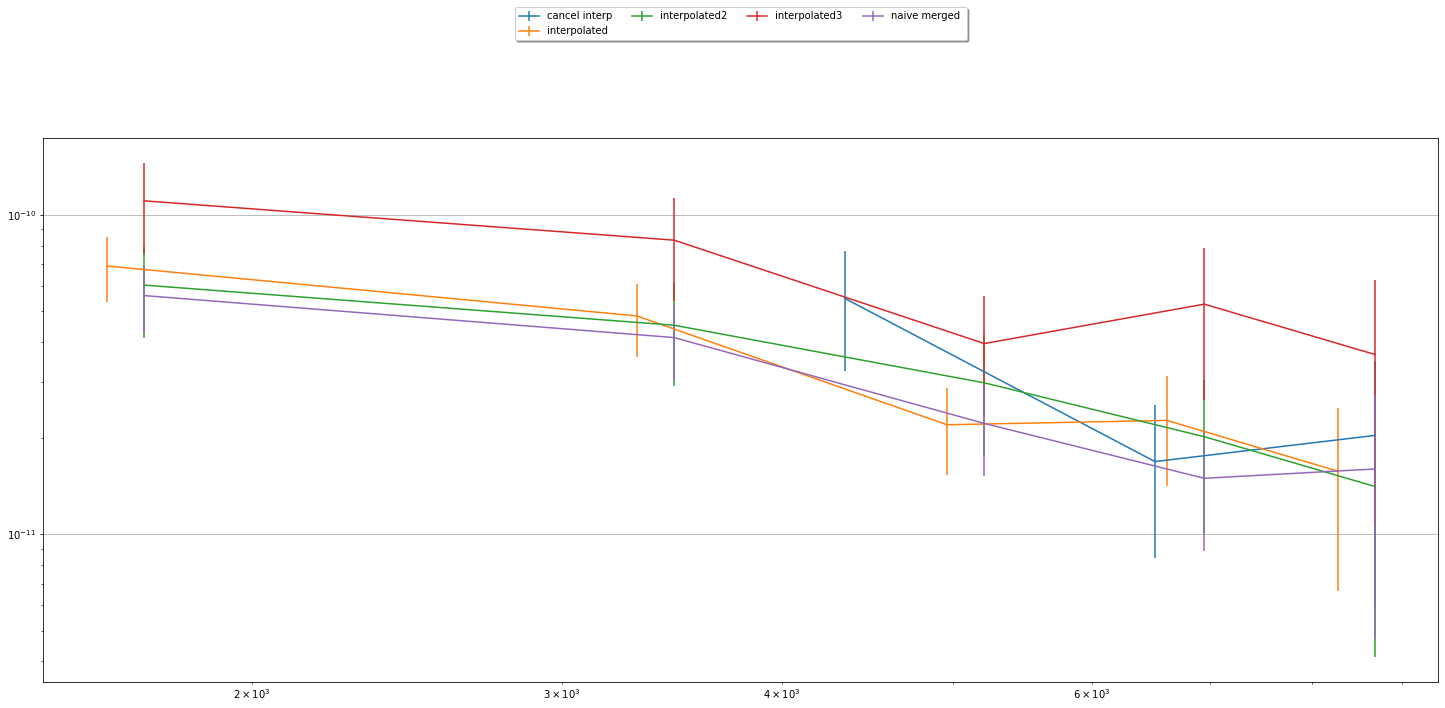

In [49]:
one_df = step8_naive_results_merged.copy(deep=True)
one_df["R"] = 1
one_df["dR"] = 1e-11
one_df["Rminus"] = 0

results = {
    #"one          ": one_df,
    "naive merged ": step8_naive_results_merged,
    "interpolated ": step9_interpolate_results,
    "interpolated2": step9_interpolate_results[step9_interpolate_results['trap']==2],
    "interpolated3": step9_interpolate_results[step9_interpolate_results['trap']==3],
    "poly all     ": step10_polyfit_best,
    "poly 2       ": step10_polyfit_best[step10_polyfit_best['trap']==2],
    "poly 3       ": step10_polyfit_best[step10_polyfit_best['trap']==3],
    #"cancel merged ": step11_cancel_naive_results_merged,
    "cancel interp": step12_cancel_interpol_results,
    "cancel poly  ": step13_cancel_polyfit_best,
}

visualization.compare(results, time='time_p')
visualization.allancompare(results, time='time_p')

In [50]:
"""
data_to_look_at = step8_naive_results_merged
#data_to_look_at = step11_cancel_naive_results_merged
#data_to_look_at = step7_results[ (step7_results['trap']==2) & (step7_results['position']=='position_2') & (step7_results['masked']==False) ]
#ycol = 'R'
ycol = 'nu_c'
tcol = 'time_p'
data_to_look_at.sort_values(tcol)

data_to_look_at['epoch'] = data_to_look_at[tcol].astype("int64")//1e9
data_to_look_at['seconds'] = data_to_look_at['epoch'] - data_to_look_at['epoch'].min()
statistics.allantest(data_to_look_at[ycol].to_numpy(), data_to_look_at.seconds.to_numpy())
"""

'\ndata_to_look_at = step8_naive_results_merged\n#data_to_look_at = step11_cancel_naive_results_merged\n#data_to_look_at = step7_results[ (step7_results[\'trap\']==2) & (step7_results[\'position\']==\'position_2\') & (step7_results[\'masked\']==False) ]\n#ycol = \'R\'\nycol = \'nu_c\'\ntcol = \'time_p\'\ndata_to_look_at.sort_values(tcol)\n\ndata_to_look_at[\'epoch\'] = data_to_look_at[tcol].astype("int64")//1e9\ndata_to_look_at[\'seconds\'] = data_to_look_at[\'epoch\'] - data_to_look_at[\'epoch\'].min()\nstatistics.allantest(data_to_look_at[ycol].to_numpy(), data_to_look_at.seconds.to_numpy())\n'